In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory, make_class
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #


## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH

# Override default pprint
builtins.pprint = wide_pprint

text_formatter: PlainTextFormatter = IPython.get_ipython().display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
import pyphocorehelpers.programming_helpers as programming_helpers

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns, parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array
doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
print(f"doc_output_parent_folder: {doc_output_parent_folder}")
assert doc_output_parent_folder.exists()

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_evaluate_required_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphocorehelpers.exception_helpers import ExceptionPrintingContext, CapturedException
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates, DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions,  RankOrderComputationsContainer, RankOrderResult, RankOrderAnalyses
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
# from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')

from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path('/Users/pho/data'), Path(r'/Users/pho/cloud/turbo/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/home/halechr/FastData'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data')] # Path('/Volumes/FedoraSSD/FastData'), 
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
	global global_data_root_parent_path
	new_global_data_root_parent_path = new_path.resolve()
	global_data_root_parent_path = new_global_data_root_parent_path
	print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
	assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
			
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

Automatic pdb calling has been turned OFF
doc_output_parent_folder: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log
DAY_DATE_STR: 2024-04-25, DAY_DATE_TO_USE: 2024-04-25
NOW_DATETIME: 2024-04-25_0645AM, NOW_DATETIME_TO_USE: 2024-04-25_0645AM
global_data_root_parent_path changed to W:\Data


ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('W:/Data'))

# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'
local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=a_sess.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context: IdentifyingContext = good_contexts_list[1] # select the session from all of the good sessions here.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15') # DONE. Very good. Many good Pfs, many good replays.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43') # DONE, might be the BEST SESSION, good example session with lots of place cells, clean replays, and clear bar graphs.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31') # DONE, Good Pfs but no good replays ---- VERY weird effect of the replays, a sharp drop to strongly negative values more than 3/4 through the experiment.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-13_14-42-6') # BAD, 2023-07-14, unsure why still.
curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19') # DONE, GREAT, both good Pfs and replays! Interesting see-saw!

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25') # DONE, Added replay selections. Very "jumpy" between the starts and ends of the track.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40') # 2024-01-10 new RANKORDER APOGEE | DONE, Added replay selections. A TON of putative replays in general, most bad, but some good. LOOKIN GOOD!
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='twolong_LR_pf1Dsession_name='2006-4-12_15-25-59') # BAD, No Epochs
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-16_18-47-52')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-17_12-52-15')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-25_13-20-55')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-28_12-38-13')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44') # BAD: Confirmed frequent jumping off of the track in this session. DONE, good. Many good pfs, many good replays. Noticed very strange jumping off the track in the 3D behavior/spikes viewer. Is there something wrong with this session?
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0') # DONE, good?, replays selected, few  # BAD: Seems like in 3D view there's also jumping off of the track in this session.
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25') # DONE, very few replays

# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_12-15-3') ### KeyError: 'maze1_odd'
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_22-4-5') ### 

# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54') # NEWDONE, replays selected, quite a few replays but few are very good.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25')

local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# 
# # Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_includelist = ['maze']
epoch_name_includelist = None
active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation',
                                            #    'pfdt_computation',
                                                'firing_rate_trends',
                                                # 'pf_dt_sequential_surprise', 
                                            #    'ratemap_peaks_prominence2d',
                                                'position_decoding', 
                                                # 'position_decoding_two_step', 
                                            #    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_rate_remapping',
                                            #     'long_short_inst_spike_rate_groups',
                                            #     'long_short_endcap_analysis',
                                            # 'split_to_directional_laps',
]

curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'



## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except Exception as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')


basedir: W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19
Loading loaded session pickle file results : W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle.pkl... 

INFO:com.PhoHale.Spike3D.pipeline:NeuropyPipeline.__setstate__(state="{'pipeline_name': 'kdiba_pipeline', 'session_data_type': 'kdiba', '_stage': <pyphoplacecellanalysis.General.Pipeline.Stages.Display.DisplayPipelineStage object at 0x000001D1F4B1FA60>}")
INFO:com.PhoHale.Spike3D.pipeline:select_filters(...) with: []
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on filtered_session with filter named "maze1_odd"...
INFO:com.PhoHale.Spike3D.pipeline:WARNING: skipping computation because overwrite_extant_results=False and active_computation_results[maze1_odd] already exists and is non-None
INFO:com.PhoHale.Spike3D.pipeline:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on fil

done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle.pkl.
properties already present in pickled version. No need to save.
pipeline load success!
using provided computation_functions_name_includelist: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'position_decoding']
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even

INFO:com.PhoHale.Spike3D.pipeline:WARNING: skipping computation because overwrite_extant_results=False and active_computation_results[maze_even] already exists and is non-None
INFO:com.PhoHale.Spike3D.pipeline:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on filtered_session with filter named "maze1_any"...
INFO:com.PhoHale.Spike3D.pipeline:WARNING: skipping computation because overwrite_extant_results=False and active_computation_results[maze1_any] already exists and is non-None
INFO:com.PhoHale.Spike3D.pipeline:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:com.PhoHale.Spike3D.pipeline:Performing perform_action_for_all_contexts with action E

	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
saving_mode.shouldSave == False, so not saving at the end of batch_load_session
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting Computatio

In [ ]:
BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_GL'
# BATCH_DATE_TO_USE: str = '2024-04-02_Apogee' # TODO: Change this as needed, templating isn't actually doing anything rn.

known_collected_output_paths = [Path(v).resolve() for v in ['/nfs/turbo/umms-kdiba/Data/Output/collected_outputs', '/home/halechr/FastData/collected_outputs/',
                                                           '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                           r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs',
                                                          'output/gen_scripts/']]
collected_outputs_path = find_first_extant_path(known_collected_output_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: {collected_outputs_path} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_path: {collected_outputs_path}')
# collected_outputs_path.mkdir(exist_ok=True)
# assert collected_outputs_path.exists()

## Build the output prefix from the session context:
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: "{CURR_BATCH_OUTPUT_PREFIX}"')

In [ ]:


list(curr_active_pipeline.global_computation_results.computed_data.keys())


# 2024-01-22 ERROR: when the pipeline is manually saved, its global_computations seem to be saved to the pickle too. After modifying how global computations are loaded from pickle, the following global computations code block no longer appropriately overwrites the existing results.

In [ ]:
# pickle_problem_result_names = ['directional_decoders_evaluate_epochs', 'directional_decoders_decode_continuous']
pickle_problem_global_result_key_names = ['DirectionalDecodersDecoded', 'DirectionalDecodersEpochsEvaluations']
# pickle_problem_global_result_key_names = ['DirectionalLaps', 'DirectionalMergedDecoders', 'RankOrder', 'DirectionalDecodersDecoded']
global_dropped_keys, local_dropped_keys = curr_active_pipeline.perform_drop_computed_result(computed_data_keys_to_drop=pickle_problem_global_result_key_names, debug_print=True)

#### GLOBAL COMPUTE via `batch_extended_computations(...)`:

In [3]:
extended_computations_include_includelist = ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    'extended_stats',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 
    'long_short_post_decoding', # #TODO 2024-01-19 05:49: - [ ] `'long_short_post_decoding' is broken for some reason `AttributeError: 'NoneType' object has no attribute 'active_filter_epochs'``
    # 'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    'rank_order_shuffle_analysis',
    'directional_train_test_split',
    'directional_decoders_decode_continuous',
    'directional_decoders_evaluate_epochs',
    'directional_decoders_epoch_heuristic_scoring',
] # do only specified

force_recompute_override_computations_includelist = None
# force_recompute_override_computations_includelist = ['merged_directional_placefields']
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis'] # , 'directional_decoders_decode_continuous'
# force_recompute_override_computations_includelist = ['directional_decoders_decode_continuous'] # 


In [4]:
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_train_test_split', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'], so only performing these extended computations.
Running batch_evaluate_required_computations(...) with global_epoch_name: "maze_any"
done with all batch_evaluate_required_computations(...).
needs_computation_output_dict: []


In [5]:
if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # curr_active_pipeline.load_pickled_global_computation_results()
        sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist) # is new
        print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
    except Exception as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results: {e}')
        raise


Loading loaded session pickle file results : W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\output\global_computation_results.pkl... done.
sucessfully_updated_keys: ['DirectionalLaps', 'DirectionalMergedDecoders', 'RankOrder', 'long_short_leave_one_out_decoding_analysis', 'short_long_pf_overlap_analyses', 'long_short_fr_indicies_analysis', 'jonathan_firing_rate_analysis', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap', 'TrainTestSplit', 'DirectionalDecodersDecoded', 'DirectionalDecodersEpochsEvaluations']
successfully_loaded_keys: ['DirectionalLaps', 'DirectionalMergedDecoders', 'RankOrder', 'long_short_leave_one_out_decoding_analysis', 'short_long_pf_overlap_analyses', 'long_short_fr_indicies_analysis', 'jonathan_firing_rate_analysis', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap', 'TrainTestSplit', 'DirectionalDecodersDecoded', 'DirectionalDecodersEpochsEvaluations']


In [6]:
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_train_test_split', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'], so only performing these extended computations.
Running batch_evaluate_required_computations(...) with global_epoch_name: "maze_any"
done with all batch_evaluate_required_computations(...).
needs_computation_output_dict: []


In [7]:

curr_active_pipeline.reload_default_computation_functions()

force_recompute_global = force_reload
# force_recompute_global = True
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# except Exception as e:
#     exception_info = sys.exc_info()
#     e = CapturedException(e, exception_info)
#     print(f'second half threw: {e}')

# 4m 5.2s for inst fr computations

#34m 6.7s

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_train_test_split', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'], so only performing these extended computations.
Running batch_extended_computations(...) with global_epoch_name: "maze_any"
done with all batch_extended_computations(...).
no changes in global results.


## Specific Recomputations

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
each_epoch_each_result_computation_completion_times

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
curr_active_pipeline.global_computation_results.computation_config.instantaneous_time_bin_size_seconds = 0.01

In [ ]:
extended_computations_include_includelist=['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    'extended_stats',
    'long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    # 'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    'rank_order_shuffle_analysis',
    'directional_decoders_decode_continuous',
    'directional_decoders_evaluate_epochs',
    'directional_decoders_epoch_heuristic_scoring',
] # do only specified

force_recompute_override_computations_includelist = [
    # 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',
    # 'lap_direction_determination', 'DirectionalLaps',
    # 'merged_directional_placefields',
    # 'directional_decoders_decode_continuous',
]
# force_recompute_override_computations_includelist = None

newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
newly_computed_values


In [ ]:
force_recompute_global

In [ ]:
# curr_active_pipeline.reload_default_computation_functions()
# force_recompute_override_computations_includelist = ['_decode_continuous_using_directional_decoders']
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], force_recompute_override_computations_includelist=force_recompute_override_computations_includelist,
# 												   enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(extended_computations_include_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.02}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.20}, {'time_bin_size': 0.20}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_evaluate_epochs'], computation_kwargs_list=[{'should_skip_radon_transform': False}], enabled_filter_names=None, fail_on_exception=True, debug_print=True)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_epoch_heuristic_scoring'], enabled_filter_names=None, fail_on_exception=True, debug_print=False) # OK FOR PICKLE

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_train_test_split'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['lap_direction_determination'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['extended_stats'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.2}, {'time_bin_size': 0.025}, {'should_skip_radon_transform': False}, {}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    ], enabled_filter_names=None, fail_on_exception=True, debug_print=False) # , computation_kwargs_list=[{'should_skip_radon_transform': False}]

In [8]:
# directional_merged_decoders_result = deepcopy(directional_decoders_epochs_decode_result)
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)

global_computation_results = curr_active_pipeline.global_computation_results

 # spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results = global_computation_results.computed_data['RankOrder'] # : "RankOrderComputationsContainer"
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
# included_qclu_values: List[int] = rank_order_results.included_qclu_values
directional_laps_results: DirectionalLapsResult = global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
# print(f'included_qclu_values: {included_qclu_values}')

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalMergedDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
# pos_bin_size = _recover_position_bin_size(track_templates.get_decoders()[0]) # 3.793023081021702
# print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')
# pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size

## Simple Pearson Correlation
assert spikes_df is not None
(laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names = directional_merged_decoders_result.compute_simple_spike_time_v_pf_peak_x_by_epoch(track_templates=track_templates, spikes_df=deepcopy(spikes_df))
## OUTPUTS: (laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names
## Computes the highest-valued decoder for this score:
best_decoder_index_col_name: str = 'best_decoder_index'
laps_simple_pf_pearson_merged_df[best_decoder_index_col_name] = laps_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)
ripple_simple_pf_pearson_merged_df[best_decoder_index_col_name] = ripple_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)


In [9]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict

print(f'pos_bin_size: {pos_bin_size}')
print(f'ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')
print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}')

# Radon Transforms:
decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict
decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

# Weighted correlations:
laps_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
ripple_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
decoder_laps_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
decoder_ripple_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

# Pearson's correlations:
laps_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
ripple_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

# laps_simple_pf_pearson_merged_df
# ripple_simple_pf_pearson_merged_df

## Drop rows where all are missing
corr_column_names = ['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']
# ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='all') # 350/412 rows
filtered_laps_simple_pf_pearson_merged_df: pd.DataFrame = laps_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows
filtered_ripple_simple_pf_pearson_merged_df: pd.DataFrame = ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows

## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_ripple_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_laps_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}


len(active_epochs_df): 718
min_num_unique_aclu_inclusions: 10
len(active_epochs_df): 520
pos_bin_size: 3.775693131596347
ripple_decoding_time_bin_size: 0.025
laps_decoding_time_bin_size: 0.2


In [ ]:
# 💾 Export CSVs: 
## INPUTS: directional_decoders_epochs_decode_result,

extracted_merged_scores_df = directional_decoders_epochs_decode_result.build_complete_all_scores_merged_df()
# extracted_merged_scores_df

print(f'\tAll scores df CSV exporting...')

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
export_df_dict = {'ripple_all_scores_merged_df': extracted_merged_scores_df}
_csv_export_paths = directional_decoders_epochs_decode_result.perform_export_dfs_dict_to_csvs(extracted_dfs_dict=export_df_dict, parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            #   user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                            #   valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                            )

print(f'\t\tsuccessfully exported ripple_all_scores_merged_df to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _csv_export_paths.items()])
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')

In [ ]:

# extracted_merged_scores_df.to_csv('test_(ripple_all_scores_merged_df).csv')

In [ ]:
 decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
# filtered_laps_simple_pf_pearson_merged_df
# filtered_ripple_simple_pf_pearson_merged_df
# decoder_ripple_weighted_corr_df_dict
ripple_weighted_corr_merged_df['ripple_start_t']


In [ ]:
wcorr_column_names = ['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']
filtered_ripple_simple_pf_pearson_merged_df.label = filtered_ripple_simple_pf_pearson_merged_df.label.astype('int64')
ripple_weighted_corr_merged_df['label'] = ripple_weighted_corr_merged_df['ripple_idx'].astype('int64')

filtered_ripple_simple_pf_pearson_merged_df.join(ripple_weighted_corr_merged_df[wcorr_column_names], on='start') # , on='label'
# filtered_ripple_simple_pf_pearson_merged_df.merge

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
print(list(ripple_weighted_corr_merged_df.columns))

In [ ]:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.save_selections()

a_decoded_filter_epochs_decoder_result_dict.epochs.find_data_indicies_from_epoch_times([380.75])

## 💾 Continue Saving/Exporting stuff

In [ ]:
curr_active_pipeline.save_global_computation_results() # newly_computed_values: [('pfdt_computation', 'maze_any')]

In [ ]:
split_save_folder, split_save_paths, split_save_output_types, failed_keys = curr_active_pipeline.save_split_global_computation_results(debug_print=True)

In [ ]:
curr_active_pipeline.export_pipeline_to_h5()

In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE) ## #TODO 2024-02-16 14:25: - [ ] PicklingError: Can't pickle <function make_set_closure_cell.<locals>.set_closure_cell at 0x7fd35e66b700>: it's not found as attr._compat.make_set_closure_cell.<locals>.set_closure_cell


In [ ]:
# curr_active_pipeline.save_pipeline()

#### Get computation times/info:

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
# each_epoch_each_result_computation_completion_times
# global_computation_completion_times

# curr_active_pipeline.get_merged_computation_function_validators()
# Get the names of the global and non-global computations:
all_validators_dict = curr_active_pipeline.get_merged_computation_function_validators()
global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if v.is_global}
non_global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if (not v.is_global)}
non_global_comp_names: List[str] = [v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['firing_rate_trends', 'spike_burst_detection', 'pf_dt_sequential_surprise', 'extended_stats', 'placefield_overlap', 'ratemap_peaks_prominence2d', 'velocity_vs_pf_simplified_count_density', 'EloyAnalysis', '_perform_specific_epochs_decoding', 'recursive_latent_pf_decoding', 'position_decoding_two_step', 'position_decoding', 'lap_direction_determination', 'pfdt_computation', 'pf_computation']
global_comp_names: List[str] = [v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['long_short_endcap_analysis', 'long_short_inst_spike_rate_groups', 'long_short_post_decoding', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_decoding_analyses', 'PBE_stats', 'rank_order_shuffle_analysis', 'directional_decoders_epoch_heuristic_scoring', 'directional_decoders_evaluate_epochs', 'directional_decoders_decode_continuous', 'merged_directional_placefields', 'split_to_directional_laps']

# mappings between the long computation function names and their short names:
non_global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))}
global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))} # '_perform_long_short_endcap_analysis': 'long_short_endcap_analysis', '_perform_long_short_instantaneous_spike_rate_groups_analysis': 'long_short_inst_spike_rate_groups', ...}

# convert long function names to short-names:
each_epoch_each_result_computation_completion_times = {an_epoch:{non_global_comp_names_map.get(k, k):v for k,v in a_results_dict.items()} for an_epoch, a_results_dict in each_epoch_each_result_computation_completion_times.items()}
global_computation_completion_times = {global_comp_names_map.get(k, k):v for k,v in global_computation_completion_times.items()}

each_epoch_each_result_computation_completion_times
global_computation_completion_times

In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_evaluate_required_computations

force_recompute_global = force_reload

active_probe_includelist = extended_computations_include_includelist
# active_probe_includelist = ['lap_direction_determination']
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=active_probe_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
needs_computation_output_dict
# valid_computed_results_output_list
# remaining_include_function_names

In [ ]:
'lap_direction_determination'

In [ ]:

recompute_earlier_than_date = datetime(2024, 4, 1, 0, 0, 0)
recompute_earlier_than_date

each_epoch_needing_recompute = [an_epoch for an_epoch, last_computed_datetime in each_epoch_latest_computation_time.items() if (last_computed_datetime < recompute_earlier_than_date)]
each_epoch_needing_recompute
each_epoch_each_result_needing_recompute = {an_epoch:{a_computation_name:last_computed_datetime for a_computation_name, last_computed_datetime in last_computed_datetimes_dict.items() if (last_computed_datetime < recompute_earlier_than_date)} for an_epoch, last_computed_datetimes_dict in each_epoch_each_result_computation_completion_times.items()}
each_epoch_each_result_needing_recompute

In [ ]:
curr_active_pipeline.global_computation_results.computation_times
curr_active_pipeline.global_computation_results
# curr_active_pipeline.try_load_split_pickled_global_computation_results

global_computation_times = deepcopy(curr_active_pipeline.global_computation_results.computation_times.to_dict()) # DynamicParameters({'perform_rank_order_shuffle_analysis': datetime.datetime(2024, 4, 3, 5, 41, 31, 287680), '_decode_continuous_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 12, 7, 337326), '_perform_long_short_decoding_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 361685), '_perform_long_short_pf_overlap_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 489296), '_perform_long_short_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 3, 73472), '_perform_jonathan_replay_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 5, 168790), '_perform_long_short_post_decoding_analysis': datetime.datetime(2024, 2, 16, 18, 13, 4, 734621), '_perform_long_short_endcap_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 274261), '_decode_and_evaluate_epochs_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 14, 37, 935482), '_perform_long_short_instantaneous_spike_rate_groups_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 131955), '_split_to_directional_laps': datetime.datetime(2024, 4, 3, 5, 11, 22, 627789), '_build_merged_directional_placefields': datetime.datetime(2024, 4, 3, 5, 11, 28, 376078)})
global_computation_times

# Pho Interactive Pipeline Jupyter Widget

In [10]:
import ipywidgets as widgets
from IPython.display import display
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files

_pipeline_jupyter_widget = interactive_pipeline_widget(curr_active_pipeline=curr_active_pipeline)
# display(_pipeline_jupyter_widget)
_pipeline_jupyter_widget

# End Run

In [11]:
# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_epoch_obj, short_epoch_obj = [Epoch(curr_active_pipeline.sess.epochs.to_dataframe().epochs.label_slice(an_epoch_name.removesuffix('_any'))) for an_epoch_name in [long_epoch_name, short_epoch_name]] #TODO 2023-11-10 20:41: - [ ] Issue with getting actual Epochs from sess.epochs for directional laps: emerges because long_epoch_name: 'maze1_any' and the actual epoch label in curr_active_pipeline.sess.epochs is 'maze1' without the '_any' part.
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_computation_config, short_computation_config, global_computation_config = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D

assert short_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'
assert long_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
t_start, t_delta, t_end

(0.0, 1236.2662453636294, 2587.801681999932)

In [ ]:
# I have several python variables I want to print: t_start, t_delta, t_end
# I want to generate a print statement that explicitly lists the variable name prior to its value like `print(f't_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')`
# Currently I have to t_start, t_delta, t_end
curr_active_pipeline.get_session_context()

print(f'{curr_active_pipeline.session_name}:\tt_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')

In [12]:
## long_short_decoding_analyses:
from attrs import astuple
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import LeaveOneOutDecodingAnalysis

curr_long_short_decoding_analyses: LeaveOneOutDecodingAnalysis = curr_active_pipeline.global_computation_results.computed_data['long_short_leave_one_out_decoding_analysis']
long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus, long_short_pf_neurons_diff, n_neurons, long_results_obj, short_results_obj, is_global = curr_long_short_decoding_analyses.long_decoder, curr_long_short_decoding_analyses.short_decoder, curr_long_short_decoding_analyses.long_replays, curr_long_short_decoding_analyses.short_replays, curr_long_short_decoding_analyses.global_replays, curr_long_short_decoding_analyses.long_shared_aclus_only_decoder, curr_long_short_decoding_analyses.short_shared_aclus_only_decoder, curr_long_short_decoding_analyses.shared_aclus, curr_long_short_decoding_analyses.long_short_pf_neurons_diff, curr_long_short_decoding_analyses.n_neurons, curr_long_short_decoding_analyses.long_results_obj, curr_long_short_decoding_analyses.short_results_obj, curr_long_short_decoding_analyses.is_global 
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_laps, long_replays, short_laps, short_replays, global_laps, global_replays = [long_short_fr_indicies_analysis_results[k] for k in ['long_laps', 'long_replays', 'short_laps', 'short_replays', 'global_laps', 'global_replays']]
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']

## Get global 'long_short_post_decoding' results:
curr_long_short_post_decoding = curr_active_pipeline.global_computation_results.computed_data['long_short_post_decoding']
expected_v_observed_result, curr_long_short_rr = curr_long_short_post_decoding.expected_v_observed_result, curr_long_short_post_decoding.rate_remapping
rate_remapping_df, high_remapping_cells_only = curr_long_short_rr.rr_df, curr_long_short_rr.high_only_rr_df
Flat_epoch_time_bins_mean, Flat_decoder_time_bin_centers, num_neurons, num_timebins_in_epoch, num_total_flat_timebins, is_short_track_epoch, is_long_track_epoch, short_short_diff, long_long_diff = expected_v_observed_result.Flat_epoch_time_bins_mean, expected_v_observed_result.Flat_decoder_time_bin_centers, expected_v_observed_result.num_neurons, expected_v_observed_result.num_timebins_in_epoch, expected_v_observed_result.num_total_flat_timebins, expected_v_observed_result.is_short_track_epoch, expected_v_observed_result.is_long_track_epoch, expected_v_observed_result.short_short_diff, expected_v_observed_result.long_long_diff

jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
(epochs_df_L, epochs_df_S), (filter_epoch_spikes_df_L, filter_epoch_spikes_df_S), (good_example_epoch_indicies_L, good_example_epoch_indicies_S), (short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset), new_all_aclus_sort_indicies, assigning_epochs_obj = PAPER_FIGURE_figure_1_add_replay_epoch_rasters(curr_active_pipeline)
neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=0.05)

## Update long_exclusive/short_exclusive properties with `long_short_fr_indicies_df`
# long_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)
# short_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)


WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above
WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above


In [13]:
# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Most popular
# long_LR_name, short_LR_name, long_RL_name, short_RL_name, global_any_name

# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)


In [14]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult, DirectionalLapsResult, DirectionalDecodersDecodedResult

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
directional_merged_decoders_result: DirectionalMergedDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']   
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: float = rank_order_results.included_qclu_values
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')

minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']

## UNPACK HERE via direct property access:
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
ripple_decoding_time_bin_size = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

# New items:
decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

# Weighted correlations:
laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

# Pearson's correlations:
laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [15]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersDecodedResult

if 'DirectionalDecodersDecoded' in curr_active_pipeline.global_computation_results.computed_data:
    directional_decoders_decode_result: DirectionalDecodersDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
    all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
    spikes_df = directional_decoders_decode_result.spikes_df
    continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
    previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
    print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')


previously_decoded time_bin_sizes: [0.025]


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult


most_recent_time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# most_recent_time_bin_size
most_recent_continuously_decoded_dict = deepcopy(directional_decoders_decode_result.most_recent_continuously_decoded_dict)
# most_recent_continuously_decoded_dict

## Adds in the 'pseudo2D' decoder in:
time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# time_bin_size: float = 0.01
print(f'time_bin_size: {time_bin_size}')
continuously_decoded_dict = continuously_decoded_result_cache_dict[time_bin_size]
pseudo2D_decoder_continuously_decoded_result = continuously_decoded_dict.get('pseudo2D', None)
if pseudo2D_decoder_continuously_decoded_result is None:
	# compute here...
	## Currently used for both cases to decode:
	t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
	single_global_epoch_df: pd.DataFrame = pd.DataFrame({'start': [t_start], 'stop': [t_end], 'label': [0]}) # Build an Epoch object containing a single epoch, corresponding to the global epoch for the entire session:
	single_global_epoch: Epoch = Epoch(single_global_epoch_df)
	spikes_df = directional_decoders_decode_result.spikes_df
	pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = pseudo2D_decoder.decode_specific_epochs(spikes_df=deepcopy(spikes_df), filter_epochs=single_global_epoch, decoding_time_bin_size=time_bin_size, debug_print=False)
	continuously_decoded_dict['pseudo2D'] = pseudo2D_decoder_continuously_decoded_result
	continuously_decoded_dict

In [16]:
# NEW 2023-11-22 method: Get the templates (which can be filtered by frate first) and the from those get the decoders):        
# track_templates: TrackTemplates = directional_laps_results.get_shared_aclus_only_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # shared-only
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)

# `LongShortStatsItem` form (2024-01-02):
# LR_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
# RL_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])
LR_results_long_short_z_diffs = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
RL_results_long_short_z_diff = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])


In [17]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestSplitResult

directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)
training_data_portion: float = directional_train_test_split_result.training_data_portion
test_data_portion: float = directional_train_test_split_result.test_data_portion
test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict

In [ ]:
active_burst_intervals = curr_active_pipeline.computation_results[global_epoch_name].computed_data['burst_detection']['burst_intervals']
# active_burst_intervals

In [ ]:
active_extended_stats = global_results['extended_stats']

In [ ]:
# Relative Entropy/Surprise Results:
active_extended_stats = global_results['extended_stats']
active_relative_entropy_results = active_extended_stats['pf_dt_sequential_surprise'] # DynamicParameters
historical_snapshots = active_relative_entropy_results['historical_snapshots']
post_update_times: np.ndarray = active_relative_entropy_results['post_update_times'] # (4152,) = (n_post_update_times,)
snapshot_differences_result_dict = active_relative_entropy_results['snapshot_differences_result_dict']
time_intervals: np.ndarray = active_relative_entropy_results['time_intervals']
surprise_time_bin_duration = (post_update_times[2]-post_update_times[1])
long_short_rel_entr_curves_frames: np.ndarray = active_relative_entropy_results['long_short_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
short_long_rel_entr_curves_frames: np.ndarray = active_relative_entropy_results['short_long_rel_entr_curves_frames'] # (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)
flat_relative_entropy_results: np.ndarray = active_relative_entropy_results['flat_relative_entropy_results'] # (149, 63) - (nSnapshots, nXbins)
flat_jensen_shannon_distance_results: np.ndarray = active_relative_entropy_results['flat_jensen_shannon_distance_results'] # (149, 63) - (nSnapshots, nXbins)
flat_jensen_shannon_distance_across_all_positions: np.ndarray = np.sum(np.abs(flat_jensen_shannon_distance_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)
flat_surprise_across_all_positions: np.ndarray = np.sum(np.abs(flat_relative_entropy_results), axis=1) # sum across all position bins # (4152,) - (nSnapshots)

## Get the placefield dt matrix:
if 'snapshot_occupancy_weighted_tuning_maps' not in active_relative_entropy_results:
	## Compute it if missing:
	occupancy_weighted_tuning_maps_over_time = np.stack([placefield_snapshot.occupancy_weighted_tuning_maps_matrix for placefield_snapshot in historical_snapshots.values()])
	active_relative_entropy_results['snapshot_occupancy_weighted_tuning_maps'] = occupancy_weighted_tuning_maps_over_time
else:
	occupancy_weighted_tuning_maps_over_time = active_relative_entropy_results['snapshot_occupancy_weighted_tuning_maps'] # (n_post_update_times, n_neurons, n_xbins)


In [ ]:
# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt

In [ ]:
## long_short_endcap_analysis: checks for cells localized to the endcaps that have their placefields truncated after shortening the track
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
disappearing_endcap_aclus = truncation_checking_result.disappearing_endcap_aclus
# disappearing_endcap_aclus
trivially_remapping_endcap_aclus = truncation_checking_result.minor_remapping_endcap_aclus
# trivially_remapping_endcap_aclus
significant_distant_remapping_endcap_aclus = truncation_checking_result.significant_distant_remapping_endcap_aclus
# significant_distant_remapping_endcap_aclus
appearing_aclus = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[jonathan_firing_rate_analysis_result.neuron_replay_stats_df['track_membership'] == SplitPartitionMembership.RIGHT_ONLY].index
# appearing_aclus

# POST-Compute:

In [18]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multi_sort_raster_browser
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import paired_separately_sort_neurons, paired_incremental_sort_neurons # _display_directional_template_debugger
from neuropy.utils.indexing_helpers import paired_incremental_sorting, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies
from pyphoplacecellanalysis.GUI.Qt.Widgets.ScrollBarWithSpinBox.ScrollBarWithSpinBox import ScrollBarWithSpinBox

from neuropy.utils.mixins.HDF5_representable import HDF_SerializationMixin
from pyphoplacecellanalysis.General.Model.ComputationResults import ComputedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses, RankOrderResult, ShuffleHelper, Zscorer, LongShortStatsTuple, DirectionalRankOrderLikelihoods, DirectionalRankOrderResult, RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalMergedDecodersResult

## Display Testing
# from pyphoplacecellanalysis.External.pyqtgraph import QtGui
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent, pyqtplot_plot_image

spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: List[int] = rank_order_results.included_qclu_values
ripple_result_tuple, laps_result_tuple = rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')
# ripple_result_tuple

## Unpacks `rank_order_results`: 
# global_replays = Epoch(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# active_replay_epochs, active_epochs_df, active_selected_spikes_df = combine_rank_order_results(rank_order_results, global_replays, track_templates=track_templates)
# active_epochs_df

# ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices
dir_index_to_direction_name_map: Dict[int, str] = {0:'LR', 1:"RL"}


## All three DataFrames are the same number of rows, each with one row corresponding to an Epoch:
active_replay_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
# active_replay_epochs_df

# Change column type to int8 for columns: 'long_best_direction_indices', 'short_best_direction_indices'
# directional_likelihoods_df = pd.DataFrame.from_dict(ripple_result_tuple.directional_likelihoods_tuple._asdict()).astype({'long_best_direction_indices': 'int8', 'short_best_direction_indices': 'int8'})
directional_likelihoods_df = ripple_result_tuple.directional_likelihoods_df
# directional_likelihoods_df

# 2023-12-15 - Newest method:
# laps_combined_epoch_stats_df = rank_order_results.laps_combined_epoch_stats_df

# ripple_combined_epoch_stats_df: pd.DataFrame  = rank_order_results.ripple_combined_epoch_stats_df
# ripple_combined_epoch_stats_df


# # Concatenate the three DataFrames along the columns axis:
# # Assert that all DataFrames have the same number of rows:
# assert len(active_replay_epochs_df) == len(directional_likelihoods_df) == len(ripple_combined_epoch_stats_df), "DataFrames have different numbers of rows."
# # Assert that all DataFrames have at least one row:
# assert len(active_replay_epochs_df) > 0, "active_replay_epochs_df is empty."
# assert len(directional_likelihoods_df) > 0, "directional_likelihoods_df is empty."
# assert len(ripple_combined_epoch_stats_df) > 0, "ripple_combined_epoch_stats_df is empty."
# merged_complete_epoch_stats_df: pd.DataFrame = pd.concat([active_replay_epochs_df.reset_index(drop=True, inplace=False), directional_likelihoods_df.reset_index(drop=True, inplace=False), ripple_combined_epoch_stats_df.reset_index(drop=True, inplace=False)], axis=1)
# merged_complete_epoch_stats_df = merged_complete_epoch_stats_df.set_index(active_replay_epochs_df.index, inplace=False)

# merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
# merged_complete_epoch_stats_df.to_csv('output/2023-12-21_merged_complete_epoch_stats_df.csv')
# merged_complete_epoch_stats_df

laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalMergedDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')

laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df


minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]
laps_decoding_time_bin_size: 0.2, ripple_decoding_time_bin_size: 0.025


In [19]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import HeuristicReplayScoring
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_filter_replay_epochs

filtered_epochs_df, filtered_decoder_filter_epochs_decoder_result_dict, filtered_ripple_all_epoch_bins_marginals_df = _perform_filter_replay_epochs(curr_active_pipeline, global_epoch_name, track_templates, decoder_ripple_filter_epochs_decoder_result_dict, ripple_all_epoch_bins_marginals_df, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size)
filtered_epochs_df
# filtered_ripple_all_epoch_bins_marginals_df

len(active_epochs_df): 718
min_num_unique_aclu_inclusions: 10
len(active_epochs_df): 520
df_column_names: [['start', 'stop', 'label', 'duration', 'score', 'velocity', 'intercept', 'speed', 'wcorr', 'P_decoder', 'pearsonr', 'travel', 'coverage', 'jump', 'sequential_correlation', 'monotonicity_score', 'laplacian_smoothness', 'longest_sequence_length', 'longest_sequence_length_ratio', 'direction_change_bin_ratio', 'congruent_dir_bins_ratio', 'total_congruent_direction_change', 'is_user_annotated_epoch', 'is_valid_epoch'], ['start', 'stop', 'label', 'duration', 'score', 'velocity', 'intercept', 'speed', 'wcorr', 'P_decoder', 'pearsonr', 'travel', 'coverage', 'jump', 'sequential_correlation', 'monotonicity_score', 'laplacian_smoothness', 'longest_sequence_length', 'longest_sequence_length_ratio', 'direction_change_bin_ratio', 'congruent_dir_bins_ratio', 'total_congruent_direction_change', 'is_user_annotated_epoch', 'is_valid_epoch'], ['start', 'stop', 'label', 'duration', 'score', 'velocity

start         stop label  duration  n_unique_aclus
0      66.661598    66.779040     5  0.117442              11
1     292.623671   292.808267    51  0.184596              18
2     304.440267   304.655644    54  0.215378              20
3     380.745850   380.903966    62  0.158116              14
4     461.141462   461.289748    75  0.148285              18
5     470.140267   470.317983    81  0.177715              12
..           ...          ...   ...       ...             ...
121  2472.997994  2473.150427   711  0.152433              13
122  2482.131905  2482.612550   715  0.480645              28
123  2505.334986  2505.671616   722  0.336630              21
124  2530.724715  2530.920524   732  0.195809              19
125  2556.111956  2556.382507   742  0.270551              20
126  2556.596748  2556.918202   743  0.321454              15

[127 rows x 5 columns]

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [27]:
min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

is_included_large_wcorr_diff = np.any((filtered_ripple_all_epoch_bins_marginals_df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
# is_included_large_wcorr_diff
is_included_high_wcorr = np.any((filtered_ripple_all_epoch_bins_marginals_df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = filtered_ripple_all_epoch_bins_marginals_df[is_included_large_wcorr_diff]
# df = filtered_ripple_all_epoch_bins_marginals_df[is_included_high_wcorr]
df

# delta_aligned_start_t

significant_epochs_start_ts = np.squeeze(df['ripple_start_t'].to_numpy()) ## for filtering

filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(significant_epochs_start_ts) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()} # working filtered
filtered_decoder_filter_epochs_decoder_result_dict
filtered_epochs_df = filtered_epochs_df.epochs.matching_epoch_times_slice(significant_epochs_start_ts)
# filtered_ripple_all_epoch_bins_marginals_df = filtered_ripple_all_epoch_bins_marginals_df.epochs.matching_epoch_times_slice(significant_epochs_start_ts)


P_LR      P_RL    P_Long   P_Short  ripple_idx  ripple_start_t  long_best_wcorr  short_best_wcorr  wcorr_abs_diff  long_best_pearsonr  short_best_pearsonr  pearsonr_abs_diff        session_name  delta_aligned_start_t  time_bin_size  is_user_annotated_epoch
0    0.155255  0.844745  0.845678  0.154322           3       66.661598         0.651144          0.206095        0.445049           -0.447410            -0.476514          -0.029104  2006-6-07_16-40-19           -1169.604647          0.025                     True
5    0.486458  0.513542  0.556969  0.443031          69      470.140267        -0.813930         -0.422326        0.391604           -0.470560            -0.299618           0.170942  2006-6-07_16-40-19            -766.125978          0.025                     True
8    0.169957  0.830043  0.801129  0.198871          81      489.425075        -0.809168         -0.282885        0.526282           -0.823615            -0.572899           0.250715  2006-6-07_16-40-19            -746.841170          0.025                     True
13   0.369848  0.630152  0.700939  0.299061         116      677.993063        -0.658488         -0.422050        0.236438           -0.177730             0.043697           0.134033  2006-6-07_16-40-19            -558.273182          0.025                     True
25   0.711221  0.288779  0.644023  0.355977         160      890.870266        -0.743053         -0.338236        0.404817           -0.416305            -0.430635          -0.014330  2006-6-07_16-40-19            -345.395979          0.025                     True
33   0.211840  0.788160  0.736443  0.263557         203      982.605331        -0.736271         -0.480140        0.256130            0.429617             0.543118          -0.113501  2006-6-07_16-40-19            -253.660914          0.025                     True
..        ...       ...       ...       ...         ...             ...              ...               ...             ...                 ...                  ...                ...                 ...                    ...            ...                      ...
72   0.089005  0.910995  0.546949  0.453051         405     1746.254067        -0.324136         -0.076486        0.247650            0.155086             0.021844           0.133243  2006-6-07_16-40-19             509.987821          0.025                     True
79   0.477764  0.522236  0.358805  0.641195         494     1994.072425        -0.445072         -0.860792       -0.415720           -0.793119            -0.833412          -0.040293  2006-6-07_16-40-19             757.806180          0.025                     True
89   0.752869  0.247131  0.414562  0.585438         542     2125.548306        -0.323930         -0.818942       -0.495011           -0.431061            -0.501798          -0.070738  2006-6-07_16-40-19             889.282060          0.025                     True
97   0.519648  0.480352  0.445717  0.554283         580     2201.847131        -0.614434         -0.303771        0.310663           -0.191587            -0.158160           0.033427  2006-6-07_16-40-19             965.580886          0.025                     True
106  0.105130  0.894870  0.191065  0.808935         629     2331.840711        -0.790356         -0.514316        0.276040           -0.118137             0.084040           0.034097  2006-6-07_16-40-19            1095.574465          0.025                     True
123  0.217543  0.782457  0.473388  0.526612         693     2505.334986        -0.831314         -0.607541        0.223772            0.315460             0.307569           0.007891  2006-6-07_16-40-19            1269.068741          0.025                     True

[18 rows x 16 columns]

{'long_LR': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: pandas.core.frame.DataFrame,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list | shape (n_epochs),
 	most_likely_position_indicies_list: list | shape (n_epochs),
 	spkcount: list | shape (n_epochs),
 	nbins: numpy.ndarray | shape (n_epochs),
 	time_bin_containers: list | shape (n_epochs),
 	time_bin_edges: list | shape (n_epochs),
 	epoch_description_list: list | shape (n_epochs)
 ),
 'long_RL': DecodedFilterEpochsResult(decoding_time_bin_size: float,
 	filter_epochs: pandas.core.frame.DataFrame,
 	num_filter_epochs: int,
 	most_likely_positions_list: list | shape (n_epochs),
 	p_x_given_n_list: list | shape (n_epochs),
 	marginal_x_list: list | shape (n_epochs),
 	marginal_y_list: list | shape (n_epochs),
 	most_likely_position_indicies_list: list | shape (n_

In [ ]:
included_qclu_values: List[int] = rank_order_results.included_qclu_values
included_qclu_values

In [ ]:
import seaborn as sns
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_quantile_diffs

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
global_epoch = curr_active_pipeline.filtered_epochs[global_epoch_name]
short_epoch = curr_active_pipeline.filtered_epochs[short_epoch_name]
split_time_t: float = short_epoch.t_start
active_context = curr_active_pipeline.sess.get_context()

collector = plot_quantile_diffs(filtered_ripple_all_epoch_bins_marginals_df, t_split=split_time_t, active_context=active_context)




In [ ]:
# ripple_merged_complete_epoch_stats_df
laps_merged_complete_epoch_stats_df
['long_best_direction_indices', 'short_best_direction_indices', 'combined_best_direction_indicies', 'long_relative_direction_likelihoods', 'short_relative_direction_likelihoods']

In [ ]:
## Find the time series of Long-likely events
# type(long_RL_results) # DynamicParameters
long_LR_pf1D_Decoder



In [ ]:
type(all_directional_decoder_dict_value)
list(all_directional_decoder_dict_value.keys()) # ['long_LR', 'long_RL', 'short_LR', 'short_RL']

In [ ]:
laps_all_epoch_bins_marginals_df
laps_most_likely_direction_from_decoder
long_

In [ ]:
type(ripple_result_tuple) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations.DirectionalRankOrderResult


In [ ]:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 

ripple_result_tuple.plot_histograms(num='test')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots 

# @register_type_display(DirectionalRankOrderResult)
def plot_histograms(self: DirectionalRankOrderResult, **kwargs) -> "MatplotlibRenderPlots":
	""" 
	num='RipplesRankOrderZscore'
	"""
	print(f'.plot_histograms(..., kwargs: {kwargs})')
	fig = plt.figure(layout="constrained", **kwargs)
	ax_dict = fig.subplot_mosaic(
		[
			["long_short_best_z_score_diff", "long_short_best_z_score_diff"],
			["long_best_z_scores", "short_best_z_scores"],
		],
	)
	plots = (pd.DataFrame({'long_best_z_scores': self.long_best_dir_z_score_values}).hist(ax=ax_dict['long_best_z_scores'], bins=21, alpha=0.8),
		pd.DataFrame({'short_best_z_scores': self.short_best_dir_z_score_values}).hist(ax=ax_dict['short_best_z_scores'], bins=21, alpha=0.8),
		pd.DataFrame({'long_short_best_z_score_diff': self.long_short_best_dir_z_score_diff_values}).hist(ax=ax_dict['long_short_best_z_score_diff'], bins=21, alpha=0.8),
	)
	return MatplotlibRenderPlots(name='plot_histogram_figure', figures=[fig], axes=ax_dict)


register_type_display(plot_histograms, DirectionalRankOrderResult)
## Call the newly added `plot_histograms` function on the `ripple_result_tuple` object which is of type `DirectionalRankOrderResult`:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 
ripple_result_tuple.plot_histograms(num='test')

In [ ]:
ripple_result_tuple.plot_histograms()

In [ ]:
# 💾 CSVs 
print(f'\t try saving to CSV...')
merged_complete_epoch_stats_df = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
merged_complete_epoch_stats_df
merged_complete_ripple_epoch_stats_df_output_path = curr_active_pipeline.get_output_path().joinpath(f'{DAY_DATE_TO_USE}_merged_complete_epoch_stats_df.csv').resolve()
merged_complete_epoch_stats_df.to_csv(merged_complete_ripple_epoch_stats_df_output_path)
print(f'\t saving to CSV: {merged_complete_ripple_epoch_stats_df_output_path} done.')

In [ ]:
ripple_combined_epoch_stats_df = deepcopy(merged_complete_epoch_stats_df)

# Filter rows based on columns: 'Long_BestDir_quantile', 'Short_BestDir_quantile'
quantile_significance_threshold: float = 0.95
significant_BestDir_quantile_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['Long_BestDir_quantile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['Short_BestDir_quantile'] > quantile_significance_threshold)]
LR_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==0) & ((ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold))]
RL_likely_active_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['combined_best_direction_indicies']==1) & ((ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold))]

# significant_ripple_combined_epoch_stats_df = ripple_combined_epoch_stats_df[(ripple_combined_epoch_stats_df['LR_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['LR_Short_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Long_rank_percentile'] > quantile_significance_threshold) | (ripple_combined_epoch_stats_df['RL_Short_rank_percentile'] > quantile_significance_threshold)]
# significant_ripple_combined_epoch_stats_df
is_epoch_significant = np.isin(ripple_combined_epoch_stats_df.index, significant_BestDir_quantile_stats_df.index)
active_replay_epochs_df = rank_order_results.LR_ripple.epochs_df
significant_ripple_epochs: Epoch = Epoch(deepcopy(active_replay_epochs_df).epochs.get_valid_df()).boolean_indicies_slice(is_epoch_significant)
epoch_identifiers = significant_ripple_epochs._df.label.astype({'label': RankOrderAnalyses._label_column_type}).values #.labels
x_values = significant_ripple_epochs.midtimes
x_axis_name_suffix = 'Mid-time (Sec)'

# significant_ripple_epochs_df = significant_ripple_epochs.to_dataframe()
# significant_ripple_epochs_df

significant_BestDir_quantile_stats_df['midtimes'] = significant_ripple_epochs.midtimes
significant_BestDir_quantile_stats_df


In [ ]:
from pyphocorehelpers.indexing_helpers import reorder_columns

dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4))
reorder_columns(merged_complete_epoch_stats_df, column_name_desired_index_dict=dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4)))


In [ ]:
import seaborn as sns
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import plot_quantile_diffs

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
global_epoch = curr_active_pipeline.filtered_epochs[global_epoch_name]
short_epoch = curr_active_pipeline.filtered_epochs[short_epoch_name]
split_time_t: float = short_epoch.t_start
active_context = curr_active_pipeline.sess.get_context()

collector = plot_quantile_diffs(ripple_merged_complete_epoch_stats_df, t_split=split_time_t, active_context=active_context)


In [ ]:
np.logical_not(np.isnan(rank_order_results.ripple_combined_epoch_stats_df.index).any())
# ripple_combined_epoch_stats_df.label.isna()

In [ ]:
ripple_combined_epoch_stats_df

In [ ]:
np.isnan(ripple_combined_epoch_stats_df.label).any()

In [ ]:
np.isnan(ripple_combined_epoch_stats_df.index).any()

In [20]:
print(f'\tdone. building global result.')
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
selected_spikes_df = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.selected_spikes_df)
# active_epochs = global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple.active_epochs
active_epochs = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.epochs_df)
track_templates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)


	done. building global result.


In [ ]:
ripple_combined_epoch_stats_df, ripple_new_output_tuple = RankOrderAnalyses.pandas_df_based_correlation_computations(selected_spikes_df=selected_spikes_df, active_epochs_df=active_epochs, track_templates=track_templates, num_shuffles=100)


In [ ]:
# new_output_tuple (output_active_epoch_computed_values, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles) = ripple_new_output_tuple
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_combined_epoch_stats_df, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_new_output_tuple = ripple_combined_epoch_stats_df, ripple_new_output_tuple
print(f'done!')

# Call perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

In [ ]:
from attrs import make_class
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

## Settings:
return_full_decoding_results: bool = True
desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=10)
save_hdf: bool = False

SimpleBatchComputationDummy = make_class('SimpleBatchComputationDummy', attrs=['BATCH_DATE_TO_USE', 'collected_outputs_path'])
a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path)

_across_session_results_extended_dict = {}
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
												curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
												across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=save_hdf, return_full_decoding_results=return_full_decoding_results,
                                                desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
                                                )
if return_full_decoding_results:
    # with `return_full_decoding_results == True`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_full_directional_merged_decoders_result = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    # validate the result:
    {k:v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size for k,v in output_full_directional_merged_decoders_result.items()}
    assert np.all([np.isclose(dict(k)['desired_shared_decoding_time_bin_size'], v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size) for k,v in output_full_directional_merged_decoders_result.items()]), f"the desired time_bin_size in the parameters should match the one used that will appear in the decoded result"

else:
    # with `return_full_decoding_results == False`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    output_full_directional_merged_decoders_result = None


(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple


In [ ]:
output_full_directional_merged_decoders_result

In [ ]:
# print_keys_if_possible('several_time_bin_sizes_laps_df', several_time_bin_sizes_laps_df)
print_keys_if_possible('output_full_directional_merged_decoders_result', output_full_directional_merged_decoders_result)

In [ ]:
# get_file_pat
collected_outputs_path

In [ ]:
output_laps_decoding_accuracy_results_df

In [ ]:
import matplotlib.pyplot as plt

# def plot_histograms( data_type: str, session_spec: str, data_results_df: pd.DataFrame, time_bin_duration_str: str ) -> None:
#     # get the pre-delta epochs
#     pre_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] <= 0]
#     post_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] > 0]

#     descriptor_str: str = '|'.join([data_type, session_spec, time_bin_duration_str])
    
#     # plot pre-delta histogram
#     pre_delta_df.hist(column='P_Long')
#     plt.title(f'{descriptor_str} - pre-$\Delta$ time bins')
#     plt.show()

#     # plot post-delta histogram
#     post_delta_df.hist(column='P_Long')
#     plt.title(f'{descriptor_str} - post-$\Delta$ time bins')
#     plt.show()
    

def plot_histograms(data_type: str, session_spec: str, data_results_df: pd.DataFrame, time_bin_duration_str: str) -> None:
    """ plots a stacked histogram of the many time-bin sizes """
    # get the pre-delta epochs
    pre_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] <= 0]
    post_delta_df = data_results_df[data_results_df['delta_aligned_start_t'] > 0]

    descriptor_str: str = '|'.join([data_type, session_spec, time_bin_duration_str])
    
    # plot pre-delta histogram
    time_bin_sizes = pre_delta_df['time_bin_size'].unique()
    
    figure_identifier: str = f"{descriptor_str}_preDelta"
    plt.figure(num=figure_identifier, clear=True, figsize=(6, 2))
    for time_bin_size in time_bin_sizes:
        df_tbs = pre_delta_df[pre_delta_df['time_bin_size']==time_bin_size]
        df_tbs['P_Long'].hist(alpha=0.5, label=str(time_bin_size)) 
    
    plt.title(f'{descriptor_str} - pre-$\Delta$ time bins')
    plt.legend()
    plt.show()

    # plot post-delta histogram
    time_bin_sizes = post_delta_df['time_bin_size'].unique()
    figure_identifier: str = f"{descriptor_str}_postDelta"
    plt.figure(num=figure_identifier, clear=True, figsize=(6, 2))
    for time_bin_size in time_bin_sizes:
        df_tbs = post_delta_df[post_delta_df['time_bin_size']==time_bin_size]
        df_tbs['P_Long'].hist(alpha=0.5, label=str(time_bin_size)) 
    
    plt.title(f'{descriptor_str} - post-$\Delta$ time bins')
    plt.legend()
    plt.show()

# # You can use it like this:
# plot_histograms('Laps', 'All Sessions', all_sessions_laps_time_bin_df, "75 ms")
# plot_histograms('Ripples', 'All Sessions', all_sessions_ripple_time_bin_df, "75 ms")


In [ ]:
import seaborn as sns
# from neuropy.utils.matplotlib_helpers import pho_jointplot
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import pho_jointplot
sns.set_theme(style="ticks")

# def pho_jointplot(*args, **kwargs):
# 	""" wraps sns.jointplot to allow adding titles/axis labels/etc."""
# 	title = kwargs.pop('title', None)
# 	_out = sns.jointplot(*args, **kwargs)
# 	if title is not None:
# 		plt.suptitle(title)
# 	return _out

common_kwargs = dict(ylim=(0,1), hue='time_bin_size') # , marginal_kws=dict(bins=25, fill=True)
# sns.jointplot(data=a_laps_all_epoch_bins_marginals_df, x='lap_start_t', y='P_Long', kind="scatter", color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per epoch') #color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per epoch')
pho_jointplot(data=several_time_bin_sizes_time_bin_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per time bin')
pho_jointplot(data=several_time_bin_sizes_time_bin_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per time bin')

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_histograms

# You can use it like this:
plot_histograms('Laps', 'One Session', several_time_bin_sizes_time_bin_laps_df, "several")
plot_histograms('Ripples', 'One Session', several_time_bin_sizes_time_bin_ripple_df, "several")

In [ ]:
several_time_bin_sizes_ripple_df

In [ ]:
# sns.displot(
#     several_time_bin_sizes_laps_df, x="P_Long", col="species", row="time_bin_size",
#     binwidth=3, height=3, facet_kws=dict(margin_titles=True),
# )

sns.displot(
    several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', row="time_bin_size",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)


# 2024-01-31 - Reinvestigation regarding remapping

In [21]:
## long_short_endcap_analysis:
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
truncation_checking_result

TruncationCheckingResults(_VersionedResultMixin_version='2024.01.10_0', disappearing_endcap_aclus=Int64Index([], dtype='int64'), non_disappearing_endcap_aclus=Int64Index([5, 7, 11, 15, 20, 23, 24, 26, 27, 28, 31, 32, 40, 41, 45, 46, 49, 50, 51, 52, 53, 54, 55, 60, 62, 63], dtype='int64'), significant_distant_remapping_endcap_aclus=Int64Index([62, 63], dtype='int64'), minor_remapping_endcap_aclus=Int64Index([5, 7, 11, 15, 20, 23, 24, 26, 27, 28, 31, 32, 40, 41, 45, 46, 49, 50, 51, 52, 53, 54, 55, 60], dtype='int64'))

## From Jonathan Long/Short Peaks

In [ ]:
jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
neuron_replay_stats_df = deepcopy(jonathan_firing_rate_analysis_result.neuron_replay_stats_df)

## try to add the 2D peak information to the cells in `neuron_replay_stats_df`:
neuron_replay_stats_df['long_pf2D_peak_x'] = pd.NA
neuron_replay_stats_df['short_pf2D_peak_x'] = pd.NA
neuron_replay_stats_df['long_pf2D_peak_y'] = pd.NA
neuron_replay_stats_df['short_pf2D_peak_y'] = pd.NA

# flat_peaks_df: pd.DataFrame = deepcopy(active_peak_prominence_2d_results['flat_peaks_df']).reset_index(drop=True)
long_filtered_flat_peaks_df: pd.DataFrame = deepcopy(curr_active_pipeline.computation_results[long_any_name].computed_data['RatemapPeaksAnalysis']['PeakProminence2D']['filtered_flat_peaks_df']).reset_index(drop=True)
short_filtered_flat_peaks_df: pd.DataFrame = deepcopy(curr_active_pipeline.computation_results[short_any_name].computed_data['RatemapPeaksAnalysis']['PeakProminence2D']['filtered_flat_peaks_df']).reset_index(drop=True)

neuron_replay_stats_df.loc[np.isin(neuron_replay_stats_df['aclu'].to_numpy(), long_filtered_flat_peaks_df.neuron_id.to_numpy()), ['long_pf2D_peak_x', 'long_pf2D_peak_y']] = long_filtered_flat_peaks_df[['peak_center_x', 'peak_center_y']].to_numpy()
neuron_replay_stats_df.loc[np.isin(neuron_replay_stats_df['aclu'].to_numpy(), short_filtered_flat_peaks_df.neuron_id.to_numpy()), ['short_pf2D_peak_x', 'short_pf2D_peak_y']] = short_filtered_flat_peaks_df[['peak_center_x', 'peak_center_y']].to_numpy()

both_included_neuron_stats_df = deepcopy(neuron_replay_stats_df[neuron_replay_stats_df['LS_pf_peak_x_diff'].notnull()]).drop(columns=['track_membership', 'neuron_type'])
both_included_neuron_stats_df
# both_included_neuron_stats_df['LS_pf_peak_x_diff'].plot()

# both_included_neuron_stats_df['LS_pf_peak_x_diff'].plot()

# _out_scatter = sns.scatterplot(both_included_neuron_stats_df, x='LS_pf_peak_x_diff', y='aclu') # , hue='aclu'
# _out_scatter.show()
# _out_hist = sns.histplot(both_included_neuron_stats_df, x='LS_pf_peak_x_diff', bins=25)


In [ ]:
type(jonathan_firing_rate_analysis_result) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations.JonathanFiringRateAnalysisResult

rdf_df: pd.DataFrame = deepcopy(jonathan_firing_rate_analysis_result.rdf.rdf)
rdf_df

In [ ]:
# Save DataFrame to JSON
output_path = Path('output/rdf_df.json').resolve()
rdf_df.to_json(output_path, orient='records', lines=True) ## This actually looks pretty good!
output_path

In [ ]:
join_columns = ['start', 'end']
invalid_columns = ['active_aclus', 'is_neuron_active', 'firing_rates']
invalid_df_subset = rdf_df[join_columns + invalid_columns]
invalid_df_subset


In [ ]:
# Reload DataFrame from JSON
df_read: pd.DataFrame = pd.read_json(output_path, orient='records', lines=True)
df_read


In [ ]:

rdf_df.convert_dtypes().dtypes

In [ ]:
rdf_df.dtypes

# firing_rates                            object




In [ ]:
long_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_long_pf].to_numpy()
short_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_short_pf].to_numpy()

long_pf_aclus, short_pf_aclus

## 2024-02-06 - `directional_compute_trial_by_trial_correlation_matrix`

In [ ]:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity


## INPUTS: curr_active_pipeline, track_templates, global_epoch_name, (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)
any_decoder_neuron_IDs = deepcopy(track_templates.any_decoder_neuron_IDs)
any_decoder_neuron_IDs

# track_templates.shared_LR_aclus_only_neuron_IDs
# track_templates.shared_RL_aclus_only_neuron_IDs

## Directional Trial-by-Trial Activity:
if 'pf1D_dt' not in curr_active_pipeline.computation_results[global_epoch_name].computed_data:
	# if `KeyError: 'pf1D_dt'` recompute
	curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['pfdt_computation'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

active_pf_1D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf1D_dt'])
active_pf_2D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf2D_dt'])

active_pf_dt: PfND_TimeDependent = deepcopy(active_pf_1D_dt)
# active_pf_dt.res
# Limit only to the placefield aclus:
active_pf_dt = active_pf_dt.get_by_id(ids=any_decoder_neuron_IDs)

# active_pf_dt: PfND_TimeDependent = deepcopy(active_pf_2D_dt) # 2D
long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()

directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts: Dict[str, TrialByTrialActivity] = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

In [22]:

decoder_aclu_peak_location_df_merged = deepcopy(track_templates.get_decoders_aclu_peak_location_df(width=None)).drop(columns=['series_idx', 'LR_peak_diff', 'RL_peak_diff'])
# decoder_aclu_peak_location_df_merged[np.isin(decoder_aclu_peak_location_df_merged['aclu'], both_included_neuron_stats_df.aclu.to_numpy())]
decoder_aclu_peak_location_df_merged

## OUTPUTS: directional_lap_epochs_dict, directional_active_lap_pf_results_dicts: Dict[str, TrialByTrialActivity], decoder_aclu_peak_location_df_merged

aclu  subpeak_idx  long_LR_peak  long_RL_peak  short_LR_peak  short_RL_peak  long_LR_peak_height  long_RL_peak_height  short_LR_peak_height  short_RL_peak_height
0       5            0     97.488480           NaN     116.366946            NaN             1.000000                  NaN              1.000000                   NaN
1       6            0           NaN    206.983581            NaN     180.553729                  NaN             1.000000                   NaN              1.000000
2       6            1           NaN           NaN            NaN     135.245411                  NaN                  NaN                   NaN              0.318676
3       6            0    206.983581           NaN     165.450956            NaN             1.000000                  NaN              1.000000                   NaN
4       6            1           NaN           NaN      59.731549            NaN                  NaN                  NaN              0.212194                   NaN
5       7            0           NaN    191.880808            NaN     173.002342                  NaN             0.971998                   NaN              1.000000
..    ...          ...           ...           ...            ...            ...                  ...                  ...                   ...                   ...
97     63            0           NaN     40.853083            NaN      78.610014                  NaN             1.000000                   NaN              1.000000
98     63            0     40.853083           NaN      82.385707            NaN             1.000000                  NaN              1.000000                   NaN
99     64            0           NaN    237.189126            NaN      93.712787                  NaN             1.000000                   NaN              1.000000
100    64            1           NaN           NaN            NaN     199.432194                  NaN                  NaN                   NaN              0.871934
101    64            0    229.637739           NaN     101.264173            NaN             1.000000                  NaN              1.000000                   NaN
102    64            1     71.058628           NaN     195.656501            NaN             0.396287                  NaN              0.847281                   NaN

[103 rows x 10 columns]

In [23]:
decoder_aclu_num_peaks_df: pd.DataFrame = track_templates.get_decoders_aclu_num_peaks_df()
decoder_aclu_num_peaks_df

aclu  long_LR_num_peaks  long_RL_num_peaks  short_LR_num_peaks  short_RL_num_peaks
0      5                  1                  0                   1                   0
1      6                  1                  1                   2                   2
2      7                  2                  1                   2                   2
3      8                  3                  2                   1                   1
4     10                  0                  3                   0                   1
5     11                  1                  1                   1                   1
..   ...                ...                ...                 ...                 ...
34    55                  0                  2                   0                   2
35    56                  1                  1                   1                   1
36    60                  1                  1                   1                   2
37    62                  1                  1                   2                   2
38    63                  0                  0                   1                   1
39    64                  2                  1                   2                   2

[40 rows x 5 columns]

## 2024-02-08 - Filter to find only the clear remap examples

In [ ]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphocorehelpers.indexing_helpers import dict_to_full_array

any_decoder_neuron_IDs = deepcopy(track_templates.any_decoder_neuron_IDs)
any_decoder_neuron_IDs

### Get num peaks exclusion:

In [ ]:
neuron_ids_dict = {k:v.neuron_ids for k,v in directional_active_lap_pf_results_dicts.items()}
neuron_ids_dict

### Get stability for each cell

#### 2024-02-08 - 3pm - new stability dataframe to look at stability of each cell across decoders


In [ ]:
# for k,v in directional_active_lap_pf_results_dicts.items():
# stability_dict = {k:v.aclu_to_stability_score_dict for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict = {k:dict_to_full_array(v.aclu_to_stability_score_dict, full_indicies=any_decoder_neuron_IDs, fill_value=0.0) for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict


# list(stability_dict.values())

stability_dict = {k:list(v.aclu_to_stability_score_dict.values()) for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict
## all the same size hopefully!
# [len(v) for v in list(stability_dict.values())]

stability_df: pd.DataFrame = pd.DataFrame({'aclu': any_decoder_neuron_IDs, **stability_dict})
# stability_df.rename(dict(zip([], [])))
stability_df

## OUTPUTS: stability_df, stability_dict

### Ensure that we're only getting the location of the maximum peak.

In [ ]:
decoder_aclu_MAX_peak_location_df_merged = decoder_aclu_peak_location_df_merged[decoder_aclu_peak_location_df_merged['subpeak_idx'] == 0]
decoder_aclu_MAX_peak_location_df_merged
# decoder_aclu_MAX_peak_location_df_merged.columns # ['aclu', 'subpeak_idx', 'long_LR_peak', 'long_RL_peak', 'short_LR_peak', 'short_RL_peak', 'long_LR_peak_height', 'long_RL_peak_height', 'short_LR_peak_height', 'short_RL_peak_height', 'LR_peak_diff', 'RL_peak_diff']

common_drop_column_names = ['subpeak_idx', 'LR_peak_diff', 'RL_peak_diff']
RL_column_names = [col for col in list(decoder_aclu_MAX_peak_location_df_merged.columns) if (str(col).find('RL_') != -1)] # ['long_RL_peak', 'short_RL_peak', 'long_RL_peak_height', 'short_RL_peak_height', 'RL_peak_diff']
LR_column_names = [col for col in list(decoder_aclu_MAX_peak_location_df_merged.columns) if (str(col).find('LR_') != -1)] # ['long_LR_peak', 'short_LR_peak', 'long_LR_peak_height', 'short_LR_peak_height', 'LR_peak_diff']

LR_only_decoder_aclu_MAX_peak_location_df_merged = decoder_aclu_MAX_peak_location_df_merged.drop(columns=(RL_column_names+common_drop_column_names), inplace=False, errors='ignore').dropna(axis='index')
LR_only_decoder_aclu_MAX_peak_location_df_merged


## OUTPUTS: decoder_aclu_MAX_peak_location_df_merged, LR_only_decoder_aclu_MAX_peak_location_df_merged, 

In [ ]:
# decoder_aclu_peak_location_df_merged

valid_aclus = deepcopy(decoder_aclu_peak_location_df_merged.aclu.unique())
peaks_df_subset: pd.DataFrame = decoder_aclu_peak_location_df_merged.copy()

# active_IDX = 1

import ipywidgets as widgets
from IPython.display import display

def integer_slider(update_func):
    """ Captures: valid_aclus
    """
    slider = widgets.IntSlider(description='cell_IDX:', min=0, max=len(valid_aclus)-1, value=0)
    def on_slider_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            # Call the user-provided update function with the current slider index
            update_func(change['new'])
    slider.observe(on_slider_change)
    display(slider)




def update_function(index):
    """ Define an update function that will be called with the current slider index 
    Captures decoder_aclu_peak_location_df_merged, valid_aclus
    """
    global peaks_df_subset
    print(f'Slider index: {index}')
    active_aclu = int(valid_aclus[int(index)])
    peaks_df_subset = decoder_aclu_peak_location_df_merged[decoder_aclu_peak_location_df_merged.aclu == active_aclu].copy()
    display(peaks_df_subset)


# timebinned_neuron_info = long_results_obj.timebinned_neuron_info
# active_fig_obj, update_function = DiagnosticDistanceMetricFigure.build_interactive_diagnostic_distance_metric_figure(long_results_obj, timebinned_neuron_info, result)


# Call the integer_slider function with the update function
integer_slider(update_function)



In [ ]:
peaks_df_subset[['long_LR_peak', 'short_LR_peak']]
peaks_df_subset[['long_LR_peak_height', 'short_LR_peak_height']]
peaks_df_subset['LR_peak_diff']


## #TODO 2024-02-16 06:50: - [ ] ERROR discovered in `decoder_aclu_peak_location_df_merged` - the columns 'LR_peak_diff', 'RL_peak_diff' are incorrect as they aren't comparing the maximum peak (supposed to be at `subpeak_idx == 0`, but better given by `height == 1.0`) of long decoder to maximum peak of short. The comparison logic is wrong.


In [ ]:
from pyphocorehelpers.indexing_helpers import NumpyHelpers
from neuropy.utils.indexing_helpers import intersection_of_arrays, union_of_arrays
from neuropy.utils.indexing_helpers import unwrap_single_item

from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing import NewType
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types
DecoderName = NewType('DecoderName', str)

from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _get_directional_pf_peaks_dfs

LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df = _get_directional_pf_peaks_dfs(track_templates, drop_aclu_if_missing_long_or_short=True)

LR_only_decoder_aclu_MAX_peak_maps_df
RL_only_decoder_aclu_MAX_peak_maps_df

long_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['long_LR'].to_numpy()
short_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['short_LR'].to_numpy()
peak_x_diff = LR_only_decoder_aclu_MAX_peak_maps_df['peak_diff'].to_numpy()
# decoder_aclu_peak_maps_dict


## OUTPUTS: LR_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff
## OUTPUTS: RL_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff


In [ ]:
# maximal_peak_only_decoder_aclu_peak_location_df_merged = deepcopy(decoder_aclu_peak_location_df_merged)[decoder_aclu_peak_location_df_merged['long_LR_peak_height'] == 1.0]

LR_height_column_names = ['long_LR_peak_height', 'short_LR_peak_height']

# [decoder_aclu_peak_location_df_merged[a_name] == 1.0 for a_name in LR_height_column_names]

LR_max_peak_dfs = [deepcopy(decoder_aclu_peak_location_df_merged)[decoder_aclu_peak_location_df_merged[a_name] == 1.0].drop(columns=['subpeak_idx', 'series_idx', 'LR_peak_diff', 'RL_peak_diff', a_name], errors='ignore') for a_name in LR_height_column_names]

aclus_with_LR_peaks = intersection_of_arrays(*[a_df.aclu.unique() for a_df in LR_max_peak_dfs])
aclus_with_LR_peaks


## Align them now:
LR_max_peak_dfs = [a_df[a_df.aclu.isin(aclus_with_LR_peaks)] for a_df in LR_max_peak_dfs]
LR_max_peak_dfs

# aclus_with_LR_peaks = aclu

In [ ]:
maximal_peak_only_decoder_aclu_peak_location_df_merged = deepcopy(decoder_aclu_peak_location_df_merged)[decoder_aclu_peak_location_df_merged[LR_height_column_names] == 1.0]
maximal_peak_only_decoder_aclu_peak_location_df_merged

# 2024-02-02 - napari_plot_directional_trial_by_trial_activity_viz Trial-by-trial Correlation Matrix C

### 🎨 Show Trial-by-trial Correlation Matrix C in `napari`

In [ ]:
import napari
# import afinder
from pyphoplacecellanalysis.GUI.Napari.napari_helpers import napari_plot_directional_trial_by_trial_activity_viz, napari_trial_by_trial_activity_viz, napari_export_image_sequence

## Directional
directional_viewer, directional_image_layer_dict, custom_direction_split_layers_dict = napari_plot_directional_trial_by_trial_activity_viz(directional_active_lap_pf_results_dicts, include_trial_by_trial_correlation_matrix=True)

In [ ]:
## Global:
viewer, image_layer_dict = napari_trial_by_trial_activity_viz(z_scored_tuning_map_matrix, C_trial_by_trial_correlation_matrix, title='Trial-by-trial Correlation Matrix C', axis_labels=('aclu', 'lap', 'xbin')) # GLOBAL

# 2023-09-07 - Track Graphics Testing

In [ ]:
from neuropy.analyses.placefields import compute_grid_bin_bounds
from pyphocorehelpers.geometry_helpers import map_value

pos_df = deepcopy(global_session.position).to_dataframe()
# xlinear = deepcopy(global_session.position.linear_pos_obj.x)
xlinear = deepcopy(global_session.position.to_dataframe()['lin_pos'].to_numpy())
# xlinear = -1.0 * xlinear # flip over the y-axis first
lin_pos_bounds = compute_grid_bin_bounds(xlinear)[0]
x_bounds = compute_grid_bin_bounds(pos_df['x'].to_numpy())[0]
print(f'lin_pos_bounds: {lin_pos_bounds}, x_bounds: {x_bounds}')
xlinear = map_value(xlinear, lin_pos_bounds, x_bounds) # map xlinear from its current bounds range to the xbounds range

## Confirmed they match: lin_pos_bounds: (20.53900014070859, 260.280278480539), x_bounds: (20.53900014070859, 260.280278480539)

## 🔝🖼️🎨 2024-02-16 - NOW - Working Track Remapping Diagram Figure!!

In [ ]:
from matplotlib.gridspec import GridSpec
from neuropy.utils.matplotlib_helpers import build_or_reuse_figure, perform_update_title_subtitle
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import _plot_track_remapping_diagram
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _get_directional_pf_peaks_dfs

LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df = _get_directional_pf_peaks_dfs(track_templates, drop_aclu_if_missing_long_or_short=True)

## Make a single figure for both LR/RL remapping cells:
kwargs = {}
fig = build_or_reuse_figure(fignum='Track Remapping', fig=kwargs.pop('fig', None), fig_idx=kwargs.pop('fig_idx', 0), figsize=kwargs.pop('figsize', (10, 4)), dpi=kwargs.pop('dpi', None), constrained_layout=True, clear=True) # , clear=True
gs = GridSpec(2, 1, figure=fig)
ax_LR = plt.subplot(gs[0])
ax_RL = plt.subplot(gs[1])

fig_LR_RL, ax_LR, _outputs_tuple_LR = _plot_track_remapping_diagram(LR_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, long_column_name='long_LR', short_column_name='short_LR', ax=ax_LR)
perform_update_title_subtitle(fig=fig_LR_RL, ax=ax_LR, title_string=None, subtitle_string=f"LR Track Remapping - {len(LR_only_decoder_aclu_MAX_peak_maps_df)} aclus")
fig_LR_RL, ax_RL, _outputs_tuple_RL = _plot_track_remapping_diagram(RL_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, long_column_name='long_RL', short_column_name='short_RL', ax=ax_RL)
perform_update_title_subtitle(fig=fig_LR_RL, ax=ax_RL, title_string=None, subtitle_string=f"RL Track Remapping - {len(RL_only_decoder_aclu_MAX_peak_maps_df)} aclus")

In [ ]:
ax_RL

In [ ]:
ax_LR

In [ ]:
# Separate:
fig_LR, ax_LR, _outputs_tuple = _plot_track_remapping_diagram(LR_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, long_column_name='long_LR', short_column_name='short_LR', fignum='LR Track Remapping')
perform_update_title_subtitle(fig=fig_LR, ax=ax_LR, title_string="LR Track Remapping", subtitle_string=f"{len(LR_only_decoder_aclu_MAX_peak_maps_df)} aclus")

In [ ]:
# Separate:
fig_RL, ax_RL, _outputs_tuple = _plot_track_remapping_diagram(RL_only_decoder_aclu_MAX_peak_maps_df, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, long_column_name='long_RL', short_column_name='short_RL', fignum='RL Track Remapping')
perform_update_title_subtitle(fig=fig_RL, ax=ax_RL, title_string="RL Track Remapping", subtitle_string=f"{len(RL_only_decoder_aclu_MAX_peak_maps_df)} aclus")

In [ ]:
## INPUTS:
neuron_replay_stats_df

_active_LR_aclus = np.array(list(_output_by_aclu_dict_LR.keys()))
_active_LR_aclus

is_active_LR_aclus = np.isin(neuron_replay_stats_df.aclu, _active_LR_aclus)
_temp_neuron_replay_stats_df = neuron_replay_stats_df[is_active_LR_aclus]

is_active_LR_long_peak_either_cap_dict = _temp_neuron_replay_stats_df['is_long_peak_either_cap'].to_dict()
is_active_LR_long_peak_either_cap_dict


# either_cap_aclu = {k:v for k,v in is_active_LR_long_peak_either_cap_dict.items() if (v is True)}

active_LR_either_cap_aclus = np.array([k for k,v in is_active_LR_long_peak_either_cap_dict.items() if (v is True)])
active_LR_either_cap_aclus


In [ ]:
# Set Selected ACLUS manually:

## `FakePickEvent` is used to highlight specified aclus by emulating a selection event.
#  matplotlib.backend_bases.PickEvent
import attrs
FakePickEvent = attrs.make_class("FakePickEvent", {k:field() for k in ("ind", )})

included_aclus = [45, 24, 17, 64]

In [ ]:
## INPUTS: included_aclus, LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df, _outputs_tuple_LR, _outputs_tuple_RL
included_aclus = active_LR_either_cap_aclus
# LR:
LR_included_indicies = np.where(np.isin(LR_only_decoder_aclu_MAX_peak_maps_df.index, included_aclus))[0] # LR_included_indicies # [ 6,  9, 22, 36]
LR_fake_event: FakePickEvent = FakePickEvent(ind=np.array(LR_included_indicies))
_output_dict_LR, _output_by_aclu_dict_LR = _outputs_tuple_LR
scatter_select_function_LR = _output_dict_LR['scatter_select_function']
scatter_select_function_LR(LR_fake_event)

## RL:
RL_included_indicies = np.where(np.isin(RL_only_decoder_aclu_MAX_peak_maps_df.index, included_aclus))[0]
RL_fake_event: FakePickEvent = FakePickEvent(ind=np.array(RL_included_indicies))
_output_dict_RL, _output_by_aclu_dict_RL = _outputs_tuple_RL
scatter_select_function_RL = _output_dict_RL['scatter_select_function']
scatter_select_function_RL(RL_fake_event)

# 🎨 2024-02-06 - Other Plotting

In [31]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

#  Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

INFO:com.PhoHale.Spike3D.pipeline:NeuropyPipeline.on_stage_changed(new_stage="PipelineStage.Displayed")


In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

_out_graphics_dict = curr_active_pipeline.display('_display_spike_rasters_pyqtplot_2D', 'maze_any') # 'maze_any'
assert isinstance(_out_graphics_dict, dict)
active_2d_plot, active_3d_plot, spike_raster_window = _out_graphics_dict['spike_raster_plt_2d'], _out_graphics_dict['spike_raster_plt_3d'], _out_graphics_dict['spike_raster_window']

In [ ]:
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps', 'AddTimeIntervals.SessionEpochs']
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()

In [ ]:
print(list(add_renderables_menu.keys()))


In [ ]:
print_keys_if_possible('add_renderables_menu', add_renderables_menu)

In [ ]:
# 3d_interactive_tuning_curves_plotter
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
active_config_modifiying_kwargs = {
    'plotting_config': {'should_use_linear_track_geometry': True, 
                        't_start': t_start, 't_delta': t_delta, 't_end': t_end,
                        }
}
_out_graphics_dict = curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_session_configuration_context=global_epoch_context,
                                            active_config_modifiying_kwargs=active_config_modifiying_kwargs,
                                            params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                           )
ipcDataExplorer = _out_graphics_dict['ipcDataExplorer'] # InteractivePlaceCellTuningCurvesDataExplorer 
p = _out_graphics_dict['plotter']
pane = _out_graphics_dict['pane']

In [ ]:
curr_active_pipeline.prepare_for_display()
_out = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=global_epoch_context) # , computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}]
ipspikesDataExplorer = _out['ipspikesDataExplorer']
p = _out['plotter']

In [ ]:
iplapsDataExplorer

In [ ]:
curr_active_pipeline.prepare_for_display()

an_image_file_path = Path('an_image.png').resolve()
_out = curr_active_pipeline.display(display_function='_display_3d_image_plotter', active_session_configuration_context=global_epoch_context, image_file=an_image_file_path)


In [ ]:
for a_name, a_config in curr_active_pipeline.active_configs.items():
    print(f'a_config.plotting_config.should_use_linear_track_geometry: {a_config.plotting_config.should_use_linear_track_geometry}')
    a_config.plotting_config.should_use_linear_track_geometry = True



# 🎨 2024-04-23 - 3D Posterior Plot
<!-- t_delta -->


In [46]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer

curr_active_pipeline.prepare_for_display()
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_out = curr_active_pipeline.display(display_function='_display_3d_interactive_custom_data_explorer', active_session_configuration_context=global_epoch_context,
                                    params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                    )
iplapsDataExplorer: InteractiveCustomDataExplorer = _out['iplapsDataExplorer']
pActiveInteractiveLapsPlotter = _out['plotter']


INFO:com.PhoHale.Spike3D.pipeline:NeuropyPipeline.on_stage_changed(new_stage="PipelineStage.Displayed")


Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter


k:\FastSwap\AppData\VSCode\teal\.venv_teal\lib\site-packages\pyvista\core\pointset.py:205: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)


In [ ]:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

In [ ]:
pActiveInteractiveLapsPlotter[1]

In [ ]:
iplapsDataExplorer.active_config.plotting_config.subplots_shape # '1|5'
iplapsDataExplorer.active_config.plotting_config.plotter_type # 'BackgroundPlotter'

In [ ]:
subplots_shape_str: str = '1|5'
subplots_shape_arr_strs = subplots_shape_str.split('|')

subplots_shape = [int(k) for k in subplots_shape_arr_strs]
subplots_shape

total_n_plots: int = np.prod(subplots_shape)
if total_n_plots > 1:
    iplapsDataExplorer.active_config.plotting_config.plotter_type = 'BackgroundPlotter'

In [ ]:
# iplapsDataExplorer.p.

p = iplapsDataExplorer.p[0,0]
p
# p = self.p[0,0]

In [ ]:
# _out_global = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=global_epoch_context) # , config_override_kwargs={'plotting_config': {'should_use_linear_track_geometry': True}}
# ipspikesDataExplorer = _out_global['ipspikesDataExplorer']
# p = _out_global['plotter']

In [ ]:
## INPUTS: active_config

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
active_config_modifiying_kwargs = {
    'plotting_config': {'should_use_linear_track_geometry': True, 
                        't_start': t_start, 't_delta': t_delta, 't_end': t_end,
                        }
}
_out_global = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=global_epoch_context,
                                            active_config_modifiying_kwargs=active_config_modifiying_kwargs,
                                            params_kwargs=dict(enable_historical_spikes=False, enable_recent_spikes=False, should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                           )
ipspikesDataExplorer = _out_global['ipspikesDataExplorer']
p = _out_global['plotter']


In [ ]:

for k, v in active_config_modifiying_kwargs.items():
    curr_subdict = active_config.get(k, {})
    for sub_k, sub_v in v.items():
        try:
            curr_subdict[sub_k] = sub_v # apply the update
        except TypeError as err:
            # TypeError: 'PlottingConfig' object does not support item assignment
            setattr(curr_subdict, sub_k, sub_v)



In [ ]:

active_config.plotting_config.should_use_linear_track_geometry
active_config.plotting_config.t_delta


In [ ]:
ipspikesDataExplorer.params['should_use_linear_track_geometry'] = True
ipspikesDataExplorer.perform_remove_maze_actor()
ipspikesDataExplorer.perform_plot_maze()
ipspikesDataExplorer.params.enable_historical_spikes = False
ipspikesDataExplorer.params.enable_recent_spikes = False

# enable_historical_spikes = ipspikesDataExplorer.params.get('enable_historical_spikes', True)
# enable_recent_spikes = ipspikesDataExplorer.params.get('enable_recent_spikes', True)
# print(list(ipspikesDataExplorer.plots.keys()))

for a_plot_key in ['spikes_main_historical', 'spikes_main_recent_only']:
    ipspikesDataExplorer.set_plot_visibility(a_plot_key, is_visibie=False)

In [ ]:
@define(slots=False)
class CustomTimeAnimationRoutine:
    t_start: float = field()
    t_delta: float = field()
    t_end: float = field()

    long_maze_bg: Any = field()
    short_maze_bg: Any = field()

    # kwargs: Dict = field()

    hidden_track_opacity: float = field(default=0.1)
    visible_track_opacity: float = field(default=1.0)

    

    # def __init__(self, mesh):
    #     self.output = mesh  # Expected PyVista mesh type
    #     # default values for each of the parameters
    #     self.kwargs = {
    #         'time_bin': 0,
    #         # 'theta_resolution': 30,
    #         # 'phi_resolution': 30,
    #     }


    def on_update_current_window(self, t_start: float, t_stop: float):
        """ called to update the current window. 
        
        """
        print(f'.on_update_current_window(t_start: {t_start}, t_stop: {t_stop})')

        if t_start >= self.t_delta:
            ## long track inivisible:
            long_track_opacity: float = self.hidden_track_opacity
            ## short track visible
            short_track_opacity: float = self.visible_track_opacity
        else:
            ## long track visible:
            long_track_opacity: float = self.visible_track_opacity

            if t_stop < self.t_delta:
                ## short track inivisible
                short_track_opacity: float = self.hidden_track_opacity
            else:                
                ## short track visible
                short_track_opacity: float = self.visible_track_opacity


        ## Now we have: long_track_opacity, short_track_opacity
        ## post-delta:
        self.long_maze_bg.GetProperty().SetOpacity(long_track_opacity)
        self.short_maze_bg.GetProperty().SetOpacity(short_track_opacity)


    # def __call__(self, param, value):
    #     # called whenever a param is updated with a provided value:
    #     self.kwargs[param] = value
    #     self.update()

    # def update(self):
    #     # This is where you update your plot from the values:

    #     result = pv.Sphere(**self.kwargs)
    #     self.output.copy_from(result)


    #     ## post-delta:
    #     self.long_maze_bg.GetProperty().SetOpacity(self.hidden_track_opacity)
    #     self.short_maze_bg.GetProperty().SetOpacity(self.visible_track_opacity)

    #     return


t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
custom_track_animatior: CustomTimeAnimationRoutine = CustomTimeAnimationRoutine(t_start=t_start, t_delta=t_delta, t_end=t_end, 
        long_maze_bg=ipspikesDataExplorer.plots['long_maze_bg'], short_maze_bg=ipspikesDataExplorer.plots['short_maze_bg'],
    )

In [ ]:
t_delta

In [ ]:
ipspikesDataExplorer.params.

In [ ]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveSliderWrapper import InteractiveSliderWrapper

# interactive_plotter = ipspikesDataExplorer.ui.interactive_plotter # PhoInteractivePlotter

active_timestamp_slider_wrapper: InteractiveSliderWrapper = ipspikesDataExplorer.ui.interactive_plotter.interface_properties.active_timestamp_slider_wrapper # InteractiveSliderWrapper 
active_timestamp_slider_wrapper.curr_value # 17659.517659
active_timestamp_slider_wrapper.curr_index # 17659


curr_i: int = int(active_timestamp_slider_wrapper.curr_index)
active_window_sample_indicies = np.squeeze(ipspikesDataExplorer.params.pre_computed_window_sample_indicies[curr_i,:]) # Get the current precomputed indicies for this curr_i

## Spike Plotting:
# Get the times that fall within the current plot window:
curr_time_fixedSegments = ipspikesDataExplorer.t[active_window_sample_indicies] # New Way
t_start = curr_time_fixedSegments[0]
t_stop = curr_time_fixedSegments[-1]

# 
t_start, t_stop
# custom_track_animatior.on_update_current_window(t_start=t_start, t_stop=t_stop)
# curr_index

In [ ]:
long_maze_bg = ipspikesDataExplorer.plots['long_maze_bg'] # vtkOpenGLActor
short_maze_bg = ipspikesDataExplorer.plots['short_maze_bg'] # vtkOpenGLActor
long_maze_bg


In [ ]:
## Get the times
t_delta = 


In [ ]:

active_one_step_decoder = deepcopy(global_results.pf2D_Decoder)
# _update_nearest_decoded_most_likely_position_callback, _conn = add_nearest_decoded_position_indicator_circle(self, active_one_step_decoder, _debug_print = False)

_update_nearest_decoded_most_likely_position_callback, _conn = ipspikesDataExplorer.add_nearest_decoded_position_indicator_circle(active_one_step_decoder=active_one_step_decoder, debug_print=True)


In [ ]:
ipspikesDataExplorer.params.curr_view_window_length_samples

In [ ]:

# ipspikesDataExplorer.params.curr_view_window_length_samples # 299
ipspikesDataExplorer.params.curr_view_window_length_samples = 60.0 * 5.0 * ipspikesDataExplorer.active_session.position.sampling_rate # 5 minutes



In [ ]:
ipspikesDataExplorer.params

In [ ]:
from mpl_interactions.widgets import RangeSlider

In [ ]:
# ipspikesDataExplorer.add_grid_bin_bounds_box(
ipspikesDataExplorer.on_slider_update_mesh

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import LinearTrackDimensions3D, LinearTrackInstance

## INPUTS: grid_bin_bounds
grid_bin_bounds = deepcopy(ipspikesDataExplorer.active_config.computation_config.pf_params.grid_bin_bounds)
display(grid_bin_bounds)
# grid_bin_bounds = BoundsRect.init_from_grid_bin_bounds(grid_bin_bounds)
# display(grid_bin_bounds)

# long_track_dims = LinearTrackDimensions.init_from_grid_bin_bounds(grid_bin_bounds)
# short_track_dims = LinearTrackDimensions.init_from_grid_bin_bounds(grid_bin_bounds)

long_track_dims = LinearTrackDimensions3D(track_length=170.0)
short_track_dims = LinearTrackDimensions3D(track_length=100.0)

# common_1D_platform_height = 0.25
# common_1D_track_height = 0.1
# long_track_dims.minor_axis_platform_side_width = common_1D_platform_height
# long_track_dims.track_width = common_1D_track_height # (short_track_dims.minor_axis_platform_side_width

# short_track_dims.minor_axis_platform_side_width = common_1D_platform_height
# short_track_dims.track_width = common_1D_track_height # (short_track_dims.minor_axis_platform_side_width

# instances:
# long_track = LinearTrackInstance(long_track_dims, grid_bin_bounds=grid_bin_bounds)
# short_track = LinearTrackInstance(short_track_dims, grid_bin_bounds=grid_bin_bounds)


# long_track.track_dimensions.buld
# long_track.grid_bin_bounds

long_track_pdata = long_track_dims.build_maze_geometry(position_offset=None, grid_bin_bounds=grid_bin_bounds)
short_track_pdata = short_track_dims.build_maze_geometry(position_offset=None, grid_bin_bounds=grid_bin_bounds)


In [ ]:
from pyphoplacecellanalysis.Pho3D.PyVista.spikeAndPositions import perform_plot_flat_arena

color = [0.3, 0.3, 0.3]
ipspikesDataExplorer.plots['long_maze_bg'] = perform_plot_flat_arena(ipspikesDataExplorer.p, long_track_pdata, name='long_maze_bg', label='long_idealized_maze', color=color) # [0.3, 0.3, 0.3]
ipspikesDataExplorer.plots_data['long_maze_bg'] = {'track_dims': long_track_dims, 'maze_pdata': long_track_pdata}

ipspikesDataExplorer.plots['short_maze_bg'] = perform_plot_flat_arena(ipspikesDataExplorer.p, short_track_pdata, name='short_maze_bg', label='short_idealized_maze', color=color) # [0.3, 0.3, 0.3]
ipspikesDataExplorer.plots_data['short_maze_bg'] = {'track_dims': short_track_dims, 'maze_pdata': short_track_pdata}

keys = ['long_maze_bg', 'short_maze_bg']



In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

# graphics_output_dict = curr_active_pipeline.display('_display_long_short_pf1D_comparison', active_identifying_session_ctx)


In [ ]:
# long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()

long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']


graphics_output_dict = curr_active_pipeline.display('_display_long_short_pf1D_comparison', active_identifying_session_ctx,
                                                     include_includelist=[long_LR_name, short_LR_name, global_LR_name], active_context=active_identifying_session_ctx.overwriting_context(dir='LR'), included_any_context_neuron_ids=LR_shift_df.aclu.unique())


# fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger


_out = TemplateDebugger.init_templates_debugger(track_templates) # , included_any_context_neuron_ids


In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots


_out = batch_perform_all_plots(curr_active_pipeline=curr_active_pipeline, enable_neptune=False)


In [ ]:
curr_active_pipeline.plot.display_function_items

# '_display_directional_template_debugger'


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.prepare_for_display()
directional_laps_overview = curr_active_pipeline.display(display_function='_display_directional_laps_overview')

In [ ]:
curr_active_pipeline.registered_display_function_docs_dict

In [ ]:
'_display_directional_laps_overview'

# 🖼️🎨 Rasters Debugger (via `RankOrderRastersDebugger`)
<!-- 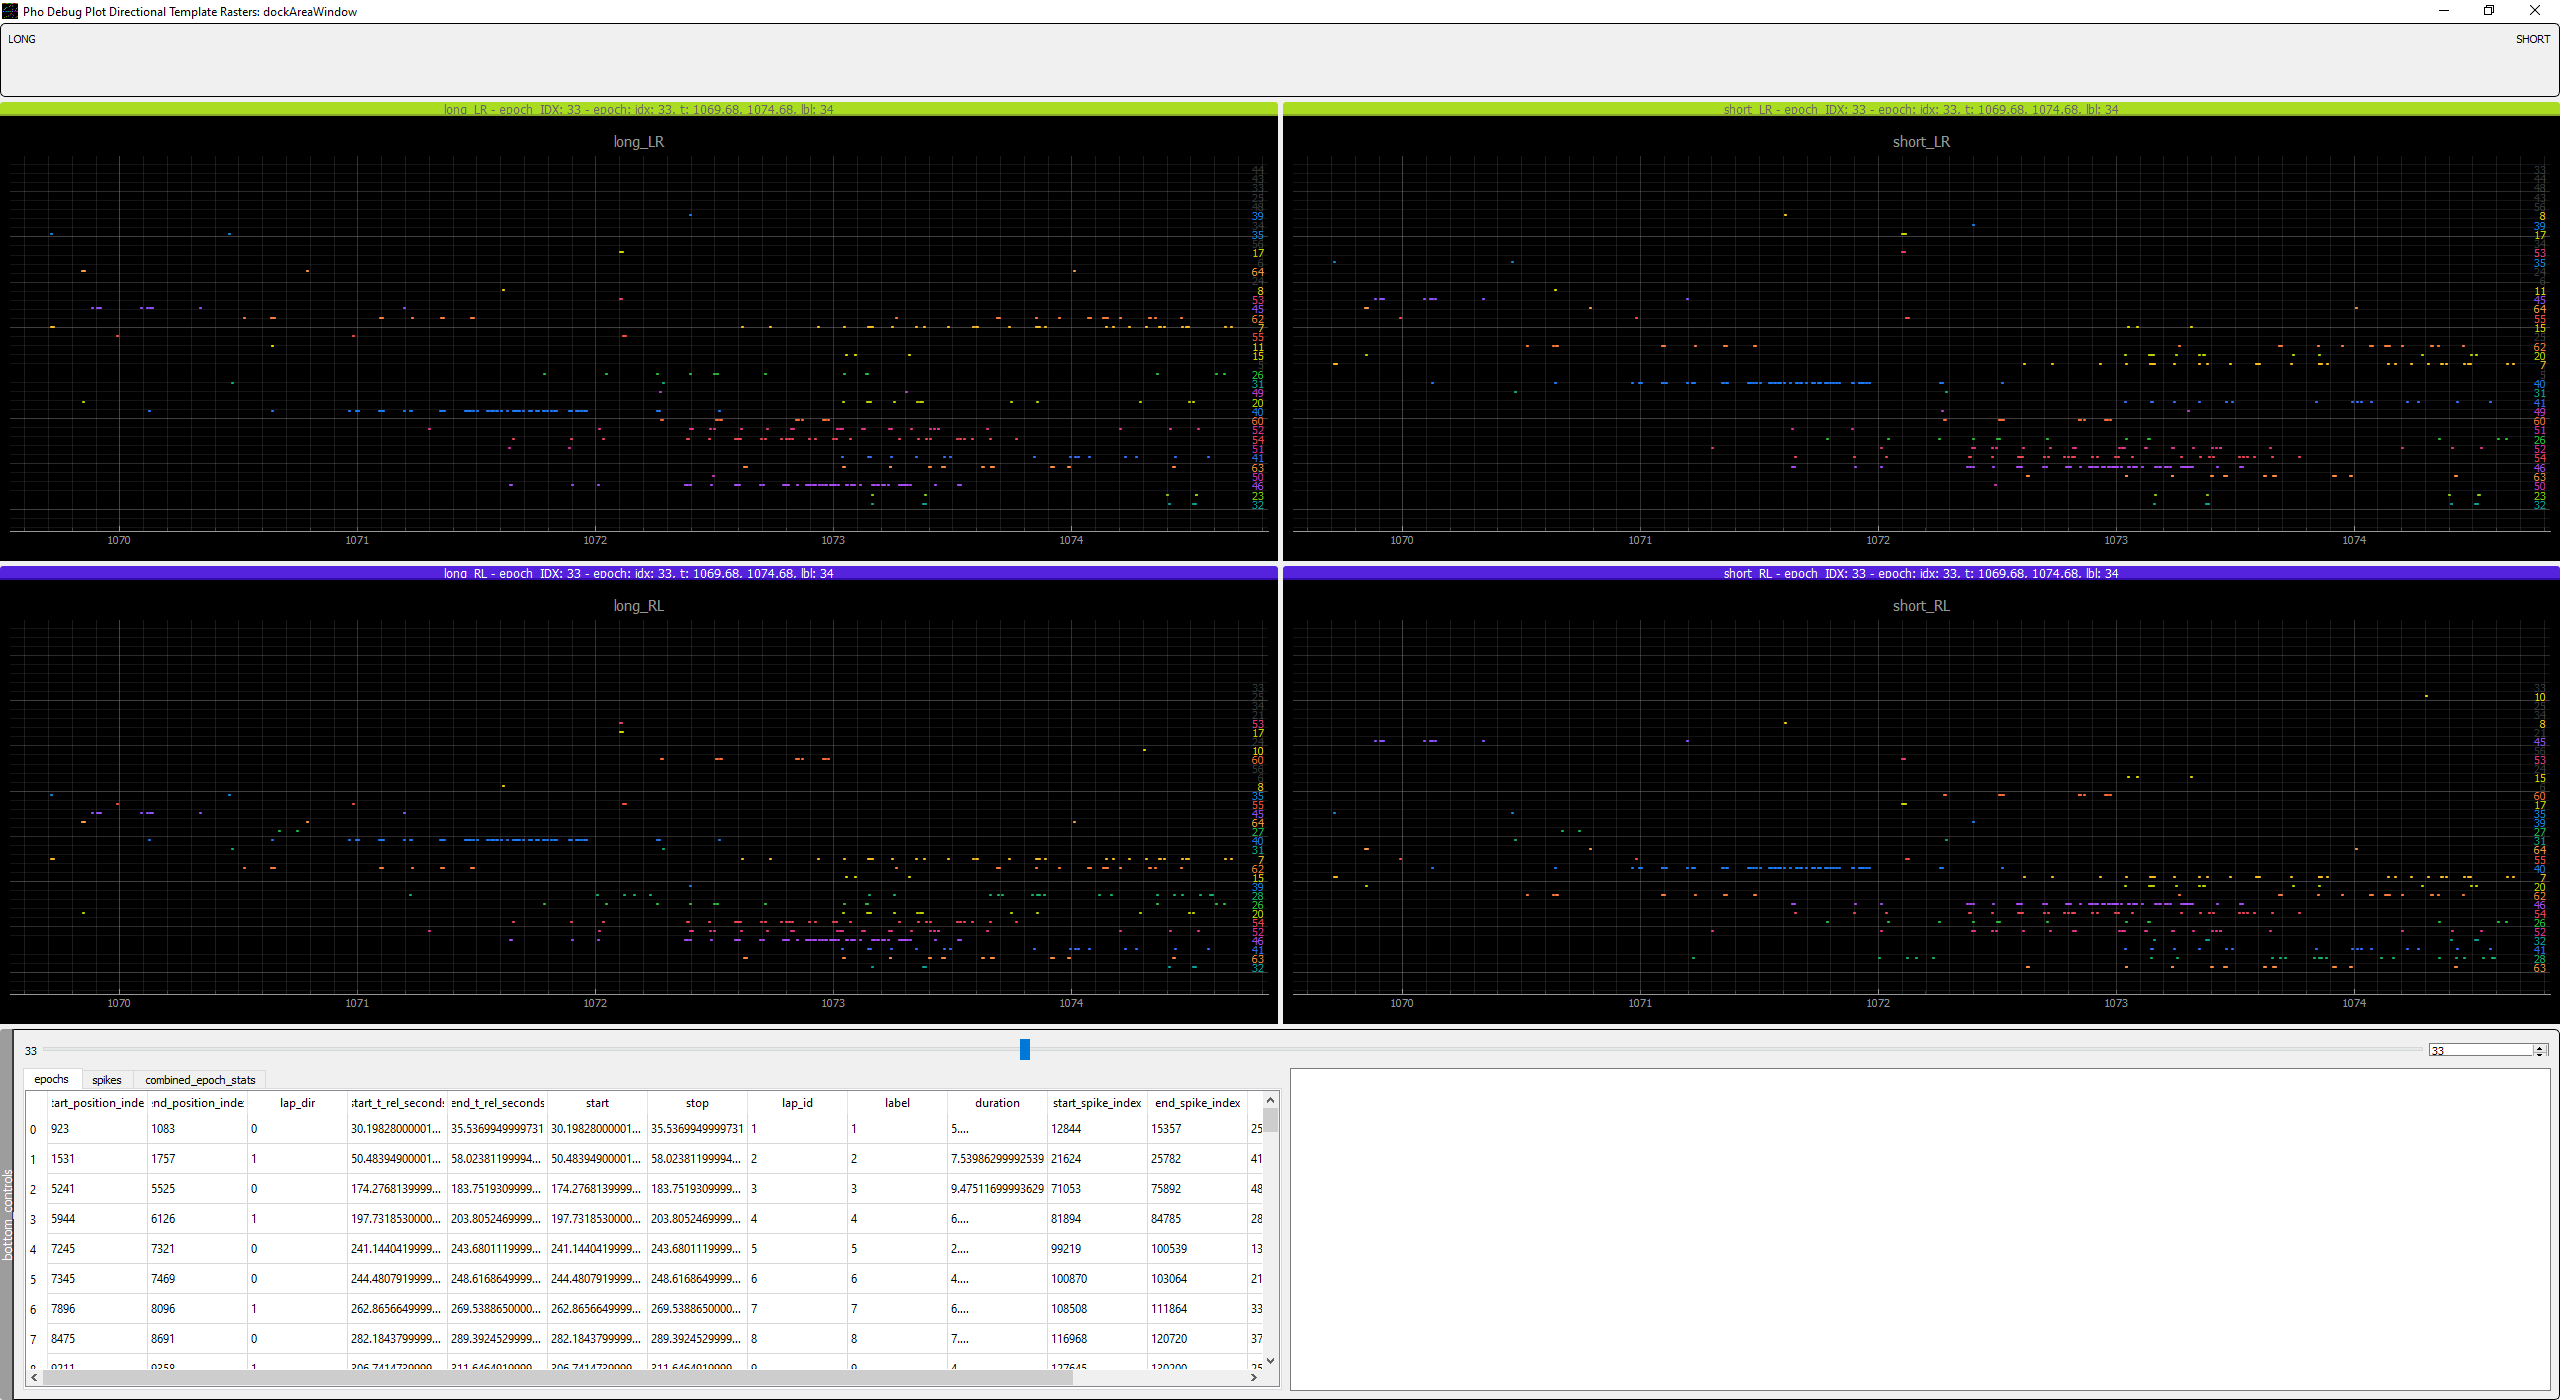 -->
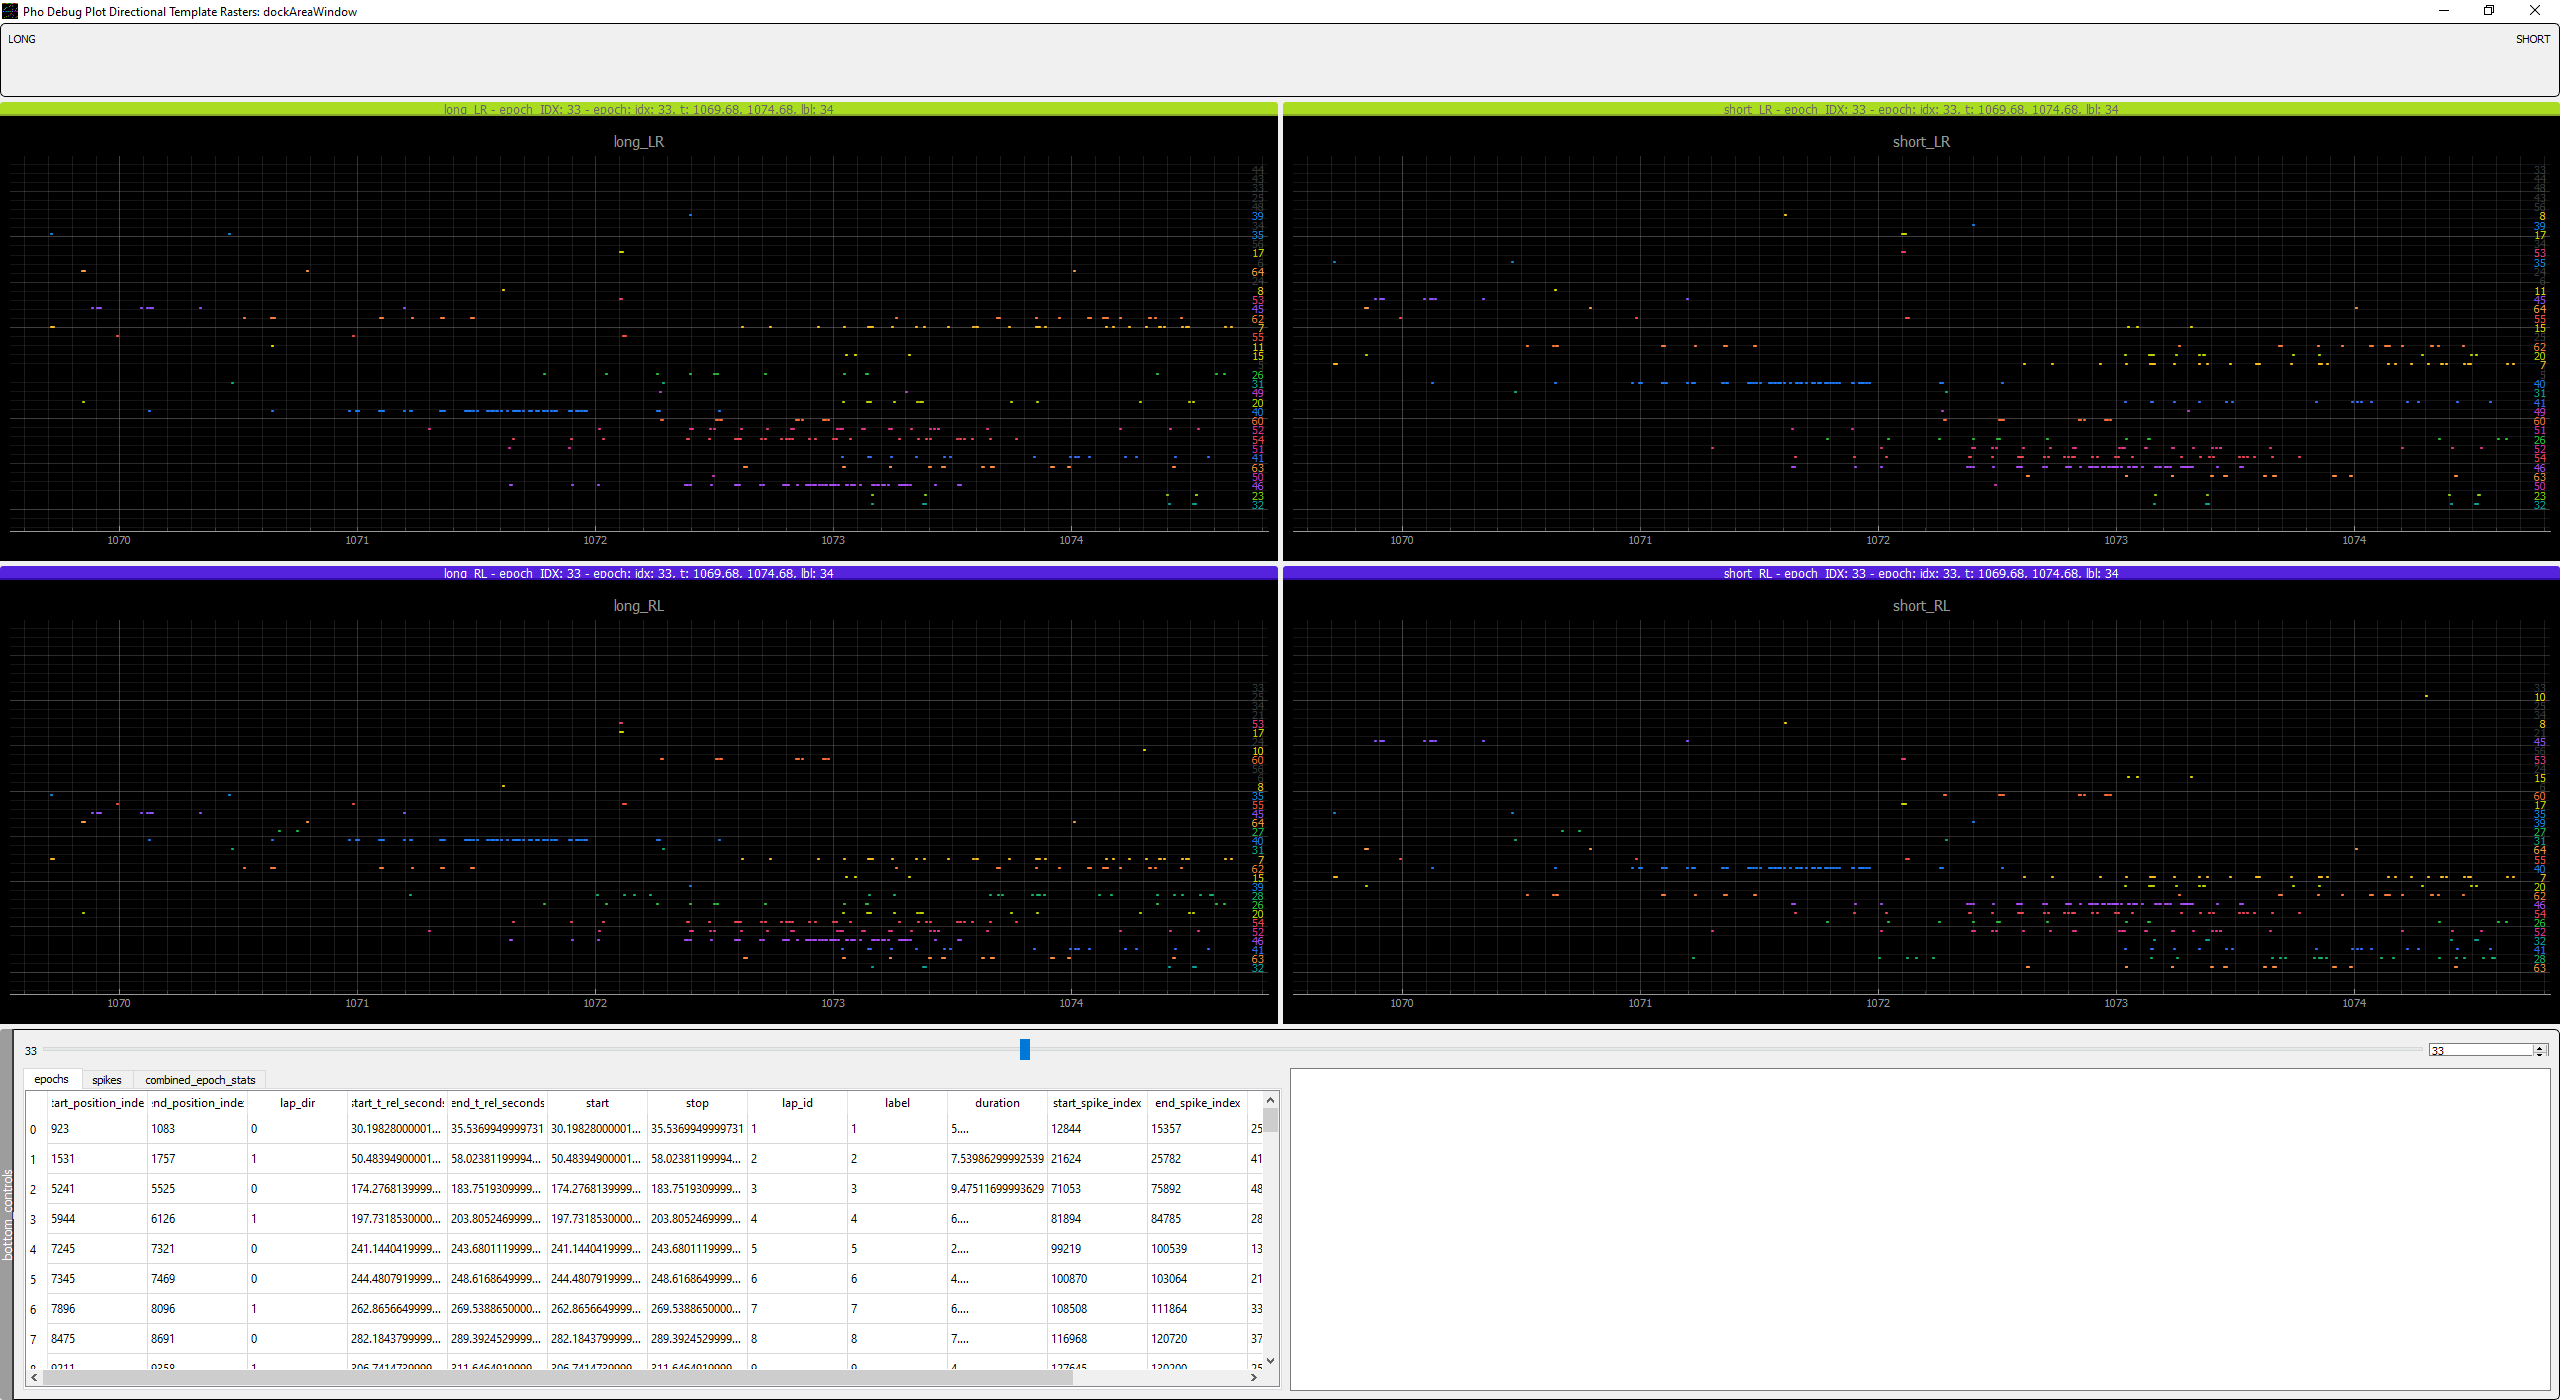{ width=300; max-width: 300px; }
<!-- <img src="path_to_your_image.png" style="max-width: 300px;" /> -->

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)

In [ ]:
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
global_laps_epochs_df = global_laps.to_dataframe()

RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
_out_laps_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, global_laps_epochs_df, track_templates, rank_order_results, RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_laps_rasters

In [ ]:
# long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
# global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
# global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
# global_laps_epochs_df = global_laps.to_dataframe()
global_ripple_epochs_df = global_replays.to_dataframe()

RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, global_ripple_epochs_df, track_templates, rank_order_results, RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_ripple_rasters

In [ ]:
RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
# rank_order_results
# used_rank_order_results = deepcopy(rank_order_results)
used_rank_order_results = None
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(filtered_ripple_simple_pf_pearson_merged_df),
                                                                                                   track_templates, used_rank_order_results,
                                                                                                    RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_ripple_rasters

In [ ]:

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(filtered_ripple_simple_pf_pearson_merged_df),
                                                                                                   track_templates, None,
                                                                                                    None, None,
                                                                                                    dock_add_locations = dict(zip(('long_LR', 'long_RL', 'short_LR', 'short_RL'), (['right'], ['right'], ['right'], ['right']))),
                                                                                                    )
_out_ripple_rasters.set_top_info_bar_visibility(False)


In [ ]:
_out_ripple_rasters.set_top_info_bar_visibility(False)

In [ ]:
# Hide top info bar:
LongShortColumnsInfo_dock_layout, LongShortColumnsInfo_dock_Dock = _out_ripple_rasters.plots.dock_widgets['LongShortColumnsInfo_dock']
# LongShortColumnsInfo_dock_layout.hide() # No use
# _out_ripple_rasters.ui.long_short_info_layout.hide() # No use
LongShortColumnsInfo_dock_Dock.hide()

In [ ]:
LongShortColumnsInfo_dock_Dock.hide()

In [ ]:
# found_IDX = _out_ripple_rasters.find_nearest_time_index(193.65)
# if found_IDX is not None:
#     print(f'found_IDX: {found_IDX}')
#     _out_ripple_rasters.programmatically_update_epoch_IDX(found_IDX)


_out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(193.65)



In [ ]:
_out_ripple_rasters.on_update_epoch_IDX(45)
# on_update_epoch_IDX


In [ ]:
_a_ScrollBarWithSpinBox = _out_ripple_rasters.ui.ctrls_widget # ScrollBarWithSpinBox 
_a_ScrollBarWithSpinBox.setValue(45)

In [ ]:
curr_active_pipeline.plot._display_directional_template_debugger()

In [ ]:
_out = curr_active_pipeline.display('_display_directional_template_debugger')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_track_template_pf1Ds')


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
_out = curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', global_epoch_context, variable_name='p_x_given_n')


In [ ]:
_out = curr_active_pipeline.display('_display_plot_most_likely_position_comparisons', global_epoch_context) # , variable_name='p_x_given_n'


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
'_display_directional_laps_overview'

In [ ]:
# '_display_directional_merged_pfs'
_out = curr_active_pipeline.display('_display_directional_merged_pfs', plot_all_directions=False, plot_long_directional=True, )

In [ ]:
'_display_1d_placefield_occupancy'
'_display_placemaps_pyqtplot_2D'
 '_display_2d_placefield_occupancy'

In [ ]:
_out = curr_active_pipeline.display('_display_2d_placefield_occupancy', global_any_name)

In [ ]:
_out = curr_active_pipeline.display('_display_grid_bin_bounds_validation')

In [ ]:
from neuropy.utils.matplotlib_helpers import add_rectangular_selector, add_range_selector


# epoch_name = global_any_name
epoch_name = short_epoch_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = computation_result.computation_config['pf_params'].grid_bin_bounds
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]
            
fig, ax = computation_result.computed_data.pf2D.plot_occupancy(identifier_details_list=[epoch_name], active_context=epoch_context) 

# rect_selector, set_extents, reset_extents = add_rectangular_selector(fig, ax, initial_selection=grid_bin_bounds) # (24.82, 257.88), (125.52, 149.19)

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import add_vertical_track_bounds_lines

grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_track_line_collection, short_track_line_collection = add_vertical_track_bounds_lines(grid_bin_bounds=grid_bin_bounds, ax=ax)

In [ ]:
from neuropy.utils.mixins.peak_location_representing import compute_placefield_center_of_mass_positions


epoch_name = global_any_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = deepcopy(computation_result.computation_config['pf_params'].grid_bin_bounds)
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]


In [ ]:
grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_pf2D.xbin
long_pf2D.ybin

In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)


In [ ]:
from scipy import ndimage # used for `compute_placefield_center_of_masses`
from neuropy.utils.mixins.peak_location_representing import compute_occupancy_center_of_mass_positions


In [ ]:
occupancy_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_x_center_dict # {'long_LR': 162.99271603199625, 'long_RL': 112.79866056603696, 'short_LR': 138.45611791646, 'short_RL': 130.78889937230684}

occupancy_mask_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.visited_occupancy_mask, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_mask_x_center_dict # {'long_LR': 135.66781520875904, 'long_RL': 130.0042755113645, 'short_LR': 133.77996864296085, 'short_RL': 143.21920147195175}


# {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}


In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)

# masked_nonzero_occupancy = deepcopy(long_pf2D.nan_never_visited_occupancy)

masked_nonzero_occupancy = deepcopy(long_pf2D.visited_occupancy_mask)

# occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin)
occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(masked_nonzero_occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin) # array([127.704, 145.63])
occupancy_CoM_positions


In [ ]:
occupancy

In [ ]:
long_pf2D.nan_never_visited_occupancy



In [ ]:
curr_active_pipeline.registered_display_function_docs_dict


'_display_grid_bin_bounds_validation'

In [ ]:
## Extracting on 2024-02-06 to display the LR/RL directions instead of the All/Long/Short pfs:
def _display_directional_merged_pfs(owning_pipeline_reference, global_computation_results, computation_results, active_configs, include_includelist=None, save_figure=True, included_any_context_neuron_ids=None,
									plot_all_directions=True, plot_long_directional=False, plot_short_directional=False, **kwargs):
	""" Plots the merged pseduo-2D pfs/ratemaps. Plots: All-Directions, Long-Directional, Short-Directional in seperate windows. 
	
	History: this is the Post 2022-10-22 display_all_pf_2D_pyqtgraph_binned_image_rendering-based method:
	"""
	from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, display_all_pf_2D_pyqtgraph_binned_image_rendering
	from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow 
	from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import LayoutScrollability

	defer_render = kwargs.pop('defer_render', False)
	directional_merged_decoders_result: DirectionalMergedDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
	active_merged_pf_plots_data_dict = {} #empty dict
	
	if plot_all_directions:
		active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='All-Directions', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.all_directional_pf1D_Decoder.pf # all-directions
	if plot_long_directional:
		active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Long-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.long_directional_pf1D_Decoder.pf # Long-only
	if plot_short_directional:
		active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Short-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.short_directional_pf1D_Decoder.pf # Short-only

	out_plots_dict = {}
	
	for active_context, active_pf_2D in active_merged_pf_plots_data_dict.items():
		# figure_format_config = {} # empty dict for config
		figure_format_config = {'scrollability_mode': LayoutScrollability.NON_SCROLLABLE} # kwargs # kwargs as default figure_format_config
		out_all_pf_2D_pyqtgraph_binned_image_fig: BasicBinnedImageRenderingWindow  = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config) # output is BasicBinnedImageRenderingWindow
	
		# Set the window title from the context
		out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_context.get_description()}')
		out_plots_dict[active_context] = out_all_pf_2D_pyqtgraph_binned_image_fig

		# Tries to update the display of the item:
		names_list = [v for v in list(out_all_pf_2D_pyqtgraph_binned_image_fig.plots.keys()) if v not in ('name', 'context')]
		for a_name in names_list:
			# Adjust the size of the text for the item by passing formatted text
			a_plot: pg.PlotItem = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[a_name].mainPlotItem # PlotItem 
			# no clue why 2 is a good value for this...
			a_plot.titleLabel.setMaximumHeight(2)
			a_plot.layout.setRowFixedHeight(0, 2)
			

		if not defer_render:
			out_all_pf_2D_pyqtgraph_binned_image_fig.show()

	return out_plots_dict

# 2023-12-18 - Simpily detect bimodal cells:

In [ ]:
from neuropy.utils.mixins.peak_location_representing import ContinuousPeakLocationRepresentingMixin
from neuropy.core.ratemap import Ratemap
from scipy.signal import find_peaks
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', sortby=None)

# active_ratemap = deepcopy(long_pf1D.ratemap)
active_ratemap: Ratemap = deepcopy(long_LR_pf1D.ratemap)
peaks_dict, aclu_n_peaks_dict, peaks_results_df = active_ratemap.compute_tuning_curve_modes(height=0.2, width=None)


included_columns = ['pos', 'peak_heights'] # the columns of interest that you want in the final dataframe.
included_columns_renamed = dict(zip(included_columns, ['peak', 'peak_height']))
decoder_peaks_results_dfs = [a_decoder.pf.ratemap.get_tuning_curve_peak_df(height=0.2, width=None) for a_decoder in (track_templates.long_LR_decoder, track_templates.long_RL_decoder, track_templates.short_LR_decoder, track_templates.short_RL_decoder)]
prefix_names = [f'{a_decoder_name}_' for a_decoder_name in track_templates.get_decoder_names()]
all_included_columns = ['aclu', 'series_idx', 'subpeak_idx'] + included_columns # Used to filter out the unwanted columns from the output

# [['aclu', 'series_idx', 'subpeak_idx', 'pos']]

# rename_list_fn = lambda a_prefix: {'pos': f"{a_prefix}pos"}
rename_list_fn = lambda a_prefix: {a_col_name:f"{a_prefix}{included_columns_renamed[a_col_name]}" for a_col_name in included_columns}

# column_names = [f'{a_decoder_name}_peak' for a_decoder_name in track_templates.get_decoder_names()]

# dataFrames = decoder_peaks_results_dfs
# names = self.get_decoder_names()

# rename 'pos' column in each dataframe and then reduce to perform cumulative outer merge
result_df = decoder_peaks_results_dfs[0][all_included_columns].rename(columns=rename_list_fn(prefix_names[0]))
for df, a_prefix in zip(decoder_peaks_results_dfs[1:], prefix_names[1:]):
    result_df = pd.merge(result_df, df[all_included_columns].rename(columns=rename_list_fn(a_prefix)), on=['aclu', 'series_idx', 'subpeak_idx'], how='outer')

# result = reorder_columns(result, column_name_desired_index_dict=dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4)))

## Move the "height" columns to the end
# list(filter(lambda column: column.endswith('_peak_heights'), result.columns))
# result_df = reorder_columns(result_df, column_name_desired_index_dict=dict(zip(list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), np.arange(len(result_df.columns)-4, len(result_df.columns)))))
# result_df

# print(list(result.columns))

## Move the "height" columns to the end
result_df: pd.DataFrame = reorder_columns_relative(result_df, column_names=list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), relative_mode='end').sort_values(['aclu', 'series_idx', 'subpeak_idx']).reset_index(drop=True)
result_df

In [ ]:
## Manually Excluded endcap aclus:
IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43')
excluded_endcap_aclus: NDArray = np.array(list(set([40, 60, 85, 102, 52, 6] + [83, 60, 52, 102, 40] + [59, 67, 95, 28, 101] + [14, 15, 87, 71] + [43, 84, 87, 19, 33, 51, 53])))
excluded_endcap_aclus


np.array([  6,  14,  15,  19,  28,  33,  40,  43,  51,  52,  53,  59,  60,  67,  71,  83,  84,  85,  87,  95, 101, 102])




In [ ]:
peaks_results_df = track_templates.get_decoders_aclu_peak_location_df().sort_values(['aclu', 'series_idx', 'subpeak_idx']).reset_index(drop=True) ## Does not seem to merge entries as I would expect via intution. It keeps LR/RL peaks distinct and leaves pd.NA values for the entries.
peaks_results_df

In [ ]:
aclu_n_peaks_dict: Dict = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index().set_index('aclu').to_dict()['subpeak_idx_count'] # number of peaks ("models" for each aclu)
aclu_n_peaks_dict

# peaks_results_df = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index()

# peaks_results_df[peaks_results_df.aclu == 5]
# peaks_results_df.aclu.value_counts()

In [ ]:
active_ratemap.n_neurons
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=active_ratemap.neuron_ids, sortby=np.arange(active_ratemap.n_neurons))

In [ ]:

aclu_n_peaks_dict
unimodal_only_aclus = np.array(list(unimodal_peaks_dict.keys()))
unimodal_only_aclus
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=unimodal_only_aclus, sortby=np.arange(active_ratemap.n_neurons))

# 🖼️🎨 2024-02-08 - `PhoPaginatedMultiDecoderDecodedEpochsWindow` - Plot Ripple Metrics like Radon Transforms, WCorr, Simple Pearson, etc.

In [28]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import RadonTransformPlotDataProvider
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

## INPUTS: decoder_ripple_filter_epochs_decoder_result_dict

# 2024-03-04 - Filter out the epochs based on the criteria:
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)

## filter the epochs by something and only show those:
# INPUTS: filtered_epochs_df
# filtered_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(active_epochs_df[['start', 'stop']].to_numpy())
## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered
# print(f"any_good_selected_epoch_times.shape: {any_good_selected_epoch_times.shape}") # (142, 2)

pre_cols = {a_name:set(a_result.filter_epochs.columns) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()}

# 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
filtered_decoder_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=filtered_decoder_filter_epochs_decoder_result_dict)

## 2024-03-08 - Also constrain the user-selected ones (just to try it):
decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
# ## Constrain again now by the user selections
filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(any_good_selected_epoch_times) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()}
# filtered_decoder_filter_epochs_decoder_result_dict

## Instead, add in the 'is_user_annotated_epoch' column instead of filtering
## INPUTS: any_good_selected_epoch_times
num_user_selected_times: int = len(any_good_selected_epoch_times)
print(f'num_user_selected_times: {num_user_selected_times}')
any_good_selected_epoch_indicies = None
print(f'adding user annotation column!')

directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)


## OUT: filtered_decoder_filter_epochs_decoder_result_dict

len(active_epochs_df): 718
min_num_unique_aclu_inclusions: 10
len(active_epochs_df): 520
num_user_selected_times: 142
adding user annotation column!
len(active_epochs_df): 718
min_num_unique_aclu_inclusions: 10
len(active_epochs_df): 520


In [29]:
filter_epochs = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
filter_epochs

np.sum(filter_epochs['pearsonr'].isna())


start         stop label  duration     score     velocity   intercept        speed     wcorr  P_decoder  pearsonr    travel  coverage      jump  sequential_correlation  monotonicity_score  laplacian_smoothness  longest_sequence_length  longest_sequence_length_ratio  direction_change_bin_ratio  congruent_dir_bins_ratio  total_congruent_direction_change  is_user_annotated_epoch  is_valid_epoch
3      66.661598    66.779040     5  0.117442  0.519962 -1060.274065   50.278967  1060.274065  0.651144   0.131296 -0.447410  0.346987  0.315789  0.003338            1.038397e+06        1.038397e+06          1.038397e+06                        1                       0.250000                    1.000000                  0.333333                        151.027725                     True            True
42    292.623671   292.808267    51  0.184596  0.474369   447.396214   -1.175544   447.396214  0.934755   0.509204 -0.214599  0.147029  0.315789  0.001919            4.425019e+05        4.425019e+05          4.425019e+05                        5                       0.714286                    0.166667                  0.833333                        188.784657                     True            True
43    304.440267   304.655644    54  0.215378  0.379341   901.690416  -70.947304   901.690416 -0.018511   0.280810 -0.516316  0.259610  0.333333  0.004423            2.088768e+06        2.088768e+06          2.088768e+06                        3                       0.375000                    0.428571                  0.285714                        211.438815                     True            True
51    380.745850   380.903966    62  0.158116  0.597235 -1175.821658  187.747073  1175.821658 -0.835414   0.152872  0.771485  0.317582  0.385965  0.003588            1.508840e+06        1.508840e+06          1.508840e+06                        2                       0.333333                    0.600000                  0.800000                        249.195747                     True            True
63    461.141462   461.289748    75  0.148285  0.586902 -1576.969853  178.594903  1576.969853 -0.929496   0.139911 -0.747768  0.189667  0.333333  0.002253            4.943932e+05        4.943932e+05          4.943932e+05                        3                       0.600000                    0.500000                  0.750000                        158.579112                     True            True
69    470.140267   470.317983    81  0.177715  0.478807  -339.050191  200.404351   339.050191 -0.813930   0.270942 -0.470560  0.114682  0.456140  0.002003            3.689416e+05        3.689416e+05          3.689416e+05                        3                       0.428571                    0.666667                  0.500000                        132.149260                     True            True
..           ...          ...   ...       ...       ...          ...         ...          ...       ...        ...       ...       ...       ...       ...                     ...                 ...                   ...                      ...                            ...                         ...                       ...                               ...                      ...             ...
682  2472.997994  2473.150427   711  0.152433  0.534287 -1041.895439  201.612760  1041.895439 -0.923210   0.382293 -0.082173  0.130561  0.263158  0.001502            2.651590e+05        2.651590e+05          2.651590e+05                        4                       0.666667                    0.400000                  0.800000                        135.924953                     True            True
686  2482.131905  2482.612550   715  0.480645  0.372969  -202.990006  212.225859   202.990006 -0.794838   0.319699  0.087070  0.100960  0.333333  0.003421            1.339480e+06        1.339480e+06          1.339480e+06                        5                       0.263158                    0.500000                  0.388889                        268

2

In [ ]:
# filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs.directionality_ratio.unique()
# filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs.sweep_score.unique()
# filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs.laplacian_smoothness.unique()

In [ ]:
## Build a merged (single df) frame
decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
filtered_epochs_df
filtered_epochs_df[filtered_epochs_df['start'] >= t_delta]
filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [30]:
# decoder_decoded_epochs_result_dict: generic

app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                # decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                decoder_decoded_epochs_result_dict=filtered_decoder_filter_epochs_decoder_result_dict,
                                                                                                epochs_name='ripple',
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'enable_per_epoch_action_buttons': False,
                                                                                                    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 
                                                                                                    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                    # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 10,
                                                                                                    'scrollable_figure': False,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': False,
                                                                                                })

paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)
_tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

target_height: 1030.0,   desired_final_height = 1030
target_height: 1030.0,   desired_final_height = 1030
target_height: 1030.0,   desired_final_height = 1030
target_height: 1030.0,   desired_final_height = 1030
PhoDockAreaContainingWindow.GlobalConnectionManagerAccessingMixin_on_setup()
PhoDockAreaContainingWindow.try_register_any_control_widgets()
	flat_widgets_list contains 0 items


In [ ]:
_tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times

In [ ]:
filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs


In [ ]:
## Get radon transform data:
a_pagination_controller = pagination_controller_dict['long_LR']
radon_transform_data = a_pagination_controller.plots_data['radon_transform_data']
radon_transform_data

In [ ]:
paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()


In [ ]:
# active_selections_dict = paginated_multi_decoder_decoded_epochs_window.save_selections()
# paginated_multi_decoder_decoded_epochs_window.ui.print = print
_annotations = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()


In [ ]:
pagination_controller_dict['long_LR'].params.xbin

In [ ]:
import mpldatacursor

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.params.xbin

In [ ]:
# Show crosshair at cursor position
plt.connect('motion_notify_event', lambda event: plt.gcf().gca().format_coord(event.xdata, event.ydata))

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _build_attached_raster_viewer

_out_ripple_rasters = _build_attached_raster_viewer(paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_ripple_simple_pf_pearson_merged_df)


In [ ]:
## Enable programmatically updating the rasters viewer to the clicked epoch index when middle clicking on a posterior.
def update_attached_raster_viewer_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ Enable programmatically updating the rasters viewer to the clicked epoch index when middle clicking on a posterior. 
    called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters
    """
    print(f'update_attached_raster_viewer_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'start_t: {start_t}')
            _out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(start_t)


for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}
    a_pagination_controller.params.on_middle_click_item_callbacks['update_attached_raster_viewer_epoch_callback'] = update_attached_raster_viewer_epoch_callback


In [ ]:
clicked_epoch_start_stop_time = [488.296 488.484]
start_t = 488.29642327222973
found_IDX = 24

# ripple_idx=80, ripple_start_t=488.29642327222973


In [ ]:
## Enable programmatically updating the rasters viewer to the clicked epoch index when middle clicking on a posterior.
def an_alt_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters
    """
    print(f'an_alt_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'start_t: {start_t}')
            _out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(start_t)


for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}    
    a_pagination_controller.params.on_middle_click_item_callbacks['an_alt_clicked_epoch_callback'] = an_alt_clicked_epoch_callback



In [ ]:
# Attempting to set identical low and high xlims makes transformation singular; automatically expanding. Is this what is causing the white posteriors?


In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].params.posterior_heatmap_imshow_kwargs = dict(vmin=0.0)


In [ ]:

# paginated_multi_decoder_decoded_epochs_window.update_params(posterior_heatmap_imshow_kwargs = dict(vmin=0.0))

paginated_multi_decoder_decoded_epochs_window.update_params(enable_per_epoch_action_buttons = True)
paginated_multi_decoder_decoded_epochs_window.refresh_current_page()


In [ ]:
paginated_multi_decoder_decoded_epochs_window.get_children_props('params')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('plots')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('plots.fig')
paginated_multi_decoder_decoded_epochs_window.get_children_props('plots.fig')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('params.posterior_heatmap_imshow_kwargs')

In [ ]:
# paginated_multi_decoder_decoded_epochs_window# AttributeError: 'PhoPaginatedMultiDecoderDecodedEpochsWindow' object has no attribute 'params'

paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].params.should_suppress_callback_exceptions = False 

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(3)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v._subfn_clear_selectability_rects()
    
# paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    a_ctrlr.perform_update_selections(defer_render=False)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [array([785.738, 785.923])]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [array([427.461, 427.557])]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [array([833.339, 833.451])]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [array([491.798, 492.178]), array([940.016, 940.219])]

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]

# with Ctx(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[208.356, 208.523], [693.842, 693.975], [954.574, 954.679]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[224.037, 224.312]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[145.776, 146.022], [198.220, 198.582], [220.041, 220.259], [511.570, 511.874], [865.238, 865.373]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[191.817, 192.100], [323.147, 323.297]]



In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-paginated_multi_decoder_decoded_epochs_window_page.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    paginated_multi_decoder_decoded_epochs_window.jump_to_page(2)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(1)

In [ ]:
decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
track_templates.get_decoder_names()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v.params.enable_radon_transform_info = True
    v.params.enable_weighted_correlation_info = True
    v.params.debug_enabled = True

paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    print(f'decoder[{k}]:')
    v.params.name
    # v.params.on_render_page_callbacks
    # v.params.enable_radon_transform_info
    len(v.plots_data.radon_transform_data)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.refresh_current_page()

In [ ]:
def _sub_subfn_wrapped_in_brackets(s: str, bracket_strings = ("[", "]")) -> str:
        return bracket_strings[0] + s + bracket_strings[1]
    
def _sub_subfn_format_nested_list(arr, precision:int=3, num_sep=", ", array_sep=', ') -> str:
    """
    Converts a nested list of floats into a single string,
    with each float formatted to the specified precision.
    
    arr = np.array([[491.798, 492.178], [940.016, 940.219]])
    _sub_subfn_format_nested_list(arr)

    >> '[[491.798, 492.178], [940.016, 940.219]]'

    arr = np.array([[785.738, 785.923]])
    _sub_subfn_format_nested_list(arr)
    >> '[[785.738, 785.923]]'
    """
    return _sub_subfn_wrapped_in_brackets(array_sep.join([_sub_subfn_wrapped_in_brackets(num_sep.join([f"{num:.{precision}f}" for num in row])) for row in arr]))
    
# arr = np.array([[491.798, 492.178], [940.016, 940.219]])
arr = np.array([[785.738, 785.923]])
_sub_subfn_format_nested_list(arr)

### 2024-02-29 3pm - Get the active user-annotated epoch times from the `paginated_multi_decoder_decoded_epochs_window` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [ ]:

# Inputs: paginated_multi_decoder_decoded_epochs_window, filtered_ripple_simple_pf_pearson_merged_df
any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))


## 🔶 2024-03-01 - Get the active user-annotated epoch times from the `UserAnnotationsManager` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [54]:
from neuropy.utils.misc import numpyify_array
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.epoch import EpochsAccessor
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
## Get from UserAnnotations directly instead of the intermediate viewer

## # inputs: any_good_selected_epoch_times, any_good_selected_epoch_times, any_good_selected_epoch_indicies 

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies
# Add user-selection columns to df
a_df = deepcopy(filtered_ripple_simple_pf_pearson_merged_df)
# a_df = deepcopy(ripple_weighted_corr_merged_df)
a_df['is_user_annotated_epoch'] = False
# any_good_selected_epoch_indicies = a_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, np.squeeze(any_good_selected_epoch_times[:,0]), t_column_names=['ripple_start_t',])
# any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, any_good_selected_epoch_times, t_column_names=['ripple_start_t',])
any_good_selected_epoch_indicies
# a_df['is_user_annotated_epoch'] = np.isin(a_df.index.to_numpy(), any_good_selected_epoch_indicies)
a_df['is_user_annotated_epoch'].loc[any_good_selected_epoch_indicies] = True # Here's another .iloc issue! Changing to .loc
a_df


array([  3,  42,  43,  51,  63,  69,  79,  80,  81,  91,  97, 106, 116, 120, 127, 128, 132, 133, 134, 142, 151, 153, 155, 158, 160, 162, 166, 169, 172, 180, 181, 198, 203, 210, 213, 217, 220, 226, 230, 231, 232, 236, 244, 249, 250, 265, 266, 268, 270, 287, 288, 291, 296, 297, 301, 306, 312, 314, 316, 324, 325, 334, 353, 355, 356, 360, 361, 363, 364, 365, 376, 381, 392, 396, 403, 405, 427, 444, 449, 463, 485, 486, 494, 511, 512, 513, 514, 518, 519, 524, 525, 528, 538, 542, 546, 555, 563, 573, 574, 575, 576, 578, 580, 581, 582, 585, 587, 588, 591, 595, 604, 605, 624, 625, 627, 629, 630, 631, 640, 642, 644, 646, 653, 658, 669, 670, 671, 672, 673, 674, 678, 681, 682, 686, 687, 693, 703, 704, 713, 714], dtype=int64)

P_LR      P_RL    P_Long   P_Short  ripple_idx  ripple_start_t  P_Long_LR  P_Long_RL  P_Short_LR  P_Short_RL  most_likely_decoder_index        start         stop label  duration  long_LR_pf_peak_x_pearsonr  long_RL_pf_peak_x_pearsonr  short_LR_pf_peak_x_pearsonr  short_RL_pf_peak_x_pearsonr  best_decoder_index  is_user_annotated_epoch
2    0.462816  0.537184  0.788716  0.211284           2       64.805681   0.365031   0.423685    0.097786    0.113498                          1    64.805681    64.968527     4  0.162847                   -0.270785                    0.094408                    -0.100028                     0.009850                   0                    False
3    0.155255  0.844745  0.845678  0.154322           3       66.661598   0.131296   0.714382    0.023959    0.130362                          1    66.661598    66.779040     5  0.117442                   -0.447410                   -0.617411                    -0.476514                    -0.557732                   1                     True
4    0.310276  0.689724  0.461241  0.538759           4       67.966460   0.143112   0.318129    0.167164    0.371595                          3    67.966460    68.108171     6  0.141711                   -0.128165                   -0.411812                    -0.164569                    -0.322785                   1                    False
5    0.502736  0.497264  0.546646  0.453354           5       68.571951   0.274819   0.271828    0.227917    0.225437                          0    68.571951    68.764442     7  0.192491                   -0.213763                   -0.611631                    -0.249967                    -0.479222                   1                    False
6    0.395808  0.604192  0.526735  0.473265           6       72.584687   0.208486   0.318249    0.187322    0.285943                          1    72.584687    72.929918     8  0.345231                   -0.027604                   -0.403977                    -0.145684                    -0.167733                   1                    False
7    0.435129  0.564871  0.686686  0.313314           7       84.137183   0.298797   0.387889    0.136332    0.176982                          1    84.137183    84.658256     9  0.521072                   -0.211425                   -0.023941                    -0.025315                     0.328618                   3                    False
..        ...       ...       ...       ...         ...             ...        ...        ...         ...         ...                        ...          ...          ...   ...       ...                         ...                         ...                          ...                          ...                 ...                      ...
712  0.433234  0.566766  0.541530  0.458470         712     2553.543550   0.234609   0.306921    0.198625    0.259845                          1  2553.543550  2553.857447   741  0.313897                   -0.375608                   -0.418968                    -0.134400                    -0.629940                   3                    False
713  0.652267  0.347733  0.430787  0.569213         713     2556.111956   0.280988   0.149799    0.371279    0.197934                          2  2556.111956  2556.382507   742  0.270551                   -0.366423                    0.250396                    -0.280667                     0.522894                   3                     True
714  0.517465  0.482535  0.481207  0.518793         714     2556.596748   0.249008   0.232199    0.268457    0.250336                          2  2556.596748  2556.918202   743  0.321454                    0.048601                    0.090544                    -0.014990                    -0.046084                   1                     True
715  0.555570  0.444430  0.502536  0.497464         715     2559.389348   0.279194   0.223342    0.276376    0.221088                          0  2559.389348  2559.530322   744  0.140974                 

In [55]:
df = DecoderDecodedEpochsResult.filter_epochs_dfs_by_annotation_times(curr_active_pipeline, any_good_selected_epoch_times, ripple_decoding_time_bin_size, filtered_ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df)
df

P_Long   P_Short  ripple_idx  ripple_start_t  P_Long_LR  P_Long_RL  P_Short_LR  P_Short_RL  most_likely_decoder_index        start         stop label  duration  long_best_pf_peak_x_pearsonr  short_best_pf_peak_x_pearsonr  long_best_wcorr  short_best_wcorr  wcorr_abs_diff  pearsonr_abs_diff        session_name  delta_aligned_start_t  time_bin_size  is_user_annotated_epoch
0    0.845678  0.154322           3       66.661598   0.131296   0.714382    0.023959    0.130362                          1    66.661598    66.779040     5  0.117442                     -0.447410                      -0.476514         0.651144          0.206095        0.445049          -0.029104  2006-6-07_16-40-19           -1169.604647          0.025                     True
1    0.801398  0.198602          42      292.623671   0.509204   0.292194    0.126191    0.072411                          0   292.623671   292.808267    51  0.184596                     -0.477705                      -0.473233         0.920027          0.921674       -0.001647           0.004473  2006-6-07_16-40-19            -943.642574          0.025                     True
2    0.568893  0.431107          43      304.440267   0.280810   0.288083    0.212798    0.218309                          1   304.440267   304.655644    54  0.215378                     -0.516316                      -0.579614        -0.018511         -0.029444       -0.010933          -0.063298  2006-6-07_16-40-19            -931.825979          0.025                     True
3    0.789038  0.210962          51      380.745850   0.152872   0.636167    0.040873    0.170089                          1   380.745850   380.903966    62  0.158116                      0.771485                       0.735246        -0.835414         -0.679909        0.155505           0.036240  2006-6-07_16-40-19            -855.520395          0.025                     True
4    0.832526  0.167474          63      461.141462   0.139911   0.692615    0.028145    0.139329                          1   461.141462   461.289748    75  0.148285                     -0.747768                      -0.756827        -0.929496         -0.922529        0.006967          -0.009059  2006-6-07_16-40-19            -775.124783          0.025                     True
5    0.556969  0.443031          69      470.140267   0.270942   0.286027    0.215516    0.227515                          1   470.140267   470.317983    81  0.177715                     -0.470560                      -0.299618        -0.813930         -0.422326        0.391604           0.170942  2006-6-07_16-40-19            -766.125978          0.025                     True
..        ...       ...         ...             ...        ...        ...         ...         ...                        ...          ...          ...   ...       ...                           ...                            ...              ...               ...             ...                ...                 ...                    ...            ...                      ...
134  0.403354  0.596646         687     2484.410898   0.142031   0.261323    0.210094    0.386552                          3  2484.410898  2484.484165   716  0.073267                     -0.095362                      -0.075437         0.086040          0.077091        0.008949           0.019925  2006-6-07_16-40-19            1248.144653          0.025                     True
135  0.473388  0.526612         693     2505.334986   0.102982   0.370406    0.114561    0.412051                          3  2505.334986  2505.671616   722  0.336630                      0.315460                       0.307569        -0.831314         -0.607541        0.223772           0.007891  2006-6-07_16-40-19            1269.068741          0.025                     True
136  0.573401  0.426599         703     2530.724715   0.308935   0.264466    0.229841    0.196758                          0  2530.724715  2530.920524   732  0.195809                     -0.579371 

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [56]:
min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# delta_aligned_start_t

P_Long   P_Short  ripple_idx  ripple_start_t  P_Long_LR  P_Long_RL  P_Short_LR  P_Short_RL  most_likely_decoder_index        start         stop label  duration  long_best_pf_peak_x_pearsonr  short_best_pf_peak_x_pearsonr  long_best_wcorr  short_best_wcorr  wcorr_abs_diff  pearsonr_abs_diff        session_name  delta_aligned_start_t  time_bin_size  is_user_annotated_epoch
0    0.845678  0.154322           3       66.661598   0.131296   0.714382    0.023959    0.130362                          1    66.661598    66.779040     5  0.117442                     -0.447410                      -0.476514         0.651144          0.206095        0.445049          -0.029104  2006-6-07_16-40-19           -1169.604647          0.025                     True
1    0.801398  0.198602          42      292.623671   0.509204   0.292194    0.126191    0.072411                          0   292.623671   292.808267    51  0.184596                     -0.477705                      -0.473233         0.920027          0.921674       -0.001647           0.004473  2006-6-07_16-40-19            -943.642574          0.025                     True
3    0.789038  0.210962          51      380.745850   0.152872   0.636167    0.040873    0.170089                          1   380.745850   380.903966    62  0.158116                      0.771485                       0.735246        -0.835414         -0.679909        0.155505           0.036240  2006-6-07_16-40-19            -855.520395          0.025                     True
4    0.832526  0.167474          63      461.141462   0.139911   0.692615    0.028145    0.139329                          1   461.141462   461.289748    75  0.148285                     -0.747768                      -0.756827        -0.929496         -0.922529        0.006967          -0.009059  2006-6-07_16-40-19            -775.124783          0.025                     True
5    0.556969  0.443031          69      470.140267   0.270942   0.286027    0.215516    0.227515                          1   470.140267   470.317983    81  0.177715                     -0.470560                      -0.299618        -0.813930         -0.422326        0.391604           0.170942  2006-6-07_16-40-19            -766.125978          0.025                     True
6    0.713843  0.286157          79      487.205157   0.208459   0.505384    0.083565    0.202593                          1   487.205157   487.450886    91  0.245729                     -0.816486                      -0.829071        -0.940860         -0.782118        0.158742          -0.012585  2006-6-07_16-40-19            -749.061088          0.025                     True
..        ...       ...         ...             ...        ...        ...         ...         ...                        ...          ...          ...   ...       ...                           ...                            ...              ...               ...             ...                ...                 ...                    ...            ...                      ...
132  0.430062  0.569938         682     2472.997994   0.382293   0.047769    0.506632    0.063306                          2  2472.997994  2473.150427   711  0.152433                      0.000924                       0.007814        -0.843038         -0.740786        0.102252          -0.006891  2006-6-07_16-40-19            1236.731749          0.025                     True
133  0.528395  0.471605         686     2482.131905   0.319699   0.208696    0.285339    0.186266                          0  2482.131905  2482.612550   715  0.480645                     -0.199338                      -0.187084        -0.720960         -0.566478        0.154482           0.012254  2006-6-07_16-40-19            1245.865660          0.025                     True
135  0.473388  0.526612         693     2505.334986   0.102982   0.370406    0.114561    0.412051                          3  2505.334986  2505.671616   722  0.336630                      0.315460 

In [ ]:
# Shifts the absolute times to delta-relative values, as would be needed to draw on a 'delta_aligned_start_t' axis:
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end = np.array([earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end]) - t_delta
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end

In [57]:
df['_wcorr_y_col'] = df['long_best_wcorr'].abs()
df['_wcorr_y_col_y_diff_col'] = df['long_best_wcorr'].abs() - df['short_best_wcorr'].abs()
# df.plot.scatter(x='ripple_start_t', y='wcorr_y_col')
df.plot.scatter(x='delta_aligned_start_t', y='_wcorr_y_col_y_diff_col')



<Axes: xlabel='delta_aligned_start_t', ylabel='_wcorr_y_col_y_diff_col'>

In [ ]:
# df['pearsonr_long_abs'] = df['long_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_short_abs'] = df['short_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_diff'] = df['long_best_pf_peak_x_pearsonr'].abs() - df['short_best_pf_peak_x_pearsonr'].abs()

# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_long_abs')
# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_short_abs')
df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_abs_diff')

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

### Add utility footer

In [58]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, get_utility_dock_colors
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget

ui = paginated_multi_decoder_decoded_epochs_window.ui._contents
# ui.dock_widgets
# ui.dock_configs


## Build the utility controls at the bottom:
ctrls_dock_config = CustomDockDisplayConfig(custom_get_colors_callback_fn=get_utility_dock_colors, showCloseButton=False)

button_bar_height = 21
ctrls_button_bar_widget = ThinButtonBarWidget()
ctrls_button_bar_widget.setObjectName("ctrls_button_bar")

ctrl_layout = pg.LayoutWidget()
ctrl_layout.addWidget(ctrls_button_bar_widget, row=1, rowspan=1, col=1, colspan=2)
ctrl_widgets_dict = dict(ctrls_widget=ctrls_button_bar_widget)
# ctrl_layout.setSizePolicy(

def onCopySelectionsClicked():
    print(f'onCopySelectionsClicked()')
    saved_selections_contexts_dict = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

ctrl_widgets_dict['copy_selection_connection'] = ctrls_button_bar_widget.sigCopySelections.connect(onCopySelectionsClicked)

ui.dock_widgets['bottom_controls'] = paginated_multi_decoder_decoded_epochs_window.add_display_dock(identifier='bottom_controls', widget=ctrl_layout, dockSize=(600, button_bar_height), dockAddLocationOpts=['bottom'], display_config=ctrls_dock_config)
ui.dock_widgets['bottom_controls'][1].hideTitleBar()
ui.dock_widgets['bottom_controls']

button_bar_height = 21

a_layout = ui.dock_widgets['bottom_controls'][0]
a_layout.size()
a_layout.setContentsMargins(0,0,0,0)
a_layout.setFixedHeight(21)
ui.dock_widgets['bottom_controls'][1].size()
ui.dock_widgets['bottom_controls'][1].setContentsMargins(0,0,0,0)
# ui.dock_widgets['bottom_controls'][1].hideTitleBar()
# ui.dock_widgets['bottom_controls'][1].size

(<pyphoplacecellanalysis.External.pyqtgraph.widgets.LayoutWidget.LayoutWidget object at 0x000001D54FFB8700>, <Dock bottom_controls (600, 21)>)

PyQt5.QtCore.QSize(640, 480)

PyQt5.QtCore.QSize(640, 39)

In [ ]:
setMargin

In [ ]:
ui.dock_widgets['bottom_controls'][0].resize(600, 21)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.find_display_dock('bottom_controls')

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_display_dock('bottom_controls')

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager

## Set epoch annotations from selections epochs 
annotations_man = UserAnnotationsManager()
user_annotations = annotations_man.get_user_annotations()
new_selections_dict = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(user_annotations)


In [ ]:
loaded_selections_objs_dict = {a_name:EpochSelectionsObject(epoch_times=a_selections_values) for a_name, a_selections_values in loaded_selections_dict.items()}
loaded_selections_objs_dict

## Select just the selected epoch times


In [ ]:
saved_selections_context_dict = {a_name:v.figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, v in saved_selections_dict.items()}

In [ ]:
user_annotations

In [ ]:
paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

In [ ]:
## Remove the excessively long plot titles?
# root_dockAreaWindow.update
pagination_controller_dict = paginated_multi_decoder_decoded_epochs_window.pagination_controllers
all_widgets = {a_decoder_name:a_pagination_controller.ui.mw for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_windows = {a_decoder_name:a_pagination_controller.ui.mw.window() for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots = {a_decoder_name:a_pagination_controller.plots for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots_data = {a_decoder_name:a_pagination_controller.plots_data for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_params = {a_decoder_name:a_pagination_controller.params for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx = {a_decoder_name:a_pagination_controller.current_page_idx for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx

In [ ]:
# all_separate_plots

all_separate_weighted_corr_plots = {a_decoder_name:a_pagination_controller.plots.get('weighted_corr', {}) for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_weighted_corr_plots

In [ ]:
self.ui.print = self.private_print # builtins.print # the print function to use

In [ ]:
from neuropy.core.epoch import EpochsAccessor

# MLM
# {a_name:a_ctrlr.params.is_selected for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}
# {a_name:a_ctrlr.selected_epoch_times for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}

any_good_selected_epoch_times: NDArray = paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times # drops duplicate rows (present in multiple decoders), and sorts them ascending
# any_good_selected_epoch_times
# Only at the decoder-level
any_good_epoch_idxs_list = [a_ctrlr.find_data_indicies_from_epoch_times(any_good_selected_epoch_times) for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items()]
any_good_epoch_idxs: NDArray = any_good_epoch_idxs_list[0]
any_good_epoch_idxs

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:

# filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)

found_data_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(epoch_times=any_good_selected_epoch_times)
df = filtered_ripple_simple_pf_pearson_merged_df.epochs._obj.iloc[found_data_indicies].copy().reset_index(drop=True)
df

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df


In [ ]:
hand_selected_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.iloc[any_good_epoch_idxs, :].reset_index(drop=True)
hand_selected_ripple_simple_pf_pearson_merged_df

In [ ]:
# hand_selected_ripple_simple_pf_pearson_merged_df['best_decoder_index']

is_most_likely_long = (hand_selected_ripple_simple_pf_pearson_merged_df['P_Long'] >= 0.5)
# is_most_likely_long

long_likely_hand_selected_ripple_simple_pf_pearson_merged_df = hand_selected_ripple_simple_pf_pearson_merged_df[is_most_likely_long]
long_likely_hand_selected_ripple_simple_pf_pearson_merged_df


## 🖼️🎨 Plot laps to compare between decoders:

In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe

# decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs # looks like 'lap_dir' column is wrong
updated_laps_dfs_dict = {}

## Update the .filter_epochs:
for k, v in decoder_laps_filter_epochs_decoder_result_dict.items():
    updated_laps_dfs_dict[k] = Epoch(add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=ensure_dataframe(v.filter_epochs)))
    decoder_laps_filter_epochs_decoder_result_dict[k].filter_epochs =  updated_laps_dfs_dict[k]

# updated_laps_dfs_dict['long_LR']
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs


In [ ]:
laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                                                                                           decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps', included_epoch_indicies=None, 
                                                                                                                                                    params_kwargs={'enable_per_epoch_action_buttons': False,
                                                                                                                                                    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': False, 
                                                                                                                                                    # 'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': False,
                                                                                                                                                    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                                                                    # 'disable_y_label': True,
                                                                                                                                                    # 'isPaginatorControlWidgetBackedMode': True,
                                                                                                                                                    # 'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                                                                    # 'debug_print': True,
                                                                                                                                                    'max_subplots_per_page': 10,
                                                                                                                                                    'scrollable_figure': True,
                                                                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                                                                    'use_AnchoredCustomText': False,
                                                                                                                                                })


In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe

## INPUTS: decoder_laps_filter_epochs_decoder_result_dict

## Highlight the correct ones:
# {k:Epoch(add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=ensure_dataframe(v.filter_epochs))) for k, v in decoder_laps_filter_epochs_decoder_result_dict.items()}

## Select the true laps by emulating user_annotations:
filter_epochs = ensure_dataframe(deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)) 
# filter_epochs

decoder_name_idx_map = {'long_LR': 0, 'long_RL': 1, 'short_LR': 2, 'short_RL': 3} 
selections_dict = {}
figure_ctx_dict = laps_paginated_multi_decoder_decoded_epochs_window.figure_ctx_dict
loaded_selections_context_dict = {a_name:a_figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, a_figure_ctx in figure_ctx_dict.items()}

for a_name, an_idx in decoder_name_idx_map.items():
    a_selections_context = loaded_selections_context_dict[a_name]
    selections_dict[a_selections_context] = filter_epochs[filter_epochs['true_decoder_index'] == an_idx][['start', 'stop']].to_numpy()


## Clearing the existing selection rects and them having them rebuilt when the selection is updated fixes them being shifted.
for k, v in laps_pagination_controller_dict.items():
    v._subfn_clear_selectability_rects()

_tmp_out_selections = laps_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(user_annotations=selections_dict)

In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)


In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.remove_data_overlays(defer_refresh=False)

In [ ]:
laps_pagination_controller_dict

In [ ]:
## Clearing the existing selection rects and them having them rebuilt when the selection is updated fixes them being shifted.
for k, v in laps_pagination_controller_dict.items():
    v._subfn_clear_selectability_rects()



In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict

In [ ]:
# list(decoder_laps_filter_epochs_decoder_result_dict.keys())
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
## Get the figure from the axes:
a_fig = ax.get_figure()
a_fig.canvas.draw()

In [ ]:
a_controlling_pagination_controller = laps_paginated_multi_decoder_decoded_epochs_window.contents.pagination_controllers['long_LR'] # DecodedEpochSlicesPaginatedFigureController
a_pagination_controller_figure_widget = paginator_controller_widget = a_controlling_pagination_controller.ui.mw # MatplotlibTimeSynchronizedWidget
paginator_controller_widget = a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget # PaginationControlWidget
# paginator_controller_widget
a_pagination_controller_figure_widget.draw()

In [ ]:
axs = a_controlling_pagination_controller.plots.axs

In [ ]:
ax.get_figure().canvas.draw()


In [ ]:
selection_rectangles_dict = a_controlling_pagination_controller.plots.get('selection_rectangles_dict', None)
selection_rectangles_dict


In [ ]:
# a_controlling_pagination_controller.plots.fig.canvas.draw_idle()
# a_controlling_pagination_controller.plots.fig.canvas.draw()
# paginator_controller_widget.update()
a_pagination_controller_figure_widget.draw()

In [ ]:
paginator_controller_widget.go_to_page(3)
# paginator_controller_widget.jump_to_page(3)

In [ ]:
a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget.jump_to_page

new_obj.plots_data.paginator
new_obj.params.active_identifying_figure_ctx
new_obj.on_paginator_control_widget_jump_to_page(page_idx=0)
new_obj.ui.connections['paginator_controller_widget_jump_to_page']


In [ ]:
for i, extant_plots in a_plots['weighted_corr'].items():
    extant_wcorr_text = extant_plots.get('wcorr_text', None)
    # extant_wcorr_text = extant_plots.pop('wcorr_text', None)
    print(f'extant_wcorr_text: {extant_wcorr_text}')
    # plot the radon transform line on the epoch:
    if (extant_wcorr_text is not None):
        # already exists, clear the existing ones. 
        # Let's assume we want to remove the 'Quadratic' line (line2)
        print(f'removing extant text object at index: {i}.')
        # extant_wcorr_text.remove()
        extant_wcorr_text.remove()

In [ ]:
for a_name, a_pagination_controller in pagination_controller_dict.items():
    display_context = a_pagination_controller.params.get('active_identifying_figure_ctx', IdentifyingContext())

    # Get context for current page of items:
    current_page_idx: int = int(a_pagination_controller.current_page_idx)
    a_paginator = a_pagination_controller.paginator
    total_num_pages = int(a_paginator.num_pages)
    page_context = display_context.overwriting_context(page=current_page_idx, num_pages=total_num_pages)
    print(page_context)

    ## Get the figure/axes:
    a_plots = a_pagination_controller.plots # RenderPlots
    a_plot_data = a_pagination_controller.plots_data

    a_params = a_pagination_controller.params
    a_params.skip_plotting_measured_positions

    figs = a_plots.fig
    axs = a_plots.axs

    # # with mpl.rc_context({'figure.figsize': (8.4, 4.8), 'figure.dpi': '220', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    # with mpl.rc_context({'figure.figsize': (16.8, 4.8), 'figure.dpi': '420', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    #     curr_active_pipeline.output_figure(final_context=page_context, fig=figs, write_vector_format=True)

## 💾 Export Paginated Content

In [ ]:
# laps_paginated_multi_decoder_decoded_epochs_window.export_all_pages(curr_active_pipeline)
paginated_multi_decoder_decoded_epochs_window.export_all_pages(curr_active_pipeline)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export_decoder_pagination_controller_figure_page(curr_active_pipeline)

## 🔷🎨 Single Decoder Version (`DecodedEpochSlicesPaginatedFigureController`)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import _subfn_update_decoded_epoch_slices
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController # `plot_decoded_epoch_slices_paginated`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import WeightedCorrelationPaginatedPlotDataProvider
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import DecodedPositionsPlotDataProvider, DecodedAndActualPositionsPlotData
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import perform_plot_1D_single_most_likely_position_curve

# Inputs: epochs_name, decoder_ripple_filter_epochs_decoder_result_dict, curr_active_pipeline
epochs_name = 'ripple'

(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[-1]

# a_decoder_decoded_epochs_result = decoder_ripple_filter_epochs_decoder_result_dict[a_name]

# a_decoder_decoded_epochs_result = decoder_ripple_filter_epochs_decoder_result_dict[a_name]
a_decoder_decoded_epochs_result = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict[a_name]) ## FILTERED

_out_pagination_controller = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(a_decoder_decoded_epochs_result.filter_epochs,
                                                                                    a_decoder_decoded_epochs_result,
                                                                                    xbin=a_decoder.xbin, global_pos_df=curr_active_pipeline.sess.position.df,
                                                                                    a_name=f'DecodedEpochSlices[{a_name}]', active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs=epochs_name, decoder=a_name),
                                                                                    max_subplots_per_page=8,
                                                                                    params_kwargs={'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 'enable_per_epoch_action_buttons': False,
                                                                                                    'enable_decoded_most_likely_position_curve': True, #'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                    'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 8,
                                                                                                    'scrollable_figure': True,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': True,
                                                                                                    'disable_toolbar': False,
                                                                                    }, 
                                                                                    # disable_toolbar=False
                                                                                    )

_out_pagination_controller.params.should_suppress_callback_exceptions = False
_out_pagination_controller.add_data_overlays(a_decoder_decoded_epochs_result)
_tmp_out_selections = _out_pagination_controller.restore_selections_from_user_annotations()

In [ ]:
fig = _out_pagination_controller.plots.fig
# fig.toolbar

In [ ]:
# type(_out_pagination_controller)

_out_pagination_controller.plot_widget._buildUI_setup_statusbar()

In [ ]:
ax = _out_pagination_controller.plots.axs[0]
ax

In [ ]:
ax.format_coord

In [ ]:


def format_coord(x, y):
    col = round(x)
    row = round(y)
    nrows, ncols = X.shape
    if 0 <= col < ncols and 0 <= row < nrows:
        z = X[row, col]
        return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}'
    else:
        return f'x={x:1.4f}, y={y:1.4f}'


ax.format_coord = format_coord


In [ ]:
# _out_pagination_controller.plot_widget.setStatusTip('LONG STATUS TIP TEST')

_out_pagination_controller.plot_widget.update_status('LONG STATUS TIP TEST')


In [ ]:
# _out_pagination_controller.plots.radon_transform
fig = _out_pagination_controller.plots.fig

# plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.1)
# Adjust the margins using subplots_adjust
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

# Adjust the margins using the Figure object
# fig.set_tight_layout(dict(rect=[0.1, 0.2, 0.8, 0.8]))
# fig.tight_layout(dict(rect=[0.1, 0.2, 0.8, 0.8]))
# fig.tight_layout(pad=1.0, rect=[0.1, 0.1, 0.8, 0.8])
_out_pagination_controller.draw()

In [ ]:
(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[0]
a_name

## 🔷🎨 2024-03-06 - Uni Page Scrollable Version

In [ ]:
# decoder_decoded_epochs_result_dict: generic
single_page_app, single_page_paginated_multi_decoder_decoded_epochs_window, single_page_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'skip_plotting_most_likely_positions': False, 'enable_per_epoch_action_buttons': False,
                                                                                                               'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                                # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                                # 'disable_y_label': True,
                                                                                                                'isPaginatorControlWidgetBackedMode': True,
                                                                                                                'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                                # 'debug_print': True,
                                                                                                                'max_subplots_per_page': 64,
                                                                                                                'scrollable_figure': True,
                                                                                                                })
single_page_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
_tmp_out_selections = single_page_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

In [ ]:
# for curr_results_obj: LeaveOneOutDecodingAnalysisResult object
num_filter_epochs:int = curr_results_obj.active_filter_epochs.n_epochs

# `active_filter_epochs_df` native columns approach
active_filter_epochs_df = curr_results_obj.active_filter_epochs.to_dataframe().copy()
assert np.isin(['score', 'velocity', 'intercept', 'speed'], active_filter_epochs_df.columns).all()
epochs_linear_fit_df = active_filter_epochs_df[['score', 'velocity', 'intercept', 'speed']].copy() # get the `epochs_linear_fit_df` as a subset of the filter epochs df
# epochs_linear_fit_df approach
assert curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs == np.shape(epochs_linear_fit_df)[0]

num_filter_epochs:int = curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs # curr_results_obj.num_filter_epochs
try:
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.time_bin_containers)
except AttributeError as e:
    # AttributeError: 'LeaveOneOutDecodingAnalysisResult' object has no attribute 'time_bin_containers' is expected when `curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting`
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.all_included_filter_epochs_decoder_result.time_bin_containers) # for curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting

radon_transform_data = RadonTransformPlotDataProvider._subfn_build_radon_transform_plotting_data(active_filter_epochs_df=active_filter_epochs_df,
            num_filter_epochs = num_filter_epochs, time_bin_containers = time_bin_containers, radon_transform_column_names=['score', 'velocity', 'intercept', 'speed'])
    

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export

In [ ]:
# _display_long_and_short_stacked_epoch_slices
curr_active_pipeline.reload_default_display_functions()
_out_dict = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', save_figure=True)

## Other:

In [ ]:
_out = _out_pagination_controller.plots['radon_transform'][7]
extant_line = _out['line'] # matplotlib.lines.Line2D
extant_line.linestyle = 'none'
# extant_line.draw()



In [ ]:
print(list(curr_active_pipeline.filtered_contexts.keys())) # ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Converting between decoder names and filtered epoch names:
# {'long':'maze1', 'short':'maze2'}
# {'LR':'odd', 'RL':'even'}
long_LR_name, short_LR_name, long_RL_name, short_RL_name = ['maze1_odd', 'maze2_odd', 'maze1_even', 'maze2_even']
decoder_name_to_session_context_name: Dict[str,str] = dict(zip(track_templates.get_decoder_names(), (long_LR_name, long_RL_name, short_LR_name, short_RL_name))) # {'long_LR': 'maze1_odd', 'long_RL': 'maze1_even', 'short_LR': 'maze2_odd', 'short_RL': 'maze2_even'}
session_context_to_decoder_name: Dict[str,str] = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), track_templates.get_decoder_names())) # {'maze1_odd': 'long_LR', 'maze1_even': 'long_RL', 'maze2_odd': 'short_LR', 'maze2_even': 'short_RL'}

decoder_name_to_session_context_name
session_context_to_decoder_name

In [ ]:
active_num_slices: int = _out_pagination_controller.params.active_num_slices
single_plot_fixed_height: float = _out_pagination_controller.params.single_plot_fixed_height
all_plots_height: float = _out_pagination_controller.params.all_plots_height
print(f'all_plots_height: {all_plots_height}')

In [ ]:
laps_weighted_corr_merged_df

In [ ]:
from PendingNotebookCode import _add_maze_id_to_epochs


## Add new weighted correlation results as new columns in existing filter_epochs df:
active_filter_epochs = long_results_obj.active_filter_epochs
# Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
active_filter_epochs = _add_maze_id_to_epochs(active_filter_epochs, short_session.t_start)
active_filter_epochs._df['weighted_corr_LONG'] = epoch_long_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_SHORT'] = epoch_short_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_spearman_LONG'] = epoch_long_weighted_corr_results[:,1]
active_filter_epochs._df['weighted_corr_spearman_SHORT'] = epoch_short_weighted_corr_results[:,1]


active_filter_epochs
active_filter_epochs.to_dataframe()
## plot the `weighted_corr_LONG` over time

# fig, axes = plt.subplots(ncols=1, nrows=active_num_rows, sharex=True, sharey=sharey, figsize=figsize)

## Weighted Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_LONG', title='weighted_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
## Weighted Spearman Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_LONG', title='weighted_spearman_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Spearman Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='score_LONG', title='Radon Transform Score during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='score_SHORT', xlabel='Replay Epoch Time', ylabel='Replay Radon Transform Score', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line


In [ ]:
curr_active_pipeline.reload_default_display_functions()
example_stacked_epoch_graphics = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', defer_render=False, save_figure=False)


# 2024-02-15 - Do simple spike-t vs. template pf peak correlation like Kamran suggested this morning

Replays can be of trajectories on either the current track configuration or on a temporally distant one (such as a trajectory on the long track after the track has been shortened). 
The goal of the decoder scoring methods are to evaluate how likely each decoder was. This means for each Epoch we obtain a score for all four decoders: Long_LR, Long_RL, Short_LR, Short_RL

#### `posterior decoder likelihoods` - This scoring method produces a probability that the

#### Radon Transform - TODO

#### `compute_simple_spike_time_v_pf_peak_x_by_epoch` - This epoch scoring metric plots the placefield peak x position against the time in seconds of each spike relative to the start of the epoch. 



## TODO 2024-02-15 8pm - Add in to previous result:

In [ ]:
# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
laps_simple_pf_pearson_merged_df
# laps_radon_transform_merged_df

In [ ]:
directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

decoder_aclu_peak_location_df_merged = deepcopy(track_templates.get_decoders_aclu_peak_location_df(width=None))
# decoder_aclu_peak_location_df_merged[np.isin(decoder_aclu_peak_location_df_merged['aclu'], both_included_neuron_stats_df.aclu.to_numpy())]
decoder_aclu_peak_location_df_merged


In [ ]:
a_result: TrialByTrialActivity = directional_active_lap_pf_results_dicts['long_LR']
# a_result.sp


# 🖼️🎨 2024-02-28 - WE gotta see the replays on the 3D track. Or the 2D track.

In [ ]:
## INPUTS: directional_laps_results, global_replays, decoder_ripple_filter_epochs_decoder_result_dict

# global_pf1D
# long_replays
# direction_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)
# track_identity_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)

## How do I get the replays?
# long_replay_df: pd.DataFrame = long_replays.to_dataframe() ## These work.
# global_replay_df: pd.DataFrame = global_replays.to_dataframe() ## These work.
# global_replay_df

In [ ]:
## 1D version:
## INPUTS: directional_laps_results, decoder_ripple_filter_epochs_decoder_result_dict
xbin = deepcopy(directional_laps_results.get_decoders()[0].xbin)
xbin_centers = deepcopy(directional_laps_results.get_decoders()[0].xbin_centers)
ybin_centers = None
ybin = None

a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict

## 1D:
a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR'] # 1D

## OUTPUTS: a_decoded_filter_epochs_decoder_result_dict, xbin_centers, ybin_centers

In [50]:
## 2D version:
from neuropy.analyses.placefields import PfND
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_lap_and_ripple_epochs_decoding_for_decoder

## INPUTS: long_results, short_results
# long_one_step_decoder_2D

long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
one_step_decoder_dict_2D: Dict[str, BayesianPlacemapPositionDecoder] = dict(zip(('long', 'short'), (long_one_step_decoder_2D, short_one_step_decoder_2D)))
long_pf2D = long_results.pf2D
# short_pf2D = short_results.pf2D

xbin = deepcopy(long_pf2D.xbin)
xbin_centers = deepcopy(long_pf2D.xbin_centers)
ybin = deepcopy(long_pf2D.ybin)
ybin_centers = deepcopy(long_pf2D.ybin_centers)

## OUTPUTS: one_step_decoder_dict_2D, xbin_centers, ybin_centers

## INPUTS: one_step_decoder_dict_2D

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalMergedDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
pos_bin_size: Tuple[float, float] = list(one_step_decoder_dict_2D.values())[0].pos_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')

## Decode epochs for the two decoders ('long', 'short'):
LS_decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {}
LS_decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {}

for a_name, a_decoder in one_step_decoder_dict_2D.items():
    LS_decoder_laps_filter_epochs_decoder_result_dict[a_name], LS_decoder_ripple_filter_epochs_decoder_result_dict[a_name] = _compute_lap_and_ripple_epochs_decoding_for_decoder(a_decoder, curr_active_pipeline, desired_laps_decoding_time_bin_size=laps_decoding_time_bin_size, desired_ripple_decoding_time_bin_size=ripple_decoding_time_bin_size)

# LS_decoder_ripple_filter_epochs_decoder_result_dict


laps_decoding_time_bin_size: 0.2, ripple_decoding_time_bin_size: 0.025, pos_bin_size: (3.775693131596347, 1.499839154784897)


C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\Analysis\Decoder\reconstruction.py:333: RuntimeWarning: invalid value encountered in divide
  posterior /= np.sum(posterior, axis=0) # C(tau, n) = np.sum(posterior, axis=0): normalization condition mentioned in eqn 36 to convert to P_x_given_n
C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\Analysis\Decoder\reconstruction.py:333: RuntimeWarning: invalid value encountered in divide
  posterior /= np.sum(posterior, axis=0) # C(tau, n) = np.sum(posterior, axis=0): normalization condition mentioned in eqn 36 to convert to P_x_given_n
C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\Analysis\Decoder\reconstruction.py:333: RuntimeWarning: invalid value encountered in divide
  posterior /= np.sum(posterior, axis=0) # C(tau, n) = np.sum(posterior, axis=0): normalization condition mentioned in eqn 36 to convert to P_x_given_n


In [51]:
## 2D:
# Choose the ripple epochs to plot:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(LS_decoder_ripple_filter_epochs_decoder_result_dict)
a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long'] # 2D
# Choose the laps epochs to plot:
# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(LS_decoder_laps_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict


# a_result: DecodedFilterEpochsResult = LS_decoder_laps_filter_epochs_decoder_result_dict['long'] # 2D

In [35]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryMatplotlibPlotter

## INPUTS: a_result: DecodedFilterEpochsResult, an_epoch_idx: int = 18
# e.g. `a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR']`

# a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR'] # 1D

## Convert to plottable posteriors
# an_epoch_idx: int = 0

# valid_aclus = deepcopy(decoder_aclu_peak_location_df_merged.aclu.unique())
num_filter_epochs: int = a_result.num_filter_epochs
a_decoded_traj_plotter = DecodedTrajectoryMatplotlibPlotter(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers)
fig, axs, laps_pages = a_decoded_traj_plotter.plot_decoded_trajectories_2d(global_session, curr_num_subplots=8, active_page_index=0, plot_actual_lap_lines=False, use_theoretical_tracks_instead=True)

integer_slider = a_decoded_traj_plotter.plot_epoch_with_slider_widget(an_epoch_idx=6)
integer_slider

IntSlider(value=0, description='time bin:', max=12)

In [ ]:
type(laps_pages)

In [ ]:
heatmaps[0].remove()

# an_ax.remove(heatmaps[0])

In [ ]:
an_ax = axs[0][0]

## add to 3D plotter:

In [71]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryPyVistaPlotter

## INPUTS: a_result, xbin_centers, ybin_centers, iplapsDataExplorer
# a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = DecodedTrajectoryPyVistaPlotter(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, p=iplapsDataExplorer.p)
# a_decoded_trajectory_pyvista_plotter.build_ui()
a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = iplapsDataExplorer.add_decoded_posterior_bars(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, enable_plot_all_time_bins_in_epoch_mode=True)

In [72]:
## Enable programmatically updating the rendered 3D posteriors in the viewer to the clicked epoch index when middle clicking on a posterior.
def an_alt_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: a_decoded_trajectory_pyvista_plotter
    """
    print(f'an_alt_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'clicked_data_index: {clicked_data_index}, start_t: {start_t}')
            # a_decoded_trajectory_pyvista_plotter.on_update_slider_epoch_idx(value=clicked_data_index)
            active_filter_epochs = a_decoded_trajectory_pyvista_plotter.a_result.active_filter_epochs
            found_epoch_idxs = active_filter_epochs.epochs.find_data_indicies_from_epoch_times(epoch_times=np.array([start_t]))
            assert len(found_epoch_idxs) > 0
            found_epoch_idx: int = int(found_epoch_idxs[0])
            print(f'\tfound_epoch_idx: {found_epoch_idx}')
            a_decoded_trajectory_pyvista_plotter.perform_programmatic_slider_epoch_update(value=found_epoch_idx)
			 #programmatically_update_epoch_IDX_from_epoch_start_time(start_t)


## INPUTS: paginated_multi_decoder_decoded_epochs_window
for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}    
    a_pagination_controller.params.on_middle_click_item_callbacks['an_alt_clicked_epoch_callback'] = an_alt_clicked_epoch_callback


In [67]:
active_filter_epochs = a_decoded_trajectory_pyvista_plotter.a_result.active_filter_epochs
active_filter_epochs.epochs.find_data_indicies_from_epoch_times(start_t)

found_epoch_idx = active_filter_epochs.epochs.find_data_indicies_from_epoch_times(epoch_times=np.array([start_t]))




NameError: name 'start_t' is not defined

In [ ]:
# a_posterior_p_x_given_n, n_epoch_timebins = a_decoded_trajectory_pyvista_plotter._perform_get_curr_posterior(a_result=a_result, an_epoch_idx=a_decoded_trajectory_pyvista_plotter.curr_epoch_idx, time_bin_index=np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins))
# np.shape(a_posterior_p_x_given_n)


a_posterior_p_x_given_n, n_epoch_timebins = a_decoded_trajectory_pyvista_plotter.get_curr_posterior(an_epoch_idx=a_decoded_trajectory_pyvista_plotter.curr_epoch_idx, time_bin_index=np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins))
np.shape(a_posterior_p_x_given_n)

n_epoch_timebins

In [70]:
iplapsDataExplorer.clear_all_added_decoded_posterior_plots(clear_ui_elements_also=True)

In [ ]:
a_result: DecodedFilterEpochsResult

In [ ]:
v = a_decoded_trajectory_pyvista_plotter.plotActors['plot_3d_binned_bars[49.11980797704307]']
# v['main'].remove()

a_decoded_trajectory_pyvista_plotter.p.remove_actor(v['main'])

In [41]:
from pyphoplacecellanalysis.Pho3D.PyVista.graphs import clear_3d_binned_bars_plots

clear_3d_binned_bars_plots(p=a_decoded_trajectory_pyvista_plotter.p, plotActors=a_decoded_trajectory_pyvista_plotter.plotActors)


In [ ]:
a_decoded_trajectory_pyvista_plotter.plotActors_CenterLabels

In [ ]:
a_decoded_trajectory_pyvista_plotter.perform_update_plot_epoch_time_bin_range(value=None) # select all

In [ ]:
time_bin_index = np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins)
type(time_bin_index)

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecoderRenderingPyVistaMixin

(plotActors, data_dict), (plotActors_CenterLabels, data_dict_CenterLabels) = DecoderRenderingPyVistaMixin.perform_plot_posterior_bars(iplapsDataExplorer.p, xbin=xbin, ybin=ybin, xbin_centers=xbin_centers, ybin_centers=ybin_centers,
                                               posterior_p_x_given_n=a_posterior_p_x_given_n)


In [ ]:
0.20720657697753883 * 24.130508176591324

# 💾 2024-03-04 - Export `DecoderDecodedEpochsResult` CSVs with user annotations for epochs:

In [36]:
from neuropy.core.epoch import ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

# 2024-03-04 - Filter out the epochs based on the criteria:
_, _, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_valid_epoch_times = filtered_epochs_df[['start', 'stop']].to_numpy()

## 2024-03-08 - Also constrain the user-selected ones (just to try it):
decoder_user_selected_epoch_times_dict, any_user_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)

a_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
# {a_name:ensure_dataframe(a_result.filter_epochs) for a_name, a_result in a_result_dict.items()}

directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=True)

# 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)

## Merge the heuristic columns into the wcorr df columns for exports
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df

# {a_name:DecoderDecodedEpochsResult.try_add_is_user_annotated_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=filtered_valid_epoch_times) for a_name, a_result in a_result_dict.items()}

for a_name, a_result in a_result_dict.items():
    # a_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=True)

    ## Merge the heuristic columns into the wcorr df columns for exports
    # directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    a_wcorr_result = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict[a_name]
    
    # did_update_user_annotation_col = DecoderDecodedEpochsResult.try_add_is_user_annotated_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=any_user_selected_epoch_times, t_column_names=None)
    # print(f'did_update_user_annotation_col: {did_update_user_annotation_col}')
    # did_update_is_valid = DecoderDecodedEpochsResult.try_add_is_valid_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=filtered_valid_epoch_times, t_column_names=None)
    # print(f'did_update_is_valid: {did_update_is_valid}')

# ['start',]

a_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)

# {a_name:ensure_dataframe(a_result.filter_epochs) for a_name, a_result in a_result_dict.items()}

len(active_epochs_df): 718
min_num_unique_aclu_inclusions: 10
len(active_epochs_df): 520
len(active_epochs_df): 718
min_num_unique_aclu_inclusions: 10
len(active_epochs_df): 520
did_update_user_annotation_col["long_LR"]: True
did_update_is_valid["long_LR"]: True
did_update_user_annotation_col["long_RL"]: True
did_update_is_valid["long_RL"]: True
did_update_user_annotation_col["short_LR"]: True
did_update_is_valid["short_LR"]: True
did_update_user_annotation_col["short_RL"]: True
did_update_is_valid["short_RL"]: True
	done.


P_LR      P_RL    P_Long   P_Short  ripple_idx  ripple_start_t  P_Long_LR  P_Long_RL  P_Short_LR  P_Short_RL  most_likely_decoder_index  wcorr_long_LR  wcorr_long_RL  wcorr_short_LR  wcorr_short_RL  best_decoder_index        session_name  time_bin_size  delta_aligned_start_t  is_user_annotated_epoch  is_valid_epoch
0    0.457713  0.542287  0.669093  0.330907           0       49.107308   0.306253   0.362840    0.151461    0.179447                          1      -0.315734      -0.057437       -0.148609        0.076203                   0  2006-6-07_16-40-19          0.025           -1187.158937                    False            True
1    0.879821  0.120179  0.845130  0.154870           1       64.083055   0.743563   0.101567    0.136258    0.018612                          0      -0.233270      -0.194691       -0.419966       -0.244981                   2  2006-6-07_16-40-19          0.025           -1172.183191                    False            True
2    0.462816  0.537184  0.788716  0.211284           2       64.805681   0.365031   0.423685    0.097786    0.113498                          1      -0.385563      -0.426950       -0.353071        0.065000                   1  2006-6-07_16-40-19          0.025           -1171.460565                    False            True
3    0.155255  0.844745  0.845678  0.154322           3       66.661598   0.131296   0.714382    0.023959    0.130362                          1       0.651144      -0.743213        0.206095       -0.778446                   3  2006-6-07_16-40-19          0.025           -1169.604647                     True            True
4    0.310276  0.689724  0.461241  0.538759           4       67.966460   0.143112   0.318129    0.167164    0.371595                          3       0.681977      -0.690614       -0.252057       -0.697207                   3  2006-6-07_16-40-19          0.025           -1168.299785                    False            True
5    0.502736  0.497264  0.546646  0.453354           5       68.571951   0.274819   0.271828    0.227917    0.225437                          0       0.331783       0.187989        0.170269        0.212316                   0  2006-6-07_16-40-19          0.025           -1167.694295                    False           False
..        ...       ...       ...       ...         ...             ...        ...        ...         ...         ...                        ...            ...            ...             ...             ...                 ...                 ...            ...                    ...                      ...             ...
712  0.433234  0.566766  0.541530  0.458470         712     2553.543550   0.234609   0.306921    0.198625    0.259845                          1      -0.400950      -0.095714       -0.105353        0.200355                   0  2006-6-07_16-40-19          0.025            1317.277305                    False            True
713  0.652267  0.347733  0.430787  0.569213         713     2556.111956   0.280988   0.149799    0.371279    0.197934                          2      -0.798783      -0.821603       -0.677070       -0.622312                   1  2006-6-07_16-40-19          0.025            1319.845711                     True            True
714  0.517465  0.482535  0.481207  0.518793         714     2556.596748   0.249008   0.232199    0.268457    0.250336                          2      -0.163475      -0.147639       -0.221197       -0.108992                   2  2006-6-07_16-40-19          0.025            1320.330503                     True            True
715  0.555570  0.444430  0.502536  0.497464         715     2559.389348   0.279194   0.223342    0.276376    0.221088                          0      -0.373342      -0.134758       -0.377455       -0.116220                   2  2006-6-07_16-40-19          0.025            1323.123103                    False            True
716  0.463952  0.536048  0.626755  0.373245         716     2585.469325   0.290784   0.335971    

In [37]:
_out_new_scores 

{'long_LR':      longest_sequence_length  longest_sequence_length_ratio  direction_change_bin_ratio  congruent_dir_bins_ratio  total_congruent_direction_change
 0                          3                       0.428571                    0.666667                  0.666667                        411.550551
 1                          1                       0.250000                    1.000000                  0.666667                        177.457577
 2                          2                       0.333333                    0.600000                  0.600000                        366.242234
 3                          1                       0.250000                    1.000000                  0.333333                        151.027725
 4                          2                       0.400000                    0.750000                  0.500000                        192.560350
 5                          3                       0.428571                    0.500000       

In [38]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pathlib import Path

# 💾 export_csvs

BATCH_DATE_TO_USE: str = '2024-04-24_APOGEE' # TODO: Change this as needed, templating isn't actually doing anything rn.

known_collected_outputs_paths = [Path(v).resolve() for v in ('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs', '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', '/home/halechr/cloud/turbo/Data/Output/collected_outputs', '/home/halechr/FastData/gen_scripts/', '/home/halechr/FastData/collected_outputs/', 'output/gen_scripts/')]
collected_outputs_path = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: '{collected_outputs_path}' does not exist! Is the right computer's config commented out above?"
print(f'collected_outputs_path: "{collected_outputs_path}"')
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
print(f'\tComputation complete. Exporting .CSVs...')

# 2024-03-04 - Filter out the epochs based on the criteria:
_, _, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_valid_epoch_times = filtered_epochs_df[['start', 'stop']].to_numpy()

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                              user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                              valid_epochs_selections={'ripple': filtered_valid_epoch_times})

print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _output_csv_paths.items()])
# print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')

# {'laps_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'ripple_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'laps_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_simple_pf_pearson_merged_df)_tbin-0.025.csv'),
#  'ripple_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_simple_pf_pearson_merged_df)_tbin-0.025.csv')}


collected_outputs_path: "C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs"
CURR_BATCH_OUTPUT_PREFIX: 2024-04-24_APOGEE-2006-6-07_16-40-19
	Computation complete. Exporting .CSVs...
len(active_epochs_df): 718
min_num_unique_aclu_inclusions: 10
len(active_epochs_df): 520
num_user_selected_times: 142
adding user annotation column!
	 succeded at getting 142 selected indicies (of 142 user selections) for ripple_weighted_corr_merged_df. got 142 indicies!
num_valid_epoch_times: 520
adding valid filtered epochs column!
	 succeded at getting 520 selected indicies (of 520 valid filter epoch times) for ripple_weighted_corr_merged_df. got 520 indicies!
num_user_selected_times: 142
adding user annotation column!
	 succeded at getting 142 selected indicies (of 142 user selections) for ripple_simple_pf_pearson_merged_df. got 142 indicies!
num_valid_epoch_times: 520
adding valid filtered epochs column!
	 succeded at getting 520 selected indicies (of 520 valid filter epoch times) for r

In [ ]:
any_good_selected_epoch_times

# 2024-03-04 - Filter out the epochs based on the criteria:

In [ ]:
# from neuropy.utils.mixins.time_slicing import add_epochs_id_identity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes

# 2024-03-04 - Filter out the epochs based on the criteria:
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, required_min_percentage_of_active_cells=0.333333, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_epochs_df

# 2024-03-27 - Look at active set cells

In [ ]:
track_templates

In [ ]:
from neuropy.utils.mixins.HDF5_representable import HDFConvertableEnum
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import TruncationCheckingResults


## long_short_endcap_analysis:
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap

truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
truncation_checking_aclus_dict, jonathan_firing_rate_analysis_result.neuron_replay_stats_df = truncation_checking_result.build_truncation_checking_aclus_dict(neuron_replay_stats_df=jonathan_firing_rate_analysis_result.neuron_replay_stats_df)

frs_index_inclusion_magnitude:float = 0.5

jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())

## Unrefined:
# neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)

## Refine the LxC/SxC designators using the firing rate index metric:

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']
jonathan_firing_rate_analysis_result.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)

neuron_replay_stats_df, *exclusivity_tuple = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)
# short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = exclusivity_tuple
exclusivity_aclus_tuple = [v.track_exclusive_aclus for v in exclusivity_tuple]
exclusivity_aclus_dict = dict(zip(['short_exclusive', 'long_exclusive', 'BOTH', 'EITHER', 'XOR', 'NEITHER'], exclusivity_aclus_tuple))
any_aclus = union_of_arrays(*exclusivity_aclus_tuple)
exclusivity_aclus_dict['any'] = any_aclus
refined_exclusivity_aclus_tuple = [v.get_refined_track_exclusive_aclus() for v in exclusivity_tuple]
neuron_replay_stats_df: pd.DataFrame = HDFConvertableEnum.convert_dataframe_columns_for_hdf(neuron_replay_stats_df)

# These keys exhaustively span all aclus:
exhaustive_key_names = ['short_exclusive', 'long_exclusive', 'BOTH', 'NEITHER']
assert np.all(any_aclus == union_of_arrays(*[exclusivity_aclus_dict[k] for k in exhaustive_key_names]))
exhaustive_key_dict = {k:v for k, v in exclusivity_aclus_dict.items() if k in exhaustive_key_names}


neuron_replay_stats_df

In [ ]:
old_any_aclus = np.array([  3,   4,   5,   7,  10,  11,  13,  14,  15,  17,  23,  24,  25,  26,  31,  32,  33,  34,  45,  49,  50,  51,  52,  54,  55,  58,  61,  64,  68,  69,  70,  71,  73,  74,  75,  76,  78,  81,  82,  83,  84,  85,  87,  90,  92,  93,  96,  97, 102, 109])
old_appearing_aclus = np.array([ 4, 11, 13, 23, 52, 58, 87])

In [ ]:
any_aclus = union_of_arrays(*[v for v in truncation_checking_aclus_dict.values() if len(v) > 0])
any_aclus


In [ ]:
neuron_replay_stats_df

In [ ]:
from neuropy.core.ratemap import Ratemap
from neuropy.analyses.placefields import PfND
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import perform_sweep_lap_groud_truth_performance_testing, _perform_variable_time_bin_lap_groud_truth_performance_testing

desired_laps_decoding_time_bin_size: float = 0.75

## INPUTS: exclusivity_aclus_tuple, desired_laps_decoding_time_bin_size: float
# short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = exclusivity_aclus_tuple
# included_neuron_ids_list = [short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset]

# included_neuron_ids_list = [*exclusivity_aclus_tuple]

## INPUTS: truncation_checking_aclus_dict
included_neuron_ids_list = list(truncation_checking_aclus_dict.values())
row_names = list(truncation_checking_aclus_dict.keys())

_output_tuples_list = perform_sweep_lap_groud_truth_performance_testing(curr_active_pipeline, 
                                                                        included_neuron_ids_list=included_neuron_ids_list,
                                                                        desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size)

percent_laps_correctness_df: pd.DataFrame = pd.DataFrame.from_records([complete_decoded_context_correctness_tuple.percent_correct_tuple for (a_directional_merged_decoders_result, result_laps_epochs_df, complete_decoded_context_correctness_tuple) in _output_tuples_list],
                          columns=("track_ID_correct", "dir_correct", "complete_correct"), index=row_names)
percent_laps_correctness_df


# 2024-03-29 - Rigorous Decoder Performance assessment
Quantify cell contributions to decoders

In [26]:
# Inputs: all_directional_pf1D_Decoder, alt_directional_merged_decoders_result
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestLapsSplitting, CustomDecodeEpochsResult, decoder_name, epoch_split_key, get_proper_global_spikes_df

## INPUTS: directional_laps_results, track_templates, directional_laps_results

## Split the lap epochs into training and test periods.
##### Ideally we could test the lap decoding error by sampling randomly from the time bins and omitting 1/6 of time bins from the placefield building (effectively the training data). These missing bins will be used as the "test data" and the decoding error will be computed by decoding them and subtracting the actual measured position during these bins.

# ### Get the laps to train on
# training_data_portion: float = 9.0/10.0
# test_data_portion: float = 1.0 - training_data_portion # test data portion is 1/6 of the total duration
# print(f'training_data_portion: {training_data_portion}, test_data_portion: {test_data_portion}')

# decoders_dict = deepcopy(track_templates.get_decoders_dict())

# # debug_output_hdf5_file_path = Path('output', 'laps_train_test_split.h5').resolve()
# debug_output_hdf5_file_path = None

# # (train_epochs_dict, test_epochs_dict), train_lap_specific_pf1D_Decoder_dict, split_train_test_lap_specific_configs = TrainTestLapsSplitting.compute_train_test_split_laps_decoders(directional_laps_results, track_templates, training_data_portion=training_data_portion,
# #                                                                                                                                                              debug_output_hdf5_file_path=debug_output_hdf5_file_path, debug_plot=False, debug_print=True)  # type: Tuple[Tuple[Dict[str, Any], Dict[str, Any]], Dict[str, BasePositionDecoder], Any]

# train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = train_lap_specific_pf1D_Decoder_dict


from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestSplitResult

directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)

training_data_portion: float = directional_train_test_split_result.training_data_portion
test_data_portion: float = directional_train_test_split_result.test_data_portion
print(f'training_data_portion: {training_data_portion}, test_data_portion: {test_data_portion}')

test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict


# Tuple[Tuple[Dict, Dict], Dict[str, BasePositionDecoder], Dict]

# OUTPUTS: train_test_split_laps_df_dict

# ## Get test epochs:
# train_epoch_names: List[str] = [k for k in train_test_split_laps_df_dict.keys() if k.endswith('_train')]
# test_epoch_names: List[str] = [k for k in train_test_split_laps_df_dict.keys() if k.endswith('_test')]
# train_lap_specific_pf1D_Decoder_dict: Dict[str,BasePositionDecoder] = {k.split('_train', maxsplit=1)[0]:split_train_test_lap_specific_pf1D_Decoder_dict[k] for k in train_epoch_names} # the `k.split('_train', maxsplit=1)[0]` part just gets the original key like 'long_LR'
# test_epochs_dict: Dict[str,Epoch] = {k.split('_test', maxsplit=1)[0]:v for k,v in train_test_split_laps_epoch_obj_dict.items() if k.endswith('_test')} # the `k.split('_test', maxsplit=1)[0]` part just gets the original key like 'long_LR'

# a_training_test_split_laps_epoch_obj_dict[a_training_test_names[0]].to_hdf('output/laps_train_test_split.h5', f'{a_train_epoch_name}/laps_training_df')


training_data_portion: 0.8333333333333334, test_data_portion: 0.16666666666666663


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _do_custom_decode_epochs_dict

active_laps_decoding_time_bin_size: float = 0.75

global_spikes_df: pd.DataFrame = get_proper_global_spikes_df(curr_active_pipeline)
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()

# Dict[epoch_split_key, Dict[decoder_name, CustomDecodeEpochsResult]]

## INPUTS: flat_epochs_to_decode_dict, active_laps_decoding_time_bin_size
## Decoding of the test epochs (what matters):
test_decoder_results_dict: Dict[decoder_name, CustomDecodeEpochsResult] = _do_custom_decode_epochs_dict(global_spikes_df=global_spikes_df, global_measured_position_df=global_measured_position_df,
                                                                                                                                 pf1D_Decoder_dict=train_lap_specific_pf1D_Decoder_dict,
                                                                                                                                 epochs_to_decode_dict=test_epochs_dict, 
                                                                                                                                 decoding_time_bin_size=active_laps_decoding_time_bin_size,
                                                                                                                                 decoder_and_epoch_keys_independent=False)


# flat_epochs_to_decode_dict = {f'{k}_train':v for k,v in train_epochs_dict.items()} | {f'{k}_test':v for k,v in test_epochs_dict.items()} # (train_epochs_dict, test_epochs_dict)
# final_decoder_results_dict: Dict[epoch_split_key, Dict[decoder_name, CustomDecodeEpochsResult]] = _do_custom_decode_epochs_dict(curr_active_pipeline,
#                                                                                                                                  pf1D_Decoder_dict=train_lap_specific_pf1D_Decoder_dict,
#                                                                                                                                  epochs_to_decode_dict=flat_epochs_to_decode_dict,
#                                                                                                                                  decoding_time_bin_size=active_laps_decoding_time_bin_size,
#                                                                                                                                  decoder_and_epoch_keys_independent=True) # epochs_to_decode_dict.keys(): ['long_LR_train', 'long_RL_train', 'short_LR_train', 'short_RL_train', 'long_LR_test', 'long_RL_test', 'short_LR_test', 'short_RL_test']
# matched_decoder_epochs_final_decoder_results_dict: Dict[decoder_name, CustomDecodeEpochsResult] = {k:v[k.replace('_train', '').replace('_test', '')] for k, v in final_decoder_results_dict.items()} # flatten down to only the matching decoder
# matched_decoder_epochs_final_decoder_results_dict
# print(list(matched_decoder_epochs_final_decoder_results_dict.keys())) # ['long_LR_train', 'long_RL_train', 'short_LR_train', 'short_RL_train', 'long_LR_test', 'long_RL_test', 'short_LR_test', 'short_RL_test']


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import compute_weighted_correlations

train_decoded_results_dict: Dict[str, DecodedFilterEpochsResult] = {k:v.decoder_result for k, v in test_decoder_results_dict.items()}

weighted_corr_data_dict = compute_weighted_correlations(train_decoded_results_dict, debug_print=True)
weighted_corr_data_dict


In [ ]:

train_decoded_wcorr_df = pd.concat(weighted_corr_data_dict)
train_decoded_wcorr_df

In [ ]:
a_result.p_x_given_n_list



In [ ]:
# a_decoded_measured_diff_df: pd.DataFrame = test_decoder_results_dict['long_LR'].measured_decoded_position_comparion.decoded_measured_diff_df


train_decoded_measured_diff_df_dict: Dict[str, pd.DataFrame] = {k:v.measured_decoded_position_comparion.decoded_measured_diff_df for k, v in test_decoder_results_dict.items()}

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import pho_jointplot
import seaborn as sns

plot_key: str = 'err_cm'

# Plot each list as a separate time series
plt.figure(figsize=(10, 6))
for key, value in train_decoded_measured_diff_df_dict.items():
    # sns.lineplot(x=range(len(value)), y=value, label=key)
    _out_line = sns.lineplot(data=value, x='t', y=plot_key, label=key)
    _out_scatter = sns.scatterplot(data=value, x='t', y=plot_key) # no `, label=key` because we only want one entry in the legend

plt.xlabel('lap_center_t (sec)')
plt.ylabel('mean_error [cm]')
plt.title('LAp Decoding Error')
plt.legend()
plt.show()



In [ ]:
active_epochs_dict = {k:Epoch(ensure_dataframe(v.measured_decoded_position_comparion.decoded_measured_diff_df)) for k, v in test_decoder_results_dict.items()}
active_epochs_dict

In [ ]:
active_epochs_dict = {k:Epoch(ensure_dataframe(v)) for k, v in train_decoded_measured_diff_df_dict.items()}
active_epochs_dict

# 2024-04-03 - Time-bin effect on lap decoding:

In [ ]:
from attrs import make_class
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

return_full_decoding_results: bool = True
desired_laps_decoding_time_bin_size = np.linspace(start=0.030, stop=1.0, num=10)


SimpleBatchComputationDummy = make_class('SimpleBatchComputationDummy', attrs=['BATCH_DATE_TO_USE', 'collected_outputs_path'])
a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path)

custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size,
                                                                        use_single_time_bin_per_epoch=[False],
                                                                        minimum_event_duration=[desired_laps_decoding_time_bin_size[-1]])


_across_session_results_extended_dict = {}
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
												curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
												across_session_results_extended_dict=_across_session_results_extended_dict, return_full_decoding_results=return_full_decoding_results,
                                                save_hdf=False, save_csvs=False,
                                                # desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=4),
                                                custom_all_param_sweep_options=custom_all_param_sweep_options, # directly provide the parameter sweeps
                                                )
if return_full_decoding_results:
    # with `return_full_decoding_results == True`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_full_directional_merged_decoders_result = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    # validate the result:
    # {k:v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size for k,v in output_full_directional_merged_decoders_result.items()}
    # assert np.all([np.isclose(dict(k)['desired_shared_decoding_time_bin_size'], v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size) for k,v in output_full_directional_merged_decoders_result.items()]), f"the desired time_bin_size in the parameters should match the one used that will appear in the decoded result"


else:
    # with `return_full_decoding_results == False`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    output_full_directional_merged_decoders_result = None

(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _show_sweep_result

## INPUTS: output_full_directional_merged_decoders_result


## RUN
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()
# sweep_key_name: str="desired_shared_decoding_time_bin_size"
sweep_key_name: str="desired_laps_decoding_time_bin_size"
_out_pagination_controller, (all_swept_measured_positions_dfs_dict, all_swept_decoded_positions_df_dict, all_swept_decoded_measured_diff_df_dict) = _show_sweep_result(output_full_directional_merged_decoders_result, global_measured_position_df=global_measured_position_df,
                                                                                                                                                        xbin=long_results_obj.original_1D_decoder.xbin,
                                                                                                                                                        active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs='laps', decoder='all_dir'),
                                                                                                                                                        sweep_params_idx=0, sweep_key_name=sweep_key_name)
# _out_pagination_controller

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import CustomDecodeEpochsResult


## INPUTS: output_full_directional_merged_decoders_result

# Interpolated measured position DataFrame - looks good
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()
all_swept_measured_positions_dfs_dict, all_swept_decoded_positions_df_dict, all_swept_decoded_measured_diff_df_dict = CustomDecodeEpochsResult.build_measured_decoded_position_comparison({k:deepcopy(v.all_directional_laps_filter_epochs_decoder_result) for k, v in output_full_directional_merged_decoders_result.items()}, global_measured_position_df=global_measured_position_df)
# all_swept_decoded_measured_diff_df_dict = {k:pd.DataFrame(v, columns=['t', 'err']) for k, v in all_swept_decoded_measured_diff_df_dict.items()}

# global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()
# test_measured_positions_dfs_dict, test_decoded_positions_df_dict, test_decoded_measured_diff_df_dict = CustomDecodeEpochsResult.build_measured_decoded_position_comparison(test_laps_decoder_results_dict, global_measured_position_df=global_measured_position_df)
# train_measured_positions_dfs_dict, train_decoded_positions_df_dict, train_decoded_measured_diff_df_dict = CustomDecodeEpochsResult.build_measured_decoded_position_comparison(train_laps_decoder_results_dict, global_measured_position_df=global_measured_position_df)


## OUTPUTS: all_swept_measured_positions_dfs_dict, all_swept_decoded_positions_df_dict, all_swept_decoded_measured_diff_df_dict
all_swept_decoded_measured_diff_df_dict

In [ ]:
import seaborn as sns

# # Plot the time series using Seaborn
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_melted, x=df_melted.index, y='value', hue='type')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Time Series Plot')
# plt.show()

sweep_key_name: str="desired_laps_decoding_time_bin_size"

## INPUTS: all_swept_decoded_measured_diff_df_dict, sweep_key_name,


# Plot each list as a separate time series
plt.figure(figsize=(10, 6))
for key, error_df in all_swept_decoded_measured_diff_df_dict.items():
    # convert frozenset back to dict
    a_sweep_params_dict = {s[0]:s[1] for i, s in enumerate(key)}
    # error_df['err_cm'] = np.sqrt(error_df['err'])

    # plot_key: str = 'err'
    plot_key: str = 'err_cm'
    
    key_label = f'{round(a_sweep_params_dict[sweep_key_name], ndigits=3)}s'
    # sns.lineplot(x=range(len(value)), y=value, label=key)
    _out_line = sns.lineplot(data=error_df, x='t', y=plot_key, label=key_label)
    _out_scatter = sns.scatterplot(data=error_df, x='t', y=plot_key) #  label=key_label, legend=None


plt.xlabel('lap_center_t (sec)')
plt.ylabel('mean_squared_error')
plt.title('All Swept Time Bin Sizes Lap Decoding Error')
plt.legend()
plt.show()


In [ ]:
#### 2024-04-03 - Interactively show the lap decoding performance for a single time bin size:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController


_out_pagination_controller = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(an_all_directional_laps_filter_epochs_decoder_result.active_filter_epochs,
                                                                                            an_all_directional_laps_filter_epochs_decoder_result,
                                                                                            xbin=long_results_obj.original_1D_decoder.xbin, global_pos_df=global_session.position.df,
                                                                                            active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices',
                                                                                                                                                                #   t_bin=f'{an_all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size}s',
                                                                                                                                                                  t_bin=f"{a_sweep_params_dict['desired_shared_decoding_time_bin_size']}s",
                                                                                                                                                                   epochs='laps', decoder='all_dir'),
                                                                                            a_name='an_all_directional_laps_filter_epochs_decoder_result', max_subplots_per_page=20)
_out_pagination_controller

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import compute_weighted_correlations


# out_wcorr_df_dict = compute_weighted_correlations({k:[a_p_x_given_n for a_p_x_given_n in deepcopy(v.all_directional_laps_filter_epochs_decoder_result.p_x_given_n_list)] for k, v in output_full_directional_merged_decoders_result.items()})



In [ ]:
a_result: DirectionalMergedDecodersResult = list(output_full_directional_merged_decoders_result.values())[-2]
all_directional_laps_filter_epochs_decoder_result: DecodedFilterEpochsResult = a_result.all_directional_laps_filter_epochs_decoder_result

# out_wcorr_df_dict = compute_weighted_correlations({k:deepcopy(v.all_directional_laps_filter_epochs_decoder_result) for k, v in output_full_directional_merged_decoders_result.items()})
# out_wcorr_df_dict = compute_weighted_correlations({'out': all_directional_laps_filter_epochs_decoder_result})



# Completely Different

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe

laps_weighted_corr_merged_df = add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=laps_weighted_corr_merged_df)
laps_weighted_corr_merged_df

In [ ]:
laps_weighted_corr_merged_df[laps_weighted_corr_merged_df['best_decoder_index'] != laps_weighted_corr_merged_df['true_decoder_index']]

In [ ]:
laps_weighted_corr_merged_df[laps_weighted_corr_merged_df['best_decoder_index'] == laps_weighted_corr_merged_df['true_decoder_index']]

In [ ]:
laps_weighted_corr_merged_df.to_clipboard(excel=True)

In [ ]:
## INPUTS: decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult], decoder_laps_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict,
# laps_weighted_corr_merged_df: pd.DataFrame, decoder_laps_weighted_corr_df_dict: Dict[str, pd.DataFrame],
# laps_simple_pf_pearson_merged_df: pd.DataFrame
# laps_simple_pf_pearson_merged_df
laps_weighted_corr_merged_df

# ['best_decoder_index'] # gives the index of the decoder with the best value of wcorr


In [ ]:
## Get the ground truth for the decoded laps:
groudtruth_laps_epochs_df: pd.DataFrame = directional_merged_decoders_result.add_groundtruth_information(curr_active_pipeline=curr_active_pipeline)
groudtruth_laps_epochs_df


In [ ]:
groundtruth_column_names = ['maze_id', 'is_LR_dir', 'is_most_likely_track_identity_Long', 'is_most_likely_direction_LR']
groudtruth_laps_epochs_df[groundtruth_column_names]

lap_idxs = groudtruth_laps_epochs_df['lap_id'] - 1
lap_idxs
## add the truth columns to `laps_weighted_corr_merged_df`:
laps_weighted_corr_merged_df[groundtruth_column_names] = groudtruth_laps_epochs_df[groundtruth_column_names]
laps_weighted_corr_merged_df

## 📈 2024-03-07 - measured v. best-decoded Position + Derivatives Plotting


In [79]:
from pyphoplacecellanalysis.Analysis.position_derivatives import _compute_pos_derivs

measured_position_df = deepcopy(curr_active_pipeline.sess.position.to_dataframe())
measured_position_df = measured_position_df[~measured_position_df['lap'].isnull()] # only get the positions during the laps
measured_position_df['lap'] = measured_position_df['lap'].astype('int64')
# measured_position_df

new_measured_pos_df = _compute_pos_derivs(measured_position_df['t'].to_numpy(), position = deepcopy(measured_position_df['lin_pos'].to_numpy()), decoding_time_bin_size=laps_decoding_time_bin_size) 
new_measured_pos_df
# new_measured_pos_df['lap_dir'] = new_measured_pos_df['lap_dir'].astype('int64')

# new_measured_pos_df

# new_measured_pos_df.describe()


# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)

# any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
# any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))
# any_good_selected_epoch_indicies


# with suppress_print_context():
# with disable_function_context(builtins, "print"):
_out_new_scores = {}
# an_epoch_idx: int = 0 # 7

# debug plot:
enable_debug_plot = True
if enable_debug_plot:
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
else:
    axs = None
    debug_plot_name = None

all_epochs_position_derivatives_df_dict = {}
for a_name, a_result in a_decoded_filter_epochs_decoder_result_dict.items():
    print(f'\na_name: {a_name}')    
    # 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
    # directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
    _out_new_scores[a_name] = [HeuristicReplayScoring.compute_pho_heuristic_replay_scores(a_result=a_result, an_epoch_idx=an_epoch_idx, enable_debug_plot=False, debug_plot_axs=axs, debug_plot_name=a_name) for an_epoch_idx in np.arange(a_result.num_filter_epochs)]
    all_epochs_position_derivatives_df_dict[a_name] = pd.concat([a_scores.position_derivatives_df for a_scores in _out_new_scores[a_name]], ignore_index=True)

if enable_debug_plot:
    # Set a shared title for the subplots
    plt.suptitle('Position, Velocity and Acceleration vs. Time')

    # Adjust the layout so the subplots fit nicely
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle at the top

    # Show the subplots
    plt.show()
    

# _out_new_scores
    

t           x     vel_x   accel_x
0        30.198280  221.580850  0.000000  0.000000
1        30.230954  221.458270 -0.612900 -0.612900
2        30.264733  221.289024 -0.846226 -0.233326
3        30.298055  220.938752 -1.751362 -0.905135
4        30.331022  220.595983 -1.713847  0.037515
5        30.365553  220.523636 -0.361733  1.352114
...            ...         ...       ...       ...
15805  2582.669879  201.234282 -0.283312  0.183795
15806  2582.703356  201.229391 -0.024457  0.258855
15807  2582.737149  201.228679 -0.003562  0.020895
15808  2582.771102  201.193324 -0.176774 -0.173212
15809  2582.804229  200.510458 -3.414331 -3.237557
15810  2582.837721  200.395475 -0.574912  2.839419

[15811 rows x 4 columns]


a_name: long_LR

a_name: long_RL

a_name: short_LR

a_name: short_RL


Text(0.5, 0.98, 'Position, Velocity and Acceleration vs. Time')

In [80]:
from pyphoplacecellanalysis.Analysis.position_derivatives import debug_plot_helper_add_position_and_derivatives


fig, debug_plot_axs = debug_plot_helper_add_position_and_derivatives(new_measured_pos_df['t'].to_numpy(), new_measured_pos_df['x'].to_numpy(), new_measured_pos_df['vel_x'].to_numpy(), new_measured_pos_df['accel_x'].to_numpy(),
                                                                        debug_plot_axs=None, debug_plot_name='measured', common_plot_kwargs=dict(color='k', markersize='5', marker='.', linestyle='None', alpha=0.35))


In [81]:
from pyphoplacecellanalysis.Analysis.position_derivatives import debug_plot_position_and_derivatives_figure

## INPUTS: new_measured_pos_df, all_epochs_position_derivatives_df_dict
fig, debug_plot_axs = debug_plot_position_and_derivatives_figure(new_measured_pos_df, all_epochs_position_derivatives_df_dict, debug_plot_axs=None, debug_figure_title=None, enable_debug_plot = True)


In [84]:
from pyphoplacecellanalysis.Analysis.position_derivatives import debug_plot_position_derivatives_stack

# fig = debug_plot_position_derivatives_stack(new_measured_pos_df, all_epochs_position_derivatives_df_dict)
fig = debug_plot_position_derivatives_stack(new_measured_pos_df, all_epochs_position_derivatives_df_dict, show_scatter=True)
fig

## Other

In [ ]:
## INPUTS: df1, df2
position_deriv_column_names1 = pos_deriv_column_names
df1 = measured_position_df[position_deriv_column_names1]

position_deriv_column_names2 = ['x', 'vel_x', 'accel_x']
df2 = deepcopy(all_epochs_position_derivatives_df[position_deriv_column_names2])

# Set up the figure and axes.
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

# List of columns to compare
columns_to_compare = ['col1', 'col2', 'col3']


# Loop through the list of columns and create a histogram for each.
for i, (col1, col2) in enumerate(zip(position_deriv_column_names1, position_deriv_column_names2)):
# for i, col in enumerate(columns_to_compare):
    # Use the same bin edges for both histograms by computing them from the combined range of both DataFrames
    combined_range = pd.concat([df1[col1], df2[col2]])
    bins = np.histogram_bin_edges(combined_range, bins='auto')

    # Plot the first DataFrame histogram
    df1[col1].hist(bins=bins, ax=axes[i], alpha=0.5, label='Decoded')

    # Plot the second DataFrame histogram
    df2[col2].hist(bins=bins, ax=axes[i], alpha=0.5, label='Measured')

    # Set the title and labels
    axes[i].set_title(f'Histogram of {col1}')
    axes[i].set_xlabel(col1)
    axes[i].set_ylabel('Frequency')

    # Add a legend
    axes[i].legend()

# Adjust layout for readability
plt.tight_layout()

# Show the plot
plt.show()